In [1]:
#Load libraries

import pandas as pd
import numpy as np
np.random.seed(0)
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
import shap
import lime
import lime.lime_tabular
from sklearn import metrics
from sklearn.naive_bayes import GaussianNB
import xgboost as xgb
from sklearn.svm import SVC
#print('done')

In [2]:
#Load diabetes readmission dataset
df = pd.read_csv('../data/diabetic_data.csv')
df.replace('?',np.nan,inplace=True)
df.head()

#Preprocessing
#dropping columns with high NA percentage
df.drop(['weight','medical_specialty','payer_code'],axis=1,inplace=True)
# dropping columns related to IDs
df.drop(['encounter_id','patient_nbr','admission_type_id',
         'discharge_disposition_id','admission_source_id'],axis=1,inplace=True)
#removing invalid/unknown entries for gender
df=df[df['gender']!='Unknown/Invalid']
# dropping rows with NAs.
df.dropna(inplace=True)

diag_cols = ['diag_1','diag_2','diag_3']
for col in diag_cols:
    df[col] = df[col].str.replace('E','-')
    df[col] = df[col].str.replace('V','-')
    condition = df[col].str.contains('250')
    df.loc[condition,col] = '250'

df[diag_cols] = df[diag_cols].astype(float)

# diagnosis grouping
for col in diag_cols:
    df['temp']=np.nan
    
    condition = df[col]==250
    df.loc[condition,'temp']='Diabetes'
    
    condition = (df[col]>=390) & (df[col]<=458) | (df[col]==785)
    df.loc[condition,'temp']='Circulatory'
    
    condition = (df[col]>=460) & (df[col]<=519) | (df[col]==786)
    df.loc[condition,'temp']='Respiratory'
    
    condition = (df[col]>=520) & (df[col]<=579) | (df[col]==787)
    df.loc[condition,'temp']='Digestive'
    
    condition = (df[col]>=580) & (df[col]<=629) | (df[col]==788)
    df.loc[condition,'temp']='Genitourinary'
    
    condition = (df[col]>=800) & (df[col]<=999)
    df.loc[condition,'temp']='Injury'
    
    condition = (df[col]>=710) & (df[col]<=739)
    df.loc[condition,'temp']='Muscoloskeletal'
    
    condition = (df[col]>=140) & (df[col]<=239)
    df.loc[condition,'temp']='Neoplasms'
    
    condition = df[col]==0
    df.loc[condition,col]='?'
    df['temp']=df['temp'].fillna('Others')
    condition = df['temp']=='0'
    df.loc[condition,'temp']=np.nan
    df[col]=df['temp']
    df.drop('temp',axis=1,inplace=True)

df.dropna(inplace=True)

df['age'] = df['age'].str[1:].str.split('-',expand=True)[0]
df['age'] = df['age'].astype(int)
max_glu_serum_dict = {'None':0,
                      'Norm':100,
                      '>200':200,
                      '>300':300
                     }
df['max_glu_serum'] = df['max_glu_serum'].replace(max_glu_serum_dict)

A1Cresult_dict = {'None':0,
                  'Norm':5,
                  '>7':7,
                  '>8':8
                 }
df['A1Cresult'] = df['A1Cresult'].replace(A1Cresult_dict)

change_dict = {'No':-1,
               'Ch':1
              }
df['change'] = df['change'].replace(change_dict)

diabetesMed_dict = {'No':-1,
                    'Yes':1
                   }
df['diabetesMed'] = df['diabetesMed'].replace(diabetesMed_dict)

d24_feature_dict = {'Up':10,
                    'Down':-10,
                    'Steady':0,
                    'No':-20
                   }
d24_cols = ['metformin','repaglinide','nateglinide','chlorpropamide',
 'glimepiride','acetohexamide','glipizide','glyburide',
 'tolbutamide','pioglitazone','rosiglitazone','acarbose',
 'miglitol','troglitazone','tolazamide','examide',
 'citoglipton','insulin','glyburide-metformin','glipizide-metformin',
 'glimepiride-pioglitazone','metformin-rosiglitazone','metformin-pioglitazone']
for col in d24_cols:
    df[col] = df[col].replace(d24_feature_dict)

condition = df['readmitted']!='NO'
df['readmitted'] = np.where(condition,1,0)

df.head()

one_hot_encoding = pd.get_dummies(df)
one_hot_encoding.fillna(one_hot_encoding.mean(),inplace=True)
df.head()


,race,gender,age,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
1,Caucasian,Female,10,3,59,0,18,0,0,0,...,-20,10,-20,-20,-20,-20,-20,1,1,1
2,AfricanAmerican,Female,20,2,11,5,13,2,0,1,...,-20,-20,-20,-20,-20,-20,-20,-1,1,0
3,Caucasian,Male,30,2,44,1,16,0,0,0,...,-20,10,-20,-20,-20,-20,-20,1,1,0
4,Caucasian,Male,40,1,51,0,8,0,0,0,...,-20,0,-20,-20,-20,-20,-20,1,1,0
5,Caucasian,Male,50,3,31,6,16,0,0,0,...,-20,0,-20,-20,-20,-20,-20,-1,1,1


In [3]:
#Split X, Y and create train and test dataset
X = one_hot_encoding.drop('readmitted',axis=1)
Y = one_hot_encoding['readmitted']

X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.25, random_state = 42)
X_train.shape,X_test.shape

((73539, 70), (24513, 70))

In [4]:
#Build the random forest classifier
rf = RandomForestClassifier(max_depth=6, random_state=0, n_estimators=10)
rf.fit(X_train, Y_train)

yPredRf = rf.predict(X_test)
print(metrics.classification_report(Y_test, yPredRf))

              precision    recall  f1-score   support

           0       0.60      0.80      0.69     13131
           1       0.63      0.40      0.49     11382

    accuracy                           0.61     24513
   macro avg       0.62      0.60      0.59     24513
weighted avg       0.62      0.61      0.60     24513



In [6]:
# Train the KNN model and use k=18
knn = KNeighborsClassifier(n_neighbors=14)
knn.fit(X_train, Y_train)
yPredKNN = knn.predict(X_test)

# classification report for test set
print(metrics.classification_report(Y_test, yPredKNN))

              precision    recall  f1-score   support

           0       0.57      0.72      0.63     13131
           1       0.53      0.36      0.43     11382

    accuracy                           0.55     24513
   macro avg       0.55      0.54      0.53     24513
weighted avg       0.55      0.55      0.54     24513



In [7]:
#Train the GNB model

gnb=GaussianNB()
gnb.fit(X_train,Y_train)

yPredGNB = gnb.predict(X_test)


# classification report for test set
print(metrics.classification_report(Y_test, yPredGNB))

              precision    recall  f1-score   support

           0       0.60      0.75      0.67     13131
           1       0.59      0.42      0.49     11382

    accuracy                           0.60     24513
   macro avg       0.60      0.59      0.58     24513
weighted avg       0.60      0.60      0.59     24513



In [8]:
#Train the XGB model

xgbModel = xgb.XGBClassifier(random_state=1)
xgbModel.fit(X_train, Y_train)
yPredXGB = xgbModel.predict(X_test)
print(metrics.classification_report(Y_test, yPredXGB))

              precision    recall  f1-score   support

           0       0.63      0.71      0.67     13131
           1       0.61      0.52      0.56     11382

    accuracy                           0.62     24513
   macro avg       0.62      0.61      0.61     24513
weighted avg       0.62      0.62      0.62     24513



In [9]:
#Start Manifold implementation

#Prepare Y_test for Manifold
Y_testMf = Y_test.to_frame()
Y_testMf = Y_testMf.replace(0, 'False')
Y_testMf = Y_testMf.replace(1, 'True')
Y_testMf = Y_testMf.values.tolist()

Y_testMfFlat = []
for sublist in Y_testMf:
    for item in sublist:
        Y_testMfFlat.append(item)

In [10]:
#Prepare RF dataset for Manifold
yPredRFpp = rf.predict_proba(X_test)

yPredRFpp0 = yPredRFpp[:,0]
yPredRFpp1 = yPredRFpp[:,1]

yPredRFpp0 = yPredRFpp0.tolist()
yPredRFpp1 = yPredRFpp1.tolist()

yPredRFppFinal = [{'True': f, 'False': c} for f, c in zip(yPredRFpp1, yPredRFpp0)]


#Prepare GNB dataset for Manifold
yPredGNBpp = gnb.predict_proba(X_test)

yPredGNBpp0 = yPredGNBpp[:,0]
yPredGNBpp1 = yPredGNBpp[:,1]

yPredGNBpp0 = yPredGNBpp0.tolist()
yPredGNBpp1 = yPredGNBpp1.tolist()

yPredGNBppFinal = [{'True': f, 'False': c} for f, c in zip(yPredGNBpp1, yPredGNBpp0)]


#Prepare KNN dataset for Manifold
yPredKNNpp = knn.predict_proba(X_test)

yPredKNNpp0 = yPredKNNpp[:,0]
yPredKNNpp1 = yPredKNNpp[:,1]

yPredKNNpp0 = yPredKNNpp0.tolist()
yPredKNNpp1 = yPredKNNpp1.tolist()

yPredKNNppFinal = [{'True': f, 'False': c} for f, c in zip(yPredKNNpp1, yPredKNNpp0)]


#Prepare XGB dataset for Manifold
yPredXGBpp = xgbModel.predict_proba(X_test)
yPredXGBpp = yPredXGBpp.astype(np.float64)

yPredXGBpp0 = yPredXGBpp[:,0]
yPredXGBpp1 = yPredXGBpp[:,1]

yPredXGBpp0 = yPredXGBpp0.tolist()
yPredXGBpp0 = yPredXGBpp1.tolist()

yPredXGBppFinal = [{'True': f, 'False': c} for f, c in zip(yPredXGBpp1, yPredXGBpp0)]

In [11]:
#Insert all data into one list for passing to Manifold later

allModels = []
allModels.append(yPredGNBppFinal)
allModels.append(yPredRFppFinal)
allModels.append(yPredKNNppFinal)
allModels.append(yPredXGBppFinal)

In [12]:
#Call Manifold to get visualization
#Click export segmentation after running this cell to export the indices in desired segments

from mlvis import Manifold
Manifold(props={'data': {
    'x': X_test,
    'yPred': allModels,
    'yTrue': Y_testMfFlat
}})

Manifold(props='{"data": {"x": [{"age": 70, "time_in_hospital": 4, "num_lab_procedures": 28, "num_procedures":…

In [14]:
#Index for segments from Manifold is exported here

segments = [[24,31,101,111,143,152,178,200,332,341,371,376,391,406,407,414,440,446,447,497,531,653,661,671,725,728,743,745,761,820,833,834,853,860,884,903,911,931,933,963,993,1010,1076,1120,1192,1256,1272,1303,1402,1404,1460,1477,1526,1551,1560,1562,1566,1604,1608,1620,1723,1730,1751,1755,1804,1846,1855,1907,1966,1972,1983,2012,2054,2109,2126,2157,2193,2196,2239,2247,2260,2318,2340,2385,2413,2426,2435,2566,2583,2586,2622,2639,2642,2644,2686,2725,2736,2758,2845,2846,2853,3076,3091,3263,3275,3298,3329,3331,3380,3425,3436,3447,3477,3498,3566,3621,3632,3658,3704,3736,3782,3802,3813,3824,3851,3863,3864,3879,3892,3940,3994,4064,4113,4143,4190,4198,4216,4248,4266,4275,4296,4358,4376,4507,4530,4531,4537,4538,4539,4556,4558,4592,4646,4647,4667,4700,4709,4716,4732,4782,4802,4828,4885,4895,4908,4924,4945,4952,4955,4985,5036,5055,5075,5100,5127,5176,5184,5186,5254,5255,5288,5302,5313,5316,5330,5332,5339,5347,5475,5487,5584,5594,5598,5619,5669,5671,5688,5689,5695,5703,5718,5805,5841,5854,5875,5954,6062,6079,6165,6205,6213,6248,6250,6293,6298,6321,6357,6374,6383,6385,6433,6441,6481,6483,6512,6546,6673,6689,6705,6746,6765,6795,6801,6824,6860,6863,6867,6879,6929,6940,6949,6987,7022,7024,7062,7198,7205,7219,7229,7230,7238,7261,7330,7334,7335,7357,7366,7372,7420,7421,7520,7537,7596,7601,7613,7646,7660,7672,7733,7762,7803,7842,7852,7872,7892,7920,7931,7987,8039,8094,8103,8106,8146,8154,8165,8167,8172,8199,8233,8261,8276,8321,8323,8349,8404,8427,8430,8454,8468,8487,8509,8546,8565,8607,8622,8625,8637,8652,8663,8715,8757,8760,8781,8817,8840,8844,8886,8905,8932,8970,9157,9165,9191,9217,9252,9255,9270,9272,9331,9441,9469,9510,9521,9523,9537,9568,9570,9584,9632,9717,9720,9789,9809,9813,9900,9920,9922,9935,10001,10015,10022,10036,10060,10113,10137,10161,10179,10184,10200,10245,10253,10258,10351,10368,10400,10427,10454,10472,10587,10600,10649,10661,10743,10760,10808,10832,10861,10873,10933,10953,10972,10979,11006,11033,11067,11078,11128,11133,11148,11187,11195,11226,11325,11348,11401,11432,11433,11436,11446,11464,11508,11554,11590,11603,11688,11703,11722,11729,11736,11757,11793,11813,11820,11823,11883,11894,11905,11911,11924,11969,12027,12063,12064,12146,12188,12208,12266,12278,12281,12315,12413,12538,12570,12581,12622,12635,12661,12688,12707,12722,12724,12738,12760,12810,12815,12831,12842,12846,12859,12870,12889,12906,12924,12975,12989,13011,13033,13053,13058,13105,13114,13116,13132,13133,13145,13199,13215,13250,13256,13312,13333,13346,13350,13400,13414,13559,13599,13612,13623,13625,13628,13673,13708,13731,13788,13806,13814,13845,13848,13875,13934,13942,14002,14031,14053,14087,14089,14161,14201,14210,14233,14266,14279,14314,14318,14330,14353,14360,14449,14461,14489,14496,14500,14547,14594,14599,14640,14661,14664,14682,14690,14773,14864,14928,14945,14986,14989,15017,15040,15052,15082,15117,15134,15225,15253,15381,15392,15458,15459,15466,15485,15502,15573,15575,15607,15702,15720,15802,15808,15878,15913,15945,15960,16023,16056,16057,16099,16147,16166,16178,16213,16227,16238,16249,16269,16277,16301,16374,16382,16395,16440,16463,16470,16499,16557,16565,16628,16668,16712,16725,16766,16768,16775,16787,16795,16834,16935,16991,17073,17207,17284,17296,17297,17307,17391,17426,17433,17437,17484,17487,17491,17495,17504,17507,17525,17528,17567,17632,17651,17680,17765,17778,17806,17833,17850,17905,17910,17920,17964,18114,18193,18195,18213,18250,18260,18286,18298,18307,18351,18365,18407,18443,18460,18463,18499,18525,18529,18547,18553,18554,18571,18603,18622,18632,18645,18715,18729,18731,18735,18740,18758,18940,18948,18960,18963,19023,19041,19045,19052,19076,19093,19102,19178,19199,19215,19217,19279,19314,19385,19488,19496,19509,19521,19522,19570,19587,19625,19645,19674,19680,19688,19747,19760,19841,19907,19917,19927,19931,19954,20005,20059,20064,20083,20094,20130,20172,20190,20315,20499,20520,20527,20533,20592,20620,20648,20661,20700,20740,20742,20747,20754,20891,20932,20933,20949,20985,20994,21046,21057,21150,21167,21173,21223,21368,21397,21399,21440,21495,21507,21566,21600,21612,21623,21705,21726,21732,21752,21762,21777,21799,21827,21861,21880,21899,21946,21967,21999,22009,22019,22034,22104,22109,22141,22175,22188,22301,22309,22325,22415,22456,22460,22478,22517,22519,22619,22638,22640,22692,22738,22821,22826,22846,22943,22980,22985,22992,23075,23084,23095,23116,23150,23208,23322,23350,23356,23393,23433,23499,23503,23535,23560,23561,23571,23595,23610,23625,23642,23658,23663,23678,23700,23739,23770,23810,23823,23845,23856,23877,23891,23930,23963,23982,23987,24004,24033,24060,24087,24134,24156,24158,24196,24203,24213,24222,24234,24262,24352,24391,24400,24423,24487,24508,24510,164,210,257,293,494,766,967,1044,1110,1469,1494,1511,1646,1791,1830,1854,1896,2068,2111,2217,2267,2270,2450,2520,2582,2601,3327,3369,3374,3402,3448,3618,3720,3723,3825,3957,4514,4754,5149,5157,5185,5474,5708,5734,5757,5760,6195,6434,6578,6770,6784,6805,6878,6970,7038,7123,7253,7288,7438,7481,7797,7845,7927,8211,8381,8417,8485,8532,8601,8672,8724,8752,8829,9007,9110,9167,9231,9290,9373,9456,9673,9823,9884,10266,10380,10571,10594,10639,10688,10715,10820,10851,11020,11221,11336,11518,11546,11700,11906,12053,12419,12634,12706,12809,12915,12929,13149,13264,13268,13274,13280,13775,13778,13883,13944,14034,14348,14365,14373,14902,14968,15136,15137,15237,15768,16003,16655,17186,17471,17496,17520,17661,17726,18043,18229,18241,18256,18318,18376,18402,18426,18555,18570,18597,18616,18668,18669,18686,18817,18885,18991,19056,19069,19219,19224,19278,19376,19624,19643,19992,20030,20103,20367,20412,20616,20839,20859,21187,21218,21264,21284,21295,21309,21459,21469,21662,21717,21822,21852,21961,21994,22074,22229,22283,22421,22524,22801,22965,23002,23008,23155,23254,23525,23551,23621,23717,23897,23973,23991,24325,24450,17,20,36,39,48,51,52,59,68,87,93,114,122,136,155,162,171,180,183,185,214,219,224,228,230,280,282,283,284,285,288,291,301,303,304,311,312,328,331,339,352,355,365,367,386,403,417,423,430,432,434,438,449,459,465,474,489,493,498,506,516,532,542,567,579,605,607,613,622,639,642,643,651,675,676,685,690,694,746,749,753,785,787,795,801,809,826,831,846,854,861,867,892,904,913,917,918,928,934,949,954,968,973,974,985,989,991,996,1011,1012,1016,1026,1030,1035,1061,1062,1063,1065,1066,1087,1095,1113,1115,1122,1132,1137,1139,1140,1148,1151,1153,1183,1191,1197,1243,1246,1271,1278,1292,1298,1309,1310,1313,1335,1340,1342,1344,1348,1350,1353,1364,1370,1384,1385,1412,1416,1422,1437,1440,1466,1479,1496,1502,1504,1510,1512,1523,1528,1571,1577,1591,1593,1595,1611,1647,1651,1655,1671,1678,1679,1694,1719,1724,1749,1750,1758,1778,1779,1780,1789,1792,1796,1827,1840,1843,1869,1871,1872,1876,1902,1915,1920,1922,1928,1931,1934,1940,1941,1960,1967,1969,1977,1985,1986,1990,1991,2009,2022,2050,2055,2070,2078,2083,2086,2089,2108,2129,2130,2141,2154,2173,2205,2213,2227,2233,2235,2251,2253,2259,2275,2283,2333,2334,2350,2352,2355,2364,2372,2386,2402,2404,2406,2408,2438,2448,2455,2457,2465,2477,2497,2502,2505,2522,2529,2531,2537,2540,2545,2554,2565,2569,2571,2572,2578,2599,2602,2603,2609,2620,2626,2636,2647,2653,2660,2667,2672,2677,2681,2684,2693,2696,2716,2747,2773,2775,2777,2778,2793,2794,2799,2809,2822,2830,2834,2837,2854,2856,2868,2885,2913,2924,2951,2962,2967,2980,2985,3004,3012,3017,3027,3028,3030,3031,3045,3049,3051,3071,3095,3110,3112,3115,3118,3152,3155,3170,3193,3196,3198,3226,3233,3247,3250,3251,3259,3260,3269,3289,3293,3302,3313,3321,3330,3336,3355,3363,3366,3394,3396,3397,3410,3411,3416,3427,3434,3439,3443,3444,3467,3472,3485,3486,3506,3508,3516,3536,3543,3558,3561,3570,3593,3595,3596,3631,3643,3656,3676,3688,3698,3708,3715,3719,3721,3724,3731,3734,3756,3759,3767,3776,3793,3800,3827,3832,3888,3893,3896,3911,3914,3922,3934,3942,3945,3947,3961,3978,3985,3991,4002,4026,4030,4039,4043,4044,4056,4090,4091,4093,4104,4107,4112,4152,4167,4175,4181,4187,4195,4218,4229,4230,4237,4254,4255,4261,4289,4297,4305,4333,4340,4341,4365,4366,4370,4373,4374,4378,4380,4381,4382,4384,4391,4401,4413,4419,4420,4423,4436,4438,4454,4462,4468,4470,4503,4511,4517,4536,4565,4567,4616,4630,4638,4640,4641,4645,4655,4656,4657,4669,4681,4688,4707,4715,4720,4740,4742,4744,4749,4760,4764,4784,4793,4808,4811,4852,4889,4917,4935,4936,4957,4958,4967,4977,4986,4992,4994,5002,5031,5050,5054,5061,5067,5068,5069,5086,5138,5148,5167,5180,5195,5218,5222,5224,5225,5248,5252,5263,5264,5265,5291,5292,5325,5326,5328,5349,5351,5388,5406,5433,5435,5436,5439,5451,5453,5460,5462,5500,5501,5514,5524,5534,5539,5556,5561,5562,5577,5589,5595,5597,5602,5623,5632,5636,5660,5663,5678,5684,5691,5701,5716,5731,5737,5738,5742,5748,5771,5775,5783,5797,5808,5817,5831,5838,5849,5850,5863,5870,5884,5890,5899,5917,5924,5943,5955,5975,5978,5999,6003,6035,6049,6051,6054,6061,6067,6086,6088,6097,6106,6109,6113,6126,6130,6151,6162,6164,6171,6179,6191,6222,6230,6242,6254,6263,6274,6309,6317,6337,6350,6355,6380,6382,6393,6399,6410,6415,6430,6439,6462,6484,6487,6494,6510,6515,6522,6526,6529,6536,6539,6548,6549,6557,6570,6581,6607,6611,6614,6620,6623,6626,6629,6637,6643,6659,6665,6668,6682,6711,6716,6723,6748,6755,6761,6768,6771,6789,6800,6808,6818,6829,6839,6871,6881,6893,6909,6915,6918,6919,6921,6922,6937,6939,6953,6974,6984,6986,7026,7035,7036,7042,7056,7066,7071,7072,7076,7103,7107,7120,7133,7134,7146,7182,7192,7204,7210,7211,7218,7246,7270,7275,7307,7311,7333,7338,7339,7374,7382,7384,7390,7397,7402,7403,7405,7409,7418,7424,7428,7434,7460,7474,7478,7486,7502,7503,7515,7531,7542,7547,7570,7572,7578,7583,7605,7608,7625,7627,7641,7643,7650,7656,7658,7666,7667,7704,7711,7724,7731,7736,7749,7754,7769,7779,7796,7816,7821,7859,7861,7866,7867,7880,7888,7896,7934,7947,7948,7957,7965,7966,7974,7979,7985,7988,7989,7995,8001,8007,8022,8023,8044,8048,8054,8066,8067,8076,8086,8093,8095,8107,8125,8139,8156,8163,8181,8182,8183,8190,8194,8197,8209,8223,8263,8293,8297,8306,8313,8319,8322,8328,8339,8345,8351,8354,8391,8393,8401,8403,8425,8448,8450,8457,8463,8464,8481,8499,8507,8534,8544,8548,8559,8566,8569,8575,8579,8590,8606,8621,8626,8628,8630,8634,8643,8644,8650,8657,8658,8660,8661,8662,8665,8681,8689,8713,8716,8730,8771,8779,8780,8791,8792,8797,8805,8833,8848,8850,8865,8867,8889,8911,8915,8939,8967,8971,8992,9005,9028,9032,9041,9065,9071,9072,9094,9103,9120,9131,9177,9192,9222,9227,9228,9235,9237,9239,9264,9274,9281,9289,9294,9295,9297,9300,9321,9338,9341,9350,9359,9360,9363,9364,9369,9372,9401,9409,9410,9431,9432,9440,9444,9449,9453,9458,9465,9487,9493,9556,9560,9563,9574,9578,9589,9590,9591,9596,9599,9602,9640,9646,9656,9663,9677,9685,9696,9709,9711,9729,9755,9756,9786,9797,9798,9825,9838,9850,9854,9856,9861,9867,9870,9875,9883,9886,9887,9891,9892,9895,9898,9901,9909,9927,9930,9932,9941,9954,9963,9968,10011,10027,10031,10034,10041,10069,10102,10107,10128,10132,10133,10135,10141,10146,10153,10156,10171,10174,10191,10197,10203,10207,10209,10222,10236,10239,10240,10246,10251,10252,10260,10268,10285,10295,10302,10303,10311,10313,10316,10320,10332,10333,10341,10345,10347,10348,10356,10359,10369,10373,10410,10413,10414,10436,10438,10450,10451,10457,10458,10460,10466,10493,10494,10500,10507,10512,10520,10534,10538,10550,10554,10557,10569,10572,10589,10599,10607,10625,10626,10627,10629,10631,10642,10674,10675,10678,10693,10706,10709,10716,10722,10728,10750,10758,10759,10769,10770,10782,10788,10795,10811,10824,10838,10840,10848,10852,10860,10863,10874,10875,10883,10888,10890,10941,10959,10982,10983,10992,11013,11017,11023,11048,11050,11052,11053,11055,11062,11066,11075,11086,11103,11108,11122,11134,11154,11171,11173,11175,11181,11203,11219,11240,11251,11255,11263,11264,11267,11280,11281,11314,11320,11331,11342,11343,11349,11364,11366,11378,11379,11386,11387,11391,11398,11411,11417,11423,11426,11428,11430,11434,11457,11458,11460,11484,11486,11488,11490,11493,11499,11501,11507,11510,11529,11544,11550,11552,11553,11573,11604,11605,11608,11609,11615,11617,11638,11649,11653,11668,11675,11686,11690,11691,11707,11744,11749,11794,11797,11802,11803,11811,11817,11818,11819,11826,11827,11833,11841,11847,11856,11868,11873,11876,11888,11889,11908,11909,11927,11935,11958,11974,11976,11983,11984,11988,11992,11999,12030,12035,12052,12066,12071,12085,12100,12119,12133,12142,12144,12166,12211,12214,12215,12235,12256,12269,12294,12301,12314,12328,12339,12341,12368,12377,12380,12408,12420,12429,12443,12451,12453,12483,12505,12531,12549,12550,12553,12554,12565,12569,12606,12608,12641,12643,12646,12650,12663,12664,12695,12698,12704,12717,12719,12745,12752,12753,12768,12771,12777,12785,12803,12807,12811,12817,12841,12862,12863,12877,12886,12893,12905,12952,12955,12964,12966,12971,12978,12980,12982,12991,12994,12998,13021,13025,13032,13038,13042,13065,13068,13070,13072,13099,13100,13120,13131,13134,13137,13141,13166,13176,13179,13196,13206,13218,13230,13235,13240,13243,13251,13259,13275,13278,13279,13301,13306,13322,13330,13331,13335,13340,13363,13383,13387,13390,13406,13444,13455,13457,13465,13471,13494,13503,13515,13517,13524,13544,13555,13562,13575,13578,13584,13588,13604,13616,13626,13627,13661,13670,13683,13684,13688,13695,13698,13705,13711,13718,13734,13735,13737,13739,13762,13763,13774,13779,13780,13804,13808,13810,13815,13821,13830,13836,13839,13851,13858,13888,13890,13896,13914,13928,13956,13960,13974,13982,13985,13991,14005,14017,14018,14025,14026,14027,14062,14063,14091,14095,14100,14119,14125,14130,14132,14151,14155,14168,14170,14178,14182,14183,14188,14249,14256,14265,14293,14296,14301,14306,14333,14339,14343,14349,14388,14391,14403,14409,14421,14430,14438,14448,14455,14462,14469,14477,14484,14492,14504,14523,14530,14551,14560,14561,14562,14606,14611,14618,14626,14642,14644,14648,14651,14654,14663,14701,14708,14713,14727,14728,14729,14733,14793,14809,14815,14833,14837,14846,14847,14883,14886,14895,14898,14901,14904,14906,14911,14929,14932,14948,14954,14962,14966,14967,15001,15004,15015,15024,15025,15026,15028,15044,15055,15061,15085,15090,15110,15116,15120,15125,15129,15142,15146,15155,15158,15170,15171,15175,15184,15189,15193,15195,15196,15204,15206,15218,15221,15226,15249,15264,15278,15282,15293,15304,15342,15346,15349,15353,15356,15357,15363,15370,15387,15391,15395,15436,15455,15465,15490,15525,15526,15530,15540,15565,15587,15594,15634,15636,15640,15651,15654,15674,15675,15723,15730,15734,15756,15763,15776,15783,15790,15797,15823,15825,15831,15832,15846,15850,15866,15884,15915,15919,15920,15930,15935,15937,15951,15962,15970,15979,15986,15992,16005,16007,16016,16024,16028,16030,16034,16036,16069,16096,16104,16114,16118,16120,16127,16160,16168,16171,16182,16186,16187,16188,16189,16223,16252,16256,16272,16283,16286,16289,16303,16314,16316,16317,16318,16328,16329,16330,16376,16378,16398,16399,16412,16419,16423,16436,16441,16453,16465,16475,16476,16482,16484,16507,16509,16529,16532,16533,16549,16552,16555,16564,16570,16571,16574,16589,16614,16616,16627,16658,16660,16675,16686,16710,16727,16746,16752,16754,16767,16769,16774,16782,16791,16805,16817,16821,16850,16852,16863,16869,16875,16876,16895,16909,16916,16923,16963,16964,16980,16985,16990,16997,17014,17018,17034,17041,17042,17072,17077,17098,17102,17110,17126,17137,17152,17155,17166,17230,17232,17243,17246,17259,17269,17273,17287,17301,17305,17306,17309,17314,17317,17333,17335,17338,17374,17381,17383,17387,17389,17419,17427,17439,17446,17448,17449,17452,17460,17461,17467,17472,17473,17477,17492,17501,17511,17512,17516,17518,17523,17535,17547,17555,17571,17587,17609,17611,17623,17626,17629,17637,17640,17655,17668,17671,17686,17692,17697,17700,17703,17705,17744,17782,17786,17802,17810,17815,17840,17842,17848,17856,17866,17878,17884,17888,17895,17903,17904,17918,17923,17934,17938,17955,17970,17972,17990,17992,18003,18007,18009,18010,18026,18033,18041,18053,18059,18062,18072,18084,18096,18100,18109,18132,18134,18142,18144,18190,18201,18206,18209,18212,18243,18244,18268,18270,18284,18289,18290,18295,18296,18299,18303,18309,18320,18321,18324,18336,18353,18356,18367,18380,18384,18409,18420,18431,18439,18449,18452,18454,18468,18495,18521,18522,18526,18533,18537,18539,18540,18551,18564,18569,18595,18641,18662,18671,18701,18733,18738,18764,18772,18783,18791,18794,18807,18815,18839,18841,18844,18854,18877,18882,18891,18898,18903,18919,18920,18925,18927,18933,18945,18951,18954,18957,18974,19009,19017,19039,19046,19071,19086,19106,19113,19120,19128,19138,19142,19151,19152,19164,19168,19171,19177,19185,19190,19201,19206,19225,19240,19243,19246,19268,19269,19270,19280,19287,19291,19302,19316,19335,19341,19344,19346,19348,19350,19364,19373,19378,19390,19398,19400,19405,19424,19458,19463,19470,19485,19486,19487,19495,19504,19511,19523,19525,19530,19551,19561,19573,19591,19598,19609,19611,19622,19628,19634,19636,19639,19647,19649,19651,19668,19672,19678,19692,19695,19719,19735,19741,19753,19754,19758,19775,19776,19798,19804,19815,19840,19845,19846,19866,19867,19872,19880,19918,19939,19979,19980,19984,19986,20002,20013,20021,20024,20026,20033,20035,20036,20074,20076,20098,20123,20142,20146,20153,20155,20160,20170,20182,20185,20205,20208,20220,20226,20250,20253,20275,20300,20316,20322,20327,20334,20337,20338,20345,20348,20355,20375,20385,20390,20418,20434,20464,20466,20471,20479,20481,20488,20491,20500,20535,20542,20544,20558,20564,20569,20572,20591,20597,20604,20624,20632,20636,20637,20647,20654,20662,20674,20680,20690,20695,20723,20731,20733,20736,20789,20793,20809,20854,20856,20858,20861,20862,20865,20871,20876,20877,20904,20919,20928,20966,20967,20979,21010,21022,21023,21030,21038,21048,21051,21071,21077,21085,21091,21092,21093,21097,21102,21103,21108,21117,21125,21151,21156,21188,21202,21209,21221,21235,21238,21241,21252,21265,21269,21276,21278,21294,21311,21323,21335,21336,21343,21354,21359,21361,21365,21369,21372,21380,21388,21390,21391,21393,21414,21419,21421,21433,21437,21439,21442,21444,21446,21449,21451,21465,21516,21525,21535,21537,21547,21557,21559,21569,21575,21577,21582,21620,21621,21630,21644,21654,21659,21681,21685,21687,21691,21698,21734,21748,21755,21768,21781,21802,21808,21815,21820,21837,21840,21846,21856,21862,21881,21883,21893,21897,21905,21907,21909,21919,21921,21930,21940,21947,21962,21963,21969,21970,21985,21998,22000,22001,22011,22018,22025,22031,22039,22059,22063,22064,22077,22078,22087,22088,22092,22096,22122,22134,22149,22152,22162,22164,22169,22176,22181,22190,22201,22208,22265,22267,22269,22276,22303,22333,22343,22344,22345,22369,22394,22403,22406,22437,22457,22472,22480,22488,22492,22520,22526,22544,22549,22563,22569,22571,22588,22593,22597,22612,22615,22617,22620,22621,22622,22624,22667,22679,22710,22728,22735,22764,22771,22781,22785,22786,22788,22789,22807,22825,22827,22830,22833,22839,22844,22852,22859,22861,22865,22870,22874,22875,22878,22886,22887,22899,22904,22908,22914,22919,22924,22925,22931,22932,22935,22941,22944,22947,22966,22973,22975,22976,22977,22993,23027,23028,23038,23053,23070,23094,23097,23110,23113,23114,23121,23136,23138,23152,23159,23176,23178,23185,23192,23194,23197,23203,23207,23217,23227,23234,23248,23249,23250,23280,23290,23308,23310,23319,23324,23344,23387,23397,23403,23416,23427,23431,23435,23438,23470,23472,23484,23496,23508,23512,23515,23530,23537,23541,23557,23558,23564,23570,23574,23580,23584,23585,23643,23654,23655,23665,23688,23697,23699,23706,23716,23724,23728,23735,23736,23741,23750,23760,23774,23789,23829,23839,23841,23848,23855,23860,23873,23881,23886,23887,23888,23901,23911,23929,23938,23940,23947,23957,23975,23976,23978,23979,23989,23997,24002,24019,24044,24047,24063,24077,24078,24084,24095,24098,24113,24125,24126,24149,24172,24179,24184,24205,24210,24216,24218,24229,24233,24242,24245,24247,24250,24256,24260,24269,24276,24292,24293,24316,24324,24355,24356,24395,24416,24417,24418,24434,24437,24444,24454,24456,24476,24477,24481,24492,24500,24505],[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,18,19,21,22,23,25,26,27,28,29,30,32,33,34,35,37,38,40,41,42,43,44,45,46,47,49,50,53,54,55,56,57,58,60,61,62,63,64,65,66,67,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,88,89,90,91,92,94,95,96,97,98,99,100,102,103,104,105,106,107,108,109,110,112,113,115,116,117,118,119,120,121,123,124,125,126,127,128,129,130,131,132,133,134,135,137,138,139,140,141,142,144,145,146,147,148,149,150,151,153,154,156,157,158,159,160,161,163,165,166,167,168,169,170,172,173,174,175,176,177,179,181,182,184,186,187,188,189,190,191,192,193,194,195,196,197,198,199,201,202,203,204,205,206,207,208,209,211,212,213,215,216,217,218,220,221,222,223,225,226,227,229,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,281,286,287,289,290,292,294,295,296,297,298,299,300,302,305,306,307,308,309,310,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,329,330,333,334,335,336,337,338,340,342,343,344,345,346,347,348,349,350,351,353,354,356,357,358,359,360,361,362,363,364,366,368,369,370,372,373,374,375,377,378,379,380,381,382,383,384,385,387,388,389,390,392,393,394,395,396,397,398,399,400,401,402,404,405,408,409,410,411,412,413,415,416,418,419,420,421,422,424,425,426,427,428,429,431,433,435,436,437,439,441,442,443,444,445,448,450,451,452,453,454,455,456,457,458,460,461,462,463,464,466,467,468,469,470,471,472,473,475,476,477,478,479,480,481,482,483,484,485,486,487,488,490,491,492,495,496,499,500,501,502,503,504,505,507,508,509,510,511,512,513,514,515,517,518,519,520,521,522,523,524,525,526,527,528,529,530,533,534,535,536,537,538,539,540,541,543,544,545,546,547,548,549,550,551,552,553,554,555,556,557,558,559,560,561,562,563,564,565,566,568,569,570,571,572,573,574,575,576,577,578,580,581,582,583,584,585,586,587,588,589,590,591,592,593,594,595,596,597,598,599,600,601,602,603,604,606,608,609,610,611,612,614,615,616,617,618,619,620,621,623,624,625,626,627,628,629,630,631,632,633,634,635,636,637,638,640,641,644,645,646,647,648,649,650,652,654,655,656,657,658,659,660,662,663,664,665,666,667,668,669,670,672,673,674,677,678,679,680,681,682,683,684,686,687,688,689,691,692,693,695,696,697,698,699,700,701,702,703,704,705,706,707,708,709,710,711,712,713,714,715,716,717,718,719,720,721,722,723,724,726,727,729,730,731,732,733,734,735,736,737,738,739,740,741,742,744,747,748,750,751,752,754,755,756,757,758,759,760,762,763,764,765,767,768,769,770,771,772,773,774,775,776,777,778,779,780,781,782,783,784,786,788,789,790,791,792,793,794,796,797,798,799,800,802,803,804,805,806,807,808,810,811,812,813,814,815,816,817,818,819,821,822,823,824,825,827,828,829,830,832,835,836,837,838,839,840,841,842,843,844,845,847,848,849,850,851,852,855,856,857,858,859,862,863,864,865,866,868,869,870,871,872,873,874,875,876,877,878,879,880,881,882,883,885,886,887,888,889,890,891,893,894,895,896,897,898,899,900,901,902,905,906,907,908,909,910,912,914,915,916,919,920,921,922,923,924,925,926,927,929,930,932,935,936,937,938,939,940,941,942,943,944,945,946,947,948,950,951,952,953,955,956,957,958,959,960,961,962,964,965,966,969,970,971,972,975,976,977,978,979,980,981,982,983,984,986,987,988,990,992,994,995,997,998,999,1000,1001,1002,1003,1004,1005,1006,1007,1008,1009,1013,1014,1015,1017,1018,1019,1020,1021,1022,1023,1024,1025,1027,1028,1029,1031,1032,1033,1034,1036,1037,1038,1039,1040,1041,1042,1043,1045,1046,1047,1048,1049,1050,1051,1052,1053,1054,1055,1056,1057,1058,1059,1060,1064,1067,1068,1069,1070,1071,1072,1073,1074,1075,1077,1078,1079,1080,1081,1082,1083,1084,1085,1086,1088,1089,1090,1091,1092,1093,1094,1096,1097,1098,1099,1100,1101,1102,1103,1104,1105,1106,1107,1108,1109,1111,1112,1114,1116,1117,1118,1119,1121,1123,1124,1125,1126,1127,1128,1129,1130,1131,1133,1134,1135,1136,1138,1141,1142,1143,1144,1145,1146,1147,1149,1150,1152,1154,1155,1156,1157,1158,1159,1160,1161,1162,1163,1164,1165,1166,1167,1168,1169,1170,1171,1172,1173,1174,1175,1176,1177,1178,1179,1180,1181,1182,1184,1185,1186,1187,1188,1189,1190,1193,1194,1195,1196,1198,1199,1200,1201,1202,1203,1204,1205,1206,1207,1208,1209,1210,1211,1212,1213,1214,1215,1216,1217,1218,1219,1220,1221,1222,1223,1224,1225,1226,1227,1228,1229,1230,1231,1232,1233,1234,1235,1236,1237,1238,1239,1240,1241,1242,1244,1245,1247,1248,1249,1250,1251,1252,1253,1254,1255,1257,1258,1259,1260,1261,1262,1263,1264,1265,1266,1267,1268,1269,1270,1273,1274,1275,1276,1277,1279,1280,1281,1282,1283,1284,1285,1286,1287,1288,1289,1290,1291,1293,1294,1295,1296,1297,1299,1300,1301,1302,1304,1305,1306,1307,1308,1311,1312,1314,1315,1316,1317,1318,1319,1320,1321,1322,1323,1324,1325,1326,1327,1328,1329,1330,1331,1332,1333,1334,1336,1337,1338,1339,1341,1343,1345,1346,1347,1349,1351,1352,1354,1355,1356,1357,1358,1359,1360,1361,1362,1363,1365,1366,1367,1368,1369,1371,1372,1373,1374,1375,1376,1377,1378,1379,1380,1381,1382,1383,1386,1387,1388,1389,1390,1391,1392,1393,1394,1395,1396,1397,1398,1399,1400,1401,1403,1405,1406,1407,1408,1409,1410,1411,1413,1414,1415,1417,1418,1419,1420,1421,1423,1424,1425,1426,1427,1428,1429,1430,1431,1432,1433,1434,1435,1436,1438,1439,1441,1442,1443,1444,1445,1446,1447,1448,1449,1450,1451,1452,1453,1454,1455,1456,1457,1458,1459,1461,1462,1463,1464,1465,1467,1468,1470,1471,1472,1473,1474,1475,1476,1478,1480,1481,1482,1483,1484,1485,1486,1487,1488,1489,1490,1491,1492,1493,1495,1497,1498,1499,1500,1501,1503,1505,1506,1507,1508,1509,1513,1514,1515,1516,1517,1518,1519,1520,1521,1522,1524,1525,1527,1529,1530,1531,1532,1533,1534,1535,1536,1537,1538,1539,1540,1541,1542,1543,1544,1545,1546,1547,1548,1549,1550,1552,1553,1554,1555,1556,1557,1558,1559,1561,1563,1564,1565,1567,1568,1569,1570,1572,1573,1574,1575,1576,1578,1579,1580,1581,1582,1583,1584,1585,1586,1587,1588,1589,1590,1592,1594,1596,1597,1598,1599,1600,1601,1602,1603,1605,1606,1607,1609,1610,1612,1613,1614,1615,1616,1617,1618,1619,1621,1622,1623,1624,1625,1626,1627,1628,1629,1630,1631,1632,1633,1634,1635,1636,1637,1638,1639,1640,1641,1642,1643,1644,1645,1648,1649,1650,1652,1653,1654,1656,1657,1658,1659,1660,1661,1662,1663,1664,1665,1666,1667,1668,1669,1670,1672,1673,1674,1675,1676,1677,1680,1681,1682,1683,1684,1685,1686,1687,1688,1689,1690,1691,1692,1693,1695,1696,1697,1698,1699,1700,1701,1702,1703,1704,1705,1706,1707,1708,1709,1710,1711,1712,1713,1714,1715,1716,1717,1718,1720,1721,1722,1725,1726,1727,1728,1729,1731,1732,1733,1734,1735,1736,1737,1738,1739,1740,1741,1742,1743,1744,1745,1746,1747,1748,1752,1753,1754,1756,1757,1759,1760,1761,1762,1763,1764,1765,1766,1767,1768,1769,1770,1771,1772,1773,1774,1775,1776,1777,1781,1782,1783,1784,1785,1786,1787,1788,1790,1793,1794,1795,1797,1798,1799,1800,1801,1802,1803,1805,1806,1807,1808,1809,1810,1811,1812,1813,1814,1815,1816,1817,1818,1819,1820,1821,1822,1823,1824,1825,1826,1828,1829,1831,1832,1833,1834,1835,1836,1837,1838,1839,1841,1842,1844,1845,1847,1848,1849,1850,1851,1852,1853,1856,1857,1858,1859,1860,1861,1862,1863,1864,1865,1866,1867,1868,1870,1873,1874,1875,1877,1878,1879,1880,1881,1882,1883,1884,1885,1886,1887,1888,1889,1890,1891,1892,1893,1894,1895,1897,1898,1899,1900,1901,1903,1904,1905,1906,1908,1909,1910,1911,1912,1913,1914,1916,1917,1918,1919,1921,1923,1924,1925,1926,1927,1929,1930,1932,1933,1935,1936,1937,1938,1939,1942,1943,1944,1945,1946,1947,1948,1949,1950,1951,1952,1953,1954,1955,1956,1957,1958,1959,1961,1962,1963,1964,1965,1968,1970,1971,1973,1974,1975,1976,1978,1979,1980,1981,1982,1984,1987,1988,1989,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2010,2011,2013,2014,2015,2016,2017,2018,2019,2020,2021,2023,2024,2025,2026,2027,2028,2029,2030,2031,2032,2033,2034,2035,2036,2037,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047,2048,2049,2051,2052,2053,2056,2057,2058,2059,2060,2061,2062,2063,2064,2065,2066,2067,2069,2071,2072,2073,2074,2075,2076,2077,2079,2080,2081,2082,2084,2085,2087,2088,2090,2091,2092,2093,2094,2095,2096,2097,2098,2099,2100,2101,2102,2103,2104,2105,2106,2107,2110,2112,2113,2114,2115,2116,2117,2118,2119,2120,2121,2122,2123,2124,2125,2127,2128,2131,2132,2133,2134,2135,2136,2137,2138,2139,2140,2142,2143,2144,2145,2146,2147,2148,2149,2150,2151,2152,2153,2155,2156,2158,2159,2160,2161,2162,2163,2164,2165,2166,2167,2168,2169,2170,2171,2172,2174,2175,2176,2177,2178,2179,2180,2181,2182,2183,2184,2185,2186,2187,2188,2189,2190,2191,2192,2194,2195,2197,2198,2199,2200,2201,2202,2203,2204,2206,2207,2208,2209,2210,2211,2212,2214,2215,2216,2218,2219,2220,2221,2222,2223,2224,2225,2226,2228,2229,2230,2231,2232,2234,2236,2237,2238,2240,2241,2242,2243,2244,2245,2246,2248,2249,2250,2252,2254,2255,2256,2257,2258,2261,2262,2263,2264,2265,2266,2268,2269,2271,2272,2273,2274,2276,2277,2278,2279,2280,2281,2282,2284,2285,2286,2287,2288,2289,2290,2291,2292,2293,2294,2295,2296,2297,2298,2299,2300,2301,2302,2303,2304,2305,2306,2307,2308,2309,2310,2311,2312,2313,2314,2315,2316,2317,2319,2320,2321,2322,2323,2324,2325,2326,2327,2328,2329,2330,2331,2332,2335,2336,2337,2338,2339,2341,2342,2343,2344,2345,2346,2347,2348,2349,2351,2353,2354,2356,2357,2358,2359,2360,2361,2362,2363,2365,2366,2367,2368,2369,2370,2371,2373,2374,2375,2376,2377,2378,2379,2380,2381,2382,2383,2384,2387,2388,2389,2390,2391,2392,2393,2394,2395,2396,2397,2398,2399,2400,2401,2403,2405,2407,2409,2410,2411,2412,2414,2415,2416,2417,2418,2419,2420,2421,2422,2423,2424,2425,2427,2428,2429,2430,2431,2432,2433,2434,2436,2437,2439,2440,2441,2442,2443,2444,2445,2446,2447,2449,2451,2452,2453,2454,2456,2458,2459,2460,2461,2462,2463,2464,2466,2467,2468,2469,2470,2471,2472,2473,2474,2475,2476,2478,2479,2480,2481,2482,2483,2484,2485,2486,2487,2488,2489,2490,2491,2492,2493,2494,2495,2496,2498,2499,2500,2501,2503,2504,2506,2507,2508,2509,2510,2511,2512,2513,2514,2515,2516,2517,2518,2519,2521,2523,2524,2525,2526,2527,2528,2530,2532,2533,2534,2535,2536,2538,2539,2541,2542,2543,2544,2546,2547,2548,2549,2550,2551,2552,2553,2555,2556,2557,2558,2559,2560,2561,2562,2563,2564,2567,2568,2570,2573,2574,2575,2576,2577,2579,2580,2581,2584,2585,2587,2588,2589,2590,2591,2592,2593,2594,2595,2596,2597,2598,2600,2604,2605,2606,2607,2608,2610,2611,2612,2613,2614,2615,2616,2617,2618,2619,2621,2623,2624,2625,2627,2628,2629,2630,2631,2632,2633,2634,2635,2637,2638,2640,2641,2643,2645,2646,2648,2649,2650,2651,2652,2654,2655,2656,2657,2658,2659,2661,2662,2663,2664,2665,2666,2668,2669,2670,2671,2673,2674,2675,2676,2678,2679,2680,2682,2683,2685,2687,2688,2689,2690,2691,2692,2694,2695,2697,2698,2699,2700,2701,2702,2703,2704,2705,2706,2707,2708,2709,2710,2711,2712,2713,2714,2715,2717,2718,2719,2720,2721,2722,2723,2724,2726,2727,2728,2729,2730,2731,2732,2733,2734,2735,2737,2738,2739,2740,2741,2742,2743,2744,2745,2746,2748,2749,2750,2751,2752,2753,2754,2755,2756,2757,2759,2760,2761,2762,2763,2764,2765,2766,2767,2768,2769,2770,2771,2772,2774,2776,2779,2780,2781,2782,2783,2784,2785,2786,2787,2788,2789,2790,2791,2792,2795,2796,2797,2798,2800,2801,2802,2803,2804,2805,2806,2807,2808,2810,2811,2812,2813,2814,2815,2816,2817,2818,2819,2820,2821,2823,2824,2825,2826,2827,2828,2829,2831,2832,2833,2835,2836,2838,2839,2840,2841,2842,2843,2844,2847,2848,2849,2850,2851,2852,2855,2857,2858,2859,2860,2861,2862,2863,2864,2865,2866,2867,2869,2870,2871,2872,2873,2874,2875,2876,2877,2878,2879,2880,2881,2882,2883,2884,2886,2887,2888,2889,2890,2891,2892,2893,2894,2895,2896,2897,2898,2899,2900,2901,2902,2903,2904,2905,2906,2907,2908,2909,2910,2911,2912,2914,2915,2916,2917,2918,2919,2920,2921,2922,2923,2925,2926,2927,2928,2929,2930,2931,2932,2933,2934,2935,2936,2937,2938,2939,2940,2941,2942,2943,2944,2945,2946,2947,2948,2949,2950,2952,2953,2954,2955,2956,2957,2958,2959,2960,2961,2963,2964,2965,2966,2968,2969,2970,2971,2972,2973,2974,2975,2976,2977,2978,2979,2981,2982,2983,2984,2986,2987,2988,2989,2990,2991,2992,2993,2994,2995,2996,2997,2998,2999,3000,3001,3002,3003,3005,3006,3007,3008,3009,3010,3011,3013,3014,3015,3016,3018,3019,3020,3021,3022,3023,3024,3025,3026,3029,3032,3033,3034,3035,3036,3037,3038,3039,3040,3041,3042,3043,3044,3046,3047,3048,3050,3052,3053,3054,3055,3056,3057,3058,3059,3060,3061,3062,3063,3064,3065,3066,3067,3068,3069,3070,3072,3073,3074,3075,3077,3078,3079,3080,3081,3082,3083,3084,3085,3086,3087,3088,3089,3090,3092,3093,3094,3096,3097,3098,3099,3100,3101,3102,3103,3104,3105,3106,3107,3108,3109,3111,3113,3114,3116,3117,3119,3120,3121,3122,3123,3124,3125,3126,3127,3128,3129,3130,3131,3132,3133,3134,3135,3136,3137,3138,3139,3140,3141,3142,3143,3144,3145,3146,3147,3148,3149,3150,3151,3153,3154,3156,3157,3158,3159,3160,3161,3162,3163,3164,3165,3166,3167,3168,3169,3171,3172,3173,3174,3175,3176,3177,3178,3179,3180,3181,3182,3183,3184,3185,3186,3187,3188,3189,3190,3191,3192,3194,3195,3197,3199,3200,3201,3202,3203,3204,3205,3206,3207,3208,3209,3210,3211,3212,3213,3214,3215,3216,3217,3218,3219,3220,3221,3222,3223,3224,3225,3227,3228,3229,3230,3231,3232,3234,3235,3236,3237,3238,3239,3240,3241,3242,3243,3244,3245,3246,3248,3249,3252,3253,3254,3255,3256,3257,3258,3261,3262,3264,3265,3266,3267,3268,3270,3271,3272,3273,3274,3276,3277,3278,3279,3280,3281,3282,3283,3284,3285,3286,3287,3288,3290,3291,3292,3294,3295,3296,3297,3299,3300,3301,3303,3304,3305,3306,3307,3308,3309,3310,3311,3312,3314,3315,3316,3317,3318,3319,3320,3322,3323,3324,3325,3326,3328,3332,3333,3334,3335,3337,3338,3339,3340,3341,3342,3343,3344,3345,3346,3347,3348,3349,3350,3351,3352,3353,3354,3356,3357,3358,3359,3360,3361,3362,3364,3365,3367,3368,3370,3371,3372,3373,3375,3376,3377,3378,3379,3381,3382,3383,3384,3385,3386,3387,3388,3389,3390,3391,3392,3393,3395,3398,3399,3400,3401,3403,3404,3405,3406,3407,3408,3409,3412,3413,3414,3415,3417,3418,3419,3420,3421,3422,3423,3424,3426,3428,3429,3430,3431,3432,3433,3435,3437,3438,3440,3441,3442,3445,3446,3449,3450,3451,3452,3453,3454,3455,3456,3457,3458,3459,3460,3461,3462,3463,3464,3465,3466,3468,3469,3470,3471,3473,3474,3475,3476,3478,3479,3480,3481,3482,3483,3484,3487,3488,3489,3490,3491,3492,3493,3494,3495,3496,3497,3499,3500,3501,3502,3503,3504,3505,3507,3509,3510,3511,3512,3513,3514,3515,3517,3518,3519,3520,3521,3522,3523,3524,3525,3526,3527,3528,3529,3530,3531,3532,3533,3534,3535,3537,3538,3539,3540,3541,3542,3544,3545,3546,3547,3548,3549,3550,3551,3552,3553,3554,3555,3556,3557,3559,3560,3562,3563,3564,3565,3567,3568,3569,3571,3572,3573,3574,3575,3576,3577,3578,3579,3580,3581,3582,3583,3584,3585,3586,3587,3588,3589,3590,3591,3592,3594,3597,3598,3599,3600,3601,3602,3603,3604,3605,3606,3607,3608,3609,3610,3611,3612,3613,3614,3615,3616,3617,3619,3620,3622,3623,3624,3625,3626,3627,3628,3629,3630,3633,3634,3635,3636,3637,3638,3639,3640,3641,3642,3644,3645,3646,3647,3648,3649,3650,3651,3652,3653,3654,3655,3657,3659,3660,3661,3662,3663,3664,3665,3666,3667,3668,3669,3670,3671,3672,3673,3674,3675,3677,3678,3679,3680,3681,3682,3683,3684,3685,3686,3687,3689,3690,3691,3692,3693,3694,3695,3696,3697,3699,3700,3701,3702,3703,3705,3706,3707,3709,3710,3711,3712,3713,3714,3716,3717,3718,3722,3725,3726,3727,3728,3729,3730,3732,3733,3735,3737,3738,3739,3740,3741,3742,3743,3744,3745,3746,3747,3748,3749,3750,3751,3752,3753,3754,3755,3757,3758,3760,3761,3762,3763,3764,3765,3766,3768,3769,3770,3771,3772,3773,3774,3775,3777,3778,3779,3780,3781,3783,3784,3785,3786,3787,3788,3789,3790,3791,3792,3794,3795,3796,3797,3798,3799,3801,3803,3804,3805,3806,3807,3808,3809,3810,3811,3812,3814,3815,3816,3817,3818,3819,3820,3821,3822,3823,3826,3828,3829,3830,3831,3833,3834,3835,3836,3837,3838,3839,3840,3841,3842,3843,3844,3845,3846,3847,3848,3849,3850,3852,3853,3854,3855,3856,3857,3858,3859,3860,3861,3862,3865,3866,3867,3868,3869,3870,3871,3872,3873,3874,3875,3876,3877,3878,3880,3881,3882,3883,3884,3885,3886,3887,3889,3890,3891,3894,3895,3897,3898,3899,3900,3901,3902,3903,3904,3905,3906,3907,3908,3909,3910,3912,3913,3915,3916,3917,3918,3919,3920,3921,3923,3924,3925,3926,3927,3928,3929,3930,3931,3932,3933,3935,3936,3937,3938,3939,3941,3943,3944,3946,3948,3949,3950,3951,3952,3953,3954,3955,3956,3958,3959,3960,3962,3963,3964,3965,3966,3967,3968,3969,3970,3971,3972,3973,3974,3975,3976,3977,3979,3980,3981,3982,3983,3984,3986,3987,3988,3989,3990,3992,3993,3995,3996,3997,3998,3999,4000,4001,4003,4004,4005,4006,4007,4008,4009,4010,4011,4012,4013,4014,4015,4016,4017,4018,4019,4020,4021,4022,4023,4024,4025,4027,4028,4029,4031,4032,4033,4034,4035,4036,4037,4038,4040,4041,4042,4045,4046,4047,4048,4049,4050,4051,4052,4053,4054,4055,4057,4058,4059,4060,4061,4062,4063,4065,4066,4067,4068,4069,4070,4071,4072,4073,4074,4075,4076,4077,4078,4079,4080,4081,4082,4083,4084,4085,4086,4087,4088,4089,4092,4094,4095,4096,4097,4098,4099,4100,4101,4102,4103,4105,4106,4108,4109,4110,4111,4114,4115,4116,4117,4118,4119,4120,4121,4122,4123,4124,4125,4126,4127,4128,4129,4130,4131,4132,4133,4134,4135,4136,4137,4138,4139,4140,4141,4142,4144,4145,4146,4147,4148,4149,4150,4151,4153,4154,4155,4156,4157,4158,4159,4160,4161,4162,4163,4164,4165,4166,4168,4169,4170,4171,4172,4173,4174,4176,4177,4178,4179,4180,4182,4183,4184,4185,4186,4188,4189,4191,4192,4193,4194,4196,4197,4199,4200,4201,4202,4203,4204,4205,4206,4207,4208,4209,4210,4211,4212,4213,4214,4215,4217,4219,4220,4221,4222,4223,4224,4225,4226,4227,4228,4231,4232,4233,4234,4235,4236,4238,4239,4240,4241,4242,4243,4244,4245,4246,4247,4249,4250,4251,4252,4253,4256,4257,4258,4259,4260,4262,4263,4264,4265,4267,4268,4269,4270,4271,4272,4273,4274,4276,4277,4278,4279,4280,4281,4282,4283,4284,4285,4286,4287,4288,4290,4291,4292,4293,4294,4295,4298,4299,4300,4301,4302,4303,4304,4306,4307,4308,4309,4310,4311,4312,4313,4314,4315,4316,4317,4318,4319,4320,4321,4322,4323,4324,4325,4326,4327,4328,4329,4330,4331,4332,4334,4335,4336,4337,4338,4339,4342,4343,4344,4345,4346,4347,4348,4349,4350,4351,4352,4353,4354,4355,4356,4357,4359,4360,4361,4362,4363,4364,4367,4368,4369,4371,4372,4375,4377,4379,4383,4385,4386,4387,4388,4389,4390,4392,4393,4394,4395,4396,4397,4398,4399,4400,4402,4403,4404,4405,4406,4407,4408,4409,4410,4411,4412,4414,4415,4416,4417,4418,4421,4422,4424,4425,4426,4427,4428,4429,4430,4431,4432,4433,4434,4435,4437,4439,4440,4441,4442,4443,4444,4445,4446,4447,4448,4449,4450,4451,4452,4453,4455,4456,4457,4458,4459,4460,4461,4463,4464,4465,4466,4467,4469,4471,4472,4473,4474,4475,4476,4477,4478,4479,4480,4481,4482,4483,4484,4485,4486,4487,4488,4489,4490,4491,4492,4493,4494,4495,4496,4497,4498,4499,4500,4501,4502,4504,4505,4506,4508,4509,4510,4512,4513,4515,4516,4518,4519,4520,4521,4522,4523,4524,4525,4526,4527,4528,4529,4532,4533,4534,4535,4540,4541,4542,4543,4544,4545,4546,4547,4548,4549,4550,4551,4552,4553,4554,4555,4557,4559,4560,4561,4562,4563,4564,4566,4568,4569,4570,4571,4572,4573,4574,4575,4576,4577,4578,4579,4580,4581,4582,4583,4584,4585,4586,4587,4588,4589,4590,4591,4593,4594,4595,4596,4597,4598,4599,4600,4601,4602,4603,4604,4605,4606,4607,4608,4609,4610,4611,4612,4613,4614,4615,4617,4618,4619,4620,4621,4622,4623,4624,4625,4626,4627,4628,4629,4631,4632,4633,4634,4635,4636,4637,4639,4642,4643,4644,4648,4649,4650,4651,4652,4653,4654,4658,4659,4660,4661,4662,4663,4664,4665,4666,4668,4670,4671,4672,4673,4674,4675,4676,4677,4678,4679,4680,4682,4683,4684,4685,4686,4687,4689,4690,4691,4692,4693,4694,4695,4696,4697,4698,4699,4701,4702,4703,4704,4705,4706,4708,4710,4711,4712,4713,4714,4717,4718,4719,4721,4722,4723,4724,4725,4726,4727,4728,4729,4730,4731,4733,4734,4735,4736,4737,4738,4739,4741,4743,4745,4746,4747,4748,4750,4751,4752,4753,4755,4756,4757,4758,4759,4761,4762,4763,4765,4766,4767,4768,4769,4770,4771,4772,4773,4774,4775,4776,4777,4778,4779,4780,4781,4783,4785,4786,4787,4788,4789,4790,4791,4792,4794,4795,4796,4797,4798,4799,4800,4801,4803,4804,4805,4806,4807,4809,4810,4812,4813,4814,4815,4816,4817,4818,4819,4820,4821,4822,4823,4824,4825,4826,4827,4829,4830,4831,4832,4833,4834,4835,4836,4837,4838,4839,4840,4841,4842,4843,4844,4845,4846,4847,4848,4849,4850,4851,4853,4854,4855,4856,4857,4858,4859,4860,4861,4862,4863,4864,4865,4866,4867,4868,4869,4870,4871,4872,4873,4874,4875,4876,4877,4878,4879,4880,4881,4882,4883,4884,4886,4887,4888,4890,4891,4892,4893,4894,4896,4897,4898,4899,4900,4901,4902,4903,4904,4905,4906,4907,4909,4910,4911,4912,4913,4914,4915,4916,4918,4919,4920,4921,4922,4923,4925,4926,4927,4928,4929,4930,4931,4932,4933,4934,4937,4938,4939,4940,4941,4942,4943,4944,4946,4947,4948,4949,4950,4951,4953,4954,4956,4959,4960,4961,4962,4963,4964,4965,4966,4968,4969,4970,4971,4972,4973,4974,4975,4976,4978,4979,4980,4981,4982,4983,4984,4987,4988,4989,4990,4991,4993,4995,4996,4997,4998,4999,5000,5001,5003,5004,5005,5006,5007,5008,5009,5010,5011,5012,5013,5014,5015,5016,5017,5018,5019,5020,5021,5022,5023,5024,5025,5026,5027,5028,5029,5030,5032,5033,5034,5035,5037,5038,5039,5040,5041,5042,5043,5044,5045,5046,5047,5048,5049,5051,5052,5053,5056,5057,5058,5059,5060,5062,5063,5064,5065,5066,5070,5071,5072,5073,5074,5076,5077,5078,5079,5080,5081,5082,5083,5084,5085,5087,5088,5089,5090,5091,5092,5093,5094,5095,5096,5097,5098,5099,5101,5102,5103,5104,5105,5106,5107,5108,5109,5110,5111,5112,5113,5114,5115,5116,5117,5118,5119,5120,5121,5122,5123,5124,5125,5126,5128,5129,5130,5131,5132,5133,5134,5135,5136,5137,5139,5140,5141,5142,5143,5144,5145,5146,5147,5150,5151,5152,5153,5154,5155,5156,5158,5159,5160,5161,5162,5163,5164,5165,5166,5168,5169,5170,5171,5172,5173,5174,5175,5177,5178,5179,5181,5182,5183,5187,5188,5189,5190,5191,5192,5193,5194,5196,5197,5198,5199,5200,5201,5202,5203,5204,5205,5206,5207,5208,5209,5210,5211,5212,5213,5214,5215,5216,5217,5219,5220,5221,5223,5226,5227,5228,5229,5230,5231,5232,5233,5234,5235,5236,5237,5238,5239,5240,5241,5242,5243,5244,5245,5246,5247,5249,5250,5251,5253,5256,5257,5258,5259,5260,5261,5262,5266,5267,5268,5269,5270,5271,5272,5273,5274,5275,5276,5277,5278,5279,5280,5281,5282,5283,5284,5285,5286,5287,5289,5290,5293,5294,5295,5296,5297,5298,5299,5300,5301,5303,5304,5305,5306,5307,5308,5309,5310,5311,5312,5314,5315,5317,5318,5319,5320,5321,5322,5323,5324,5327,5329,5331,5333,5334,5335,5336,5337,5338,5340,5341,5342,5343,5344,5345,5346,5348,5350,5352,5353,5354,5355,5356,5357,5358,5359,5360,5361,5362,5363,5364,5365,5366,5367,5368,5369,5370,5371,5372,5373,5374,5375,5376,5377,5378,5379,5380,5381,5382,5383,5384,5385,5386,5387,5389,5390,5391,5392,5393,5394,5395,5396,5397,5398,5399,5400,5401,5402,5403,5404,5405,5407,5408,5409,5410,5411,5412,5413,5414,5415,5416,5417,5418,5419,5420,5421,5422,5423,5424,5425,5426,5427,5428,5429,5430,5431,5432,5434,5437,5438,5440,5441,5442,5443,5444,5445,5446,5447,5448,5449,5450,5452,5454,5455,5456,5457,5458,5459,5461,5463,5464,5465,5466,5467,5468,5469,5470,5471,5472,5473,5476,5477,5478,5479,5480,5481,5482,5483,5484,5485,5486,5488,5489,5490,5491,5492,5493,5494,5495,5496,5497,5498,5499,5502,5503,5504,5505,5506,5507,5508,5509,5510,5511,5512,5513,5515,5516,5517,5518,5519,5520,5521,5522,5523,5525,5526,5527,5528,5529,5530,5531,5532,5533,5535,5536,5537,5538,5540,5541,5542,5543,5544,5545,5546,5547,5548,5549,5550,5551,5552,5553,5554,5555,5557,5558,5559,5560,5563,5564,5565,5566,5567,5568,5569,5570,5571,5572,5573,5574,5575,5576,5578,5579,5580,5581,5582,5583,5585,5586,5587,5588,5590,5591,5592,5593,5596,5599,5600,5601,5603,5604,5605,5606,5607,5608,5609,5610,5611,5612,5613,5614,5615,5616,5617,5618,5620,5621,5622,5624,5625,5626,5627,5628,5629,5630,5631,5633,5634,5635,5637,5638,5639,5640,5641,5642,5643,5644,5645,5646,5647,5648,5649,5650,5651,5652,5653,5654,5655,5656,5657,5658,5659,5661,5662,5664,5665,5666,5667,5668,5670,5672,5673,5674,5675,5676,5677,5679,5680,5681,5682,5683,5685,5686,5687,5690,5692,5693,5694,5696,5697,5698,5699,5700,5702,5704,5705,5706,5707,5709,5710,5711,5712,5713,5714,5715,5717,5719,5720,5721,5722,5723,5724,5725,5726,5727,5728,5729,5730,5732,5733,5735,5736,5739,5740,5741,5743,5744,5745,5746,5747,5749,5750,5751,5752,5753,5754,5755,5756,5758,5759,5761,5762,5763,5764,5765,5766,5767,5768,5769,5770,5772,5773,5774,5776,5777,5778,5779,5780,5781,5782,5784,5785,5786,5787,5788,5789,5790,5791,5792,5793,5794,5795,5796,5798,5799,5800,5801,5802,5803,5804,5806,5807,5809,5810,5811,5812,5813,5814,5815,5816,5818,5819,5820,5821,5822,5823,5824,5825,5826,5827,5828,5829,5830,5832,5833,5834,5835,5836,5837,5839,5840,5842,5843,5844,5845,5846,5847,5848,5851,5852,5853,5855,5856,5857,5858,5859,5860,5861,5862,5864,5865,5866,5867,5868,5869,5871,5872,5873,5874,5876,5877,5878,5879,5880,5881,5882,5883,5885,5886,5887,5888,5889,5891,5892,5893,5894,5895,5896,5897,5898,5900,5901,5902,5903,5904,5905,5906,5907,5908,5909,5910,5911,5912,5913,5914,5915,5916,5918,5919,5920,5921,5922,5923,5925,5926,5927,5928,5929,5930,5931,5932,5933,5934,5935,5936,5937,5938,5939,5940,5941,5942,5944,5945,5946,5947,5948,5949,5950,5951,5952,5953,5956,5957,5958,5959,5960,5961,5962,5963,5964,5965,5966,5967,5968,5969,5970,5971,5972,5973,5974,5976,5977,5979,5980,5981,5982,5983,5984,5985,5986,5987,5988,5989,5990,5991,5992,5993,5994,5995,5996,5997,5998,6000,6001,6002,6004,6005,6006,6007,6008,6009,6010,6011,6012,6013,6014,6015,6016,6017,6018,6019,6020,6021,6022,6023,6024,6025,6026,6027,6028,6029,6030,6031,6032,6033,6034,6036,6037,6038,6039,6040,6041,6042,6043,6044,6045,6046,6047,6048,6050,6052,6053,6055,6056,6057,6058,6059,6060,6063,6064,6065,6066,6068,6069,6070,6071,6072,6073,6074,6075,6076,6077,6078,6080,6081,6082,6083,6084,6085,6087,6089,6090,6091,6092,6093,6094,6095,6096,6098,6099,6100,6101,6102,6103,6104,6105,6107,6108,6110,6111,6112,6114,6115,6116,6117,6118,6119,6120,6121,6122,6123,6124,6125,6127,6128,6129,6131,6132,6133,6134,6135,6136,6137,6138,6139,6140,6141,6142,6143,6144,6145,6146,6147,6148,6149,6150,6152,6153,6154,6155,6156,6157,6158,6159,6160,6161,6163,6166,6167,6168,6169,6170,6172,6173,6174,6175,6176,6177,6178,6180,6181,6182,6183,6184,6185,6186,6187,6188,6189,6190,6192,6193,6194,6196,6197,6198,6199,6200,6201,6202,6203,6204,6206,6207,6208,6209,6210,6211,6212,6214,6215,6216,6217,6218,6219,6220,6221,6223,6224,6225,6226,6227,6228,6229,6231,6232,6233,6234,6235,6236,6237,6238,6239,6240,6241,6243,6244,6245,6246,6247,6249,6251,6252,6253,6255,6256,6257,6258,6259,6260,6261,6262,6264,6265,6266,6267,6268,6269,6270,6271,6272,6273,6275,6276,6277,6278,6279,6280,6281,6282,6283,6284,6285,6286,6287,6288,6289,6290,6291,6292,6294,6295,6296,6297,6299,6300,6301,6302,6303,6304,6305,6306,6307,6308,6310,6311,6312,6313,6314,6315,6316,6318,6319,6320,6322,6323,6324,6325,6326,6327,6328,6329,6330,6331,6332,6333,6334,6335,6336,6338,6339,6340,6341,6342,6343,6344,6345,6346,6347,6348,6349,6351,6352,6353,6354,6356,6358,6359,6360,6361,6362,6363,6364,6365,6366,6367,6368,6369,6370,6371,6372,6373,6375,6376,6377,6378,6379,6381,6384,6386,6387,6388,6389,6390,6391,6392,6394,6395,6396,6397,6398,6400,6401,6402,6403,6404,6405,6406,6407,6408,6409,6411,6412,6413,6414,6416,6417,6418,6419,6420,6421,6422,6423,6424,6425,6426,6427,6428,6429,6431,6432,6435,6436,6437,6438,6440,6442,6443,6444,6445,6446,6447,6448,6449,6450,6451,6452,6453,6454,6455,6456,6457,6458,6459,6460,6461,6463,6464,6465,6466,6467,6468,6469,6470,6471,6472,6473,6474,6475,6476,6477,6478,6479,6480,6482,6485,6486,6488,6489,6490,6491,6492,6493,6495,6496,6497,6498,6499,6500,6501,6502,6503,6504,6505,6506,6507,6508,6509,6511,6513,6514,6516,6517,6518,6519,6520,6521,6523,6524,6525,6527,6528,6530,6531,6532,6533,6534,6535,6537,6538,6540,6541,6542,6543,6544,6545,6547,6550,6551,6552,6553,6554,6555,6556,6558,6559,6560,6561,6562,6563,6564,6565,6566,6567,6568,6569,6571,6572,6573,6574,6575,6576,6577,6579,6580,6582,6583,6584,6585,6586,6587,6588,6589,6590,6591,6592,6593,6594,6595,6596,6597,6598,6599,6600,6601,6602,6603,6604,6605,6606,6608,6609,6610,6612,6613,6615,6616,6617,6618,6619,6621,6622,6624,6625,6627,6628,6630,6631,6632,6633,6634,6635,6636,6638,6639,6640,6641,6642,6644,6645,6646,6647,6648,6649,6650,6651,6652,6653,6654,6655,6656,6657,6658,6660,6661,6662,6663,6664,6666,6667,6669,6670,6671,6672,6674,6675,6676,6677,6678,6679,6680,6681,6683,6684,6685,6686,6687,6688,6690,6691,6692,6693,6694,6695,6696,6697,6698,6699,6700,6701,6702,6703,6704,6706,6707,6708,6709,6710,6712,6713,6714,6715,6717,6718,6719,6720,6721,6722,6724,6725,6726,6727,6728,6729,6730,6731,6732,6733,6734,6735,6736,6737,6738,6739,6740,6741,6742,6743,6744,6745,6747,6749,6750,6751,6752,6753,6754,6756,6757,6758,6759,6760,6762,6763,6764,6766,6767,6769,6772,6773,6774,6775,6776,6777,6778,6779,6780,6781,6782,6783,6785,6786,6787,6788,6790,6791,6792,6793,6794,6796,6797,6798,6799,6802,6803,6804,6806,6807,6809,6810,6811,6812,6813,6814,6815,6816,6817,6819,6820,6821,6822,6823,6825,6826,6827,6828,6830,6831,6832,6833,6834,6835,6836,6837,6838,6840,6841,6842,6843,6844,6845,6846,6847,6848,6849,6850,6851,6852,6853,6854,6855,6856,6857,6858,6859,6861,6862,6864,6865,6866,6868,6869,6870,6872,6873,6874,6875,6876,6877,6880,6882,6883,6884,6885,6886,6887,6888,6889,6890,6891,6892,6894,6895,6896,6897,6898,6899,6900,6901,6902,6903,6904,6905,6906,6907,6908,6910,6911,6912,6913,6914,6916,6917,6920,6923,6924,6925,6926,6927,6928,6930,6931,6932,6933,6934,6935,6936,6938,6941,6942,6943,6944,6945,6946,6947,6948,6950,6951,6952,6954,6955,6956,6957,6958,6959,6960,6961,6962,6963,6964,6965,6966,6967,6968,6969,6971,6972,6973,6975,6976,6977,6978,6979,6980,6981,6982,6983,6985,6988,6989,6990,6991,6992,6993,6994,6995,6996,6997,6998,6999,7000,7001,7002,7003,7004,7005,7006,7007,7008,7009,7010,7011,7012,7013,7014,7015,7016,7017,7018,7019,7020,7021,7023,7025,7027,7028,7029,7030,7031,7032,7033,7034,7037,7039,7040,7041,7043,7044,7045,7046,7047,7048,7049,7050,7051,7052,7053,7054,7055,7057,7058,7059,7060,7061,7063,7064,7065,7067,7068,7069,7070,7073,7074,7075,7077,7078,7079,7080,7081,7082,7083,7084,7085,7086,7087,7088,7089,7090,7091,7092,7093,7094,7095,7096,7097,7098,7099,7100,7101,7102,7104,7105,7106,7108,7109,7110,7111,7112,7113,7114,7115,7116,7117,7118,7119,7121,7122,7124,7125,7126,7127,7128,7129,7130,7131,7132,7135,7136,7137,7138,7139,7140,7141,7142,7143,7144,7145,7147,7148,7149,7150,7151,7152,7153,7154,7155,7156,7157,7158,7159,7160,7161,7162,7163,7164,7165,7166,7167,7168,7169,7170,7171,7172,7173,7174,7175,7176,7177,7178,7179,7180,7181,7183,7184,7185,7186,7187,7188,7189,7190,7191,7193,7194,7195,7196,7197,7199,7200,7201,7202,7203,7206,7207,7208,7209,7212,7213,7214,7215,7216,7217,7220,7221,7222,7223,7224,7225,7226,7227,7228,7231,7232,7233,7234,7235,7236,7237,7239,7240,7241,7242,7243,7244,7245,7247,7248,7249,7250,7251,7252,7254,7255,7256,7257,7258,7259,7260,7262,7263,7264,7265,7266,7267,7268,7269,7271,7272,7273,7274,7276,7277,7278,7279,7280,7281,7282,7283,7284,7285,7286,7287,7289,7290,7291,7292,7293,7294,7295,7296,7297,7298,7299,7300,7301,7302,7303,7304,7305,7306,7308,7309,7310,7312,7313,7314,7315,7316,7317,7318,7319,7320,7321,7322,7323,7324,7325,7326,7327,7328,7329,7331,7332,7336,7337,7340,7341,7342,7343,7344,7345,7346,7347,7348,7349,7350,7351,7352,7353,7354,7355,7356,7358,7359,7360,7361,7362,7363,7364,7365,7367,7368,7369,7370,7371,7373,7375,7376,7377,7378,7379,7380,7381,7383,7385,7386,7387,7388,7389,7391,7392,7393,7394,7395,7396,7398,7399,7400,7401,7404,7406,7407,7408,7410,7411,7412,7413,7414,7415,7416,7417,7419,7422,7423,7425,7426,7427,7429,7430,7431,7432,7433,7435,7436,7437,7439,7440,7441,7442,7443,7444,7445,7446,7447,7448,7449,7450,7451,7452,7453,7454,7455,7456,7457,7458,7459,7461,7462,7463,7464,7465,7466,7467,7468,7469,7470,7471,7472,7473,7475,7476,7477,7479,7480,7482,7483,7484,7485,7487,7488,7489,7490,7491,7492,7493,7494,7495,7496,7497,7498,7499,7500,7501,7504,7505,7506,7507,7508,7509,7510,7511,7512,7513,7514,7516,7517,7518,7519,7521,7522,7523,7524,7525,7526,7527,7528,7529,7530,7532,7533,7534,7535,7536,7538,7539,7540,7541,7543,7544,7545,7546,7548,7549,7550,7551,7552,7553,7554,7555,7556,7557,7558,7559,7560,7561,7562,7563,7564,7565,7566,7567,7568,7569,7571,7573,7574,7575,7576,7577,7579,7580,7581,7582,7584,7585,7586,7587,7588,7589,7590,7591,7592,7593,7594,7595,7597,7598,7599,7600,7602,7603,7604,7606,7607,7609,7610,7611,7612,7614,7615,7616,7617,7618,7619,7620,7621,7622,7623,7624,7626,7628,7629,7630,7631,7632,7633,7634,7635,7636,7637,7638,7639,7640,7642,7644,7645,7647,7648,7649,7651,7652,7653,7654,7655,7657,7659,7661,7662,7663,7664,7665,7668,7669,7670,7671,7673,7674,7675,7676,7677,7678,7679,7680,7681,7682,7683,7684,7685,7686,7687,7688,7689,7690,7691,7692,7693,7694,7695,7696,7697,7698,7699,7700,7701,7702,7703,7705,7706,7707,7708,7709,7710,7712,7713,7714,7715,7716,7717,7718,7719,7720,7721,7722,7723,7725,7726,7727,7728,7729,7730,7732,7734,7735,7737,7738,7739,7740,7741,7742,7743,7744,7745,7746,7747,7748,7750,7751,7752,7753,7755,7756,7757,7758,7759,7760,7761,7763,7764,7765,7766,7767,7768,7770,7771,7772,7773,7774,7775,7776,7777,7778,7780,7781,7782,7783,7784,7785,7786,7787,7788,7789,7790,7791,7792,7793,7794,7795,7798,7799,7800,7801,7802,7804,7805,7806,7807,7808,7809,7810,7811,7812,7813,7814,7815,7817,7818,7819,7820,7822,7823,7824,7825,7826,7827,7828,7829,7830,7831,7832,7833,7834,7835,7836,7837,7838,7839,7840,7841,7843,7844,7846,7847,7848,7849,7850,7851,7853,7854,7855,7856,7857,7858,7860,7862,7863,7864,7865,7868,7869,7870,7871,7873,7874,7875,7876,7877,7878,7879,7881,7882,7883,7884,7885,7886,7887,7889,7890,7891,7893,7894,7895,7897,7898,7899,7900,7901,7902,7903,7904,7905,7906,7907,7908,7909,7910,7911,7912,7913,7914,7915,7916,7917,7918,7919,7921,7922,7923,7924,7925,7926,7928,7929,7930,7932,7933,7935,7936,7937,7938,7939,7940,7941,7942,7943,7944,7945,7946,7949,7950,7951,7952,7953,7954,7955,7956,7958,7959,7960,7961,7962,7963,7964,7967,7968,7969,7970,7971,7972,7973,7975,7976,7977,7978,7980,7981,7982,7983,7984,7986,7990,7991,7992,7993,7994,7996,7997,7998,7999,8000,8002,8003,8004,8005,8006,8008,8009,8010,8011,8012,8013,8014,8015,8016,8017,8018,8019,8020,8021,8024,8025,8026,8027,8028,8029,8030,8031,8032,8033,8034,8035,8036,8037,8038,8040,8041,8042,8043,8045,8046,8047,8049,8050,8051,8052,8053,8055,8056,8057,8058,8059,8060,8061,8062,8063,8064,8065,8068,8069,8070,8071,8072,8073,8074,8075,8077,8078,8079,8080,8081,8082,8083,8084,8085,8087,8088,8089,8090,8091,8092,8096,8097,8098,8099,8100,8101,8102,8104,8105,8108,8109,8110,8111,8112,8113,8114,8115,8116,8117,8118,8119,8120,8121,8122,8123,8124,8126,8127,8128,8129,8130,8131,8132,8133,8134,8135,8136,8137,8138,8140,8141,8142,8143,8144,8145,8147,8148,8149,8150,8151,8152,8153,8155,8157,8158,8159,8160,8161,8162,8164,8166,8168,8169,8170,8171,8173,8174,8175,8176,8177,8178,8179,8180,8184,8185,8186,8187,8188,8189,8191,8192,8193,8195,8196,8198,8200,8201,8202,8203,8204,8205,8206,8207,8208,8210,8212,8213,8214,8215,8216,8217,8218,8219,8220,8221,8222,8224,8225,8226,8227,8228,8229,8230,8231,8232,8234,8235,8236,8237,8238,8239,8240,8241,8242,8243,8244,8245,8246,8247,8248,8249,8250,8251,8252,8253,8254,8255,8256,8257,8258,8259,8260,8262,8264,8265,8266,8267,8268,8269,8270,8271,8272,8273,8274,8275,8277,8278,8279,8280,8281,8282,8283,8284,8285,8286,8287,8288,8289,8290,8291,8292,8294,8295,8296,8298,8299,8300,8301,8302,8303,8304,8305,8307,8308,8309,8310,8311,8312,8314,8315,8316,8317,8318,8320,8324,8325,8326,8327,8329,8330,8331,8332,8333,8334,8335,8336,8337,8338,8340,8341,8342,8343,8344,8346,8347,8348,8350,8352,8353,8355,8356,8357,8358,8359,8360,8361,8362,8363,8364,8365,8366,8367,8368,8369,8370,8371,8372,8373,8374,8375,8376,8377,8378,8379,8380,8382,8383,8384,8385,8386,8387,8388,8389,8390,8392,8394,8395,8396,8397,8398,8399,8400,8402,8405,8406,8407,8408,8409,8410,8411,8412,8413,8414,8415,8416,8418,8419,8420,8421,8422,8423,8424,8426,8428,8429,8431,8432,8433,8434,8435,8436,8437,8438,8439,8440,8441,8442,8443,8444,8445,8446,8447,8449,8451,8452,8453,8455,8456,8458,8459,8460,8461,8462,8465,8466,8467,8469,8470,8471,8472,8473,8474,8475,8476,8477,8478,8479,8480,8482,8483,8484,8486,8488,8489,8490,8491,8492,8493,8494,8495,8496,8497,8498,8500,8501,8502,8503,8504,8505,8506,8508,8510,8511,8512,8513,8514,8515,8516,8517,8518,8519,8520,8521,8522,8523,8524,8525,8526,8527,8528,8529,8530,8531,8533,8535,8536,8537,8538,8539,8540,8541,8542,8543,8545,8547,8549,8550,8551,8552,8553,8554,8555,8556,8557,8558,8560,8561,8562,8563,8564,8567,8568,8570,8571,8572,8573,8574,8576,8577,8578,8580,8581,8582,8583,8584,8585,8586,8587,8588,8589,8591,8592,8593,8594,8595,8596,8597,8598,8599,8600,8602,8603,8604,8605,8608,8609,8610,8611,8612,8613,8614,8615,8616,8617,8618,8619,8620,8623,8624,8627,8629,8631,8632,8633,8635,8636,8638,8639,8640,8641,8642,8645,8646,8647,8648,8649,8651,8653,8654,8655,8656,8659,8664,8666,8667,8668,8669,8670,8671,8673,8674,8675,8676,8677,8678,8679,8680,8682,8683,8684,8685,8686,8687,8688,8690,8691,8692,8693,8694,8695,8696,8697,8698,8699,8700,8701,8702,8703,8704,8705,8706,8707,8708,8709,8710,8711,8712,8714,8717,8718,8719,8720,8721,8722,8723,8725,8726,8727,8728,8729,8731,8732,8733,8734,8735,8736,8737,8738,8739,8740,8741,8742,8743,8744,8745,8746,8747,8748,8749,8750,8751,8753,8754,8755,8756,8758,8759,8761,8762,8763,8764,8765,8766,8767,8768,8769,8770,8772,8773,8774,8775,8776,8777,8778,8782,8783,8784,8785,8786,8787,8788,8789,8790,8793,8794,8795,8796,8798,8799,8800,8801,8802,8803,8804,8806,8807,8808,8809,8810,8811,8812,8813,8814,8815,8816,8818,8819,8820,8821,8822,8823,8824,8825,8826,8827,8828,8830,8831,8832,8834,8835,8836,8837,8838,8839,8841,8842,8843,8845,8846,8847,8849,8851,8852,8853,8854,8855,8856,8857,8858,8859,8860,8861,8862,8863,8864,8866,8868,8869,8870,8871,8872,8873,8874,8875,8876,8877,8878,8879,8880,8881,8882,8883,8884,8885,8887,8888,8890,8891,8892,8893,8894,8895,8896,8897,8898,8899,8900,8901,8902,8903,8904,8906,8907,8908,8909,8910,8912,8913,8914,8916,8917,8918,8919,8920,8921,8922,8923,8924,8925,8926,8927,8928,8929,8930,8931,8933,8934,8935,8936,8937,8938,8940,8941,8942,8943,8944,8945,8946,8947,8948,8949,8950,8951,8952,8953,8954,8955,8956,8957,8958,8959,8960,8961,8962,8963,8964,8965,8966,8968,8969,8972,8973,8974,8975,8976,8977,8978,8979,8980,8981,8982,8983,8984,8985,8986,8987,8988,8989,8990,8991,8993,8994,8995,8996,8997,8998,8999,9000,9001,9002,9003,9004,9006,9008,9009,9010,9011,9012,9013,9014,9015,9016,9017,9018,9019,9020,9021,9022,9023,9024,9025,9026,9027,9029,9030,9031,9033,9034,9035,9036,9037,9038,9039,9040,9042,9043,9044,9045,9046,9047,9048,9049,9050,9051,9052,9053,9054,9055,9056,9057,9058,9059,9060,9061,9062,9063,9064,9066,9067,9068,9069,9070,9073,9074,9075,9076,9077,9078,9079,9080,9081,9082,9083,9084,9085,9086,9087,9088,9089,9090,9091,9092,9093,9095,9096,9097,9098,9099,9100,9101,9102,9104,9105,9106,9107,9108,9109,9111,9112,9113,9114,9115,9116,9117,9118,9119,9121,9122,9123,9124,9125,9126,9127,9128,9129,9130,9132,9133,9134,9135,9136,9137,9138,9139,9140,9141,9142,9143,9144,9145,9146,9147,9148,9149,9150,9151,9152,9153,9154,9155,9156,9158,9159,9160,9161,9162,9163,9164,9166,9168,9169,9170,9171,9172,9173,9174,9175,9176,9178,9179,9180,9181,9182,9183,9184,9185,9186,9187,9188,9189,9190,9193,9194,9195,9196,9197,9198,9199,9200,9201,9202,9203,9204,9205,9206,9207,9208,9209,9210,9211,9212,9213,9214,9215,9216,9218,9219,9220,9221,9223,9224,9225,9226,9229,9230,9232,9233,9234,9236,9238,9240,9241,9242,9243,9244,9245,9246,9247,9248,9249,9250,9251,9253,9254,9256,9257,9258,9259,9260,9261,9262,9263,9265,9266,9267,9268,9269,9271,9273,9275,9276,9277,9278,9279,9280,9282,9283,9284,9285,9286,9287,9288,9291,9292,9293,9296,9298,9299,9301,9302,9303,9304,9305,9306,9307,9308,9309,9310,9311,9312,9313,9314,9315,9316,9317,9318,9319,9320,9322,9323,9324,9325,9326,9327,9328,9329,9330,9332,9333,9334,9335,9336,9337,9339,9340,9342,9343,9344,9345,9346,9347,9348,9349,9351,9352,9353,9354,9355,9356,9357,9358,9361,9362,9365,9366,9367,9368,9370,9371,9374,9375,9376,9377,9378,9379,9380,9381,9382,9383,9384,9385,9386,9387,9388,9389,9390,9391,9392,9393,9394,9395,9396,9397,9398,9399,9400,9402,9403,9404,9405,9406,9407,9408,9411,9412,9413,9414,9415,9416,9417,9418,9419,9420,9421,9422,9423,9424,9425,9426,9427,9428,9429,9430,9433,9434,9435,9436,9437,9438,9439,9442,9443,9445,9446,9447,9448,9450,9451,9452,9454,9455,9457,9459,9460,9461,9462,9463,9464,9466,9467,9468,9470,9471,9472,9473,9474,9475,9476,9477,9478,9479,9480,9481,9482,9483,9484,9485,9486,9488,9489,9490,9491,9492,9494,9495,9496,9497,9498,9499,9500,9501,9502,9503,9504,9505,9506,9507,9508,9509,9511,9512,9513,9514,9515,9516,9517,9518,9519,9520,9522,9524,9525,9526,9527,9528,9529,9530,9531,9532,9533,9534,9535,9536,9538,9539,9540,9541,9542,9543,9544,9545,9546,9547,9548,9549,9550,9551,9552,9553,9554,9555,9557,9558,9559,9561,9562,9564,9565,9566,9567,9569,9571,9572,9573,9575,9576,9577,9579,9580,9581,9582,9583,9585,9586,9587,9588,9592,9593,9594,9595,9597,9598,9600,9601,9603,9604,9605,9606,9607,9608,9609,9610,9611,9612,9613,9614,9615,9616,9617,9618,9619,9620,9621,9622,9623,9624,9625,9626,9627,9628,9629,9630,9631,9633,9634,9635,9636,9637,9638,9639,9641,9642,9643,9644,9645,9647,9648,9649,9650,9651,9652,9653,9654,9655,9657,9658,9659,9660,9661,9662,9664,9665,9666,9667,9668,9669,9670,9671,9672,9674,9675,9676,9678,9679,9680,9681,9682,9683,9684,9686,9687,9688,9689,9690,9691,9692,9693,9694,9695,9697,9698,9699,9700,9701,9702,9703,9704,9705,9706,9707,9708,9710,9712,9713,9714,9715,9716,9718,9719,9721,9722,9723,9724,9725,9726,9727,9728,9730,9731,9732,9733,9734,9735,9736,9737,9738,9739,9740,9741,9742,9743,9744,9745,9746,9747,9748,9749,9750,9751,9752,9753,9754,9757,9758,9759,9760,9761,9762,9763,9764,9765,9766,9767,9768,9769,9770,9771,9772,9773,9774,9775,9776,9777,9778,9779,9780,9781,9782,9783,9784,9785,9787,9788,9790,9791,9792,9793,9794,9795,9796,9799,9800,9801,9802,9803,9804,9805,9806,9807,9808,9810,9811,9812,9814,9815,9816,9817,9818,9819,9820,9821,9822,9824,9826,9827,9828,9829,9830,9831,9832,9833,9834,9835,9836,9837,9839,9840,9841,9842,9843,9844,9845,9846,9847,9848,9849,9851,9852,9853,9855,9857,9858,9859,9860,9862,9863,9864,9865,9866,9868,9869,9871,9872,9873,9874,9876,9877,9878,9879,9880,9881,9882,9885,9888,9889,9890,9893,9894,9896,9897,9899,9902,9903,9904,9905,9906,9907,9908,9910,9911,9912,9913,9914,9915,9916,9917,9918,9919,9921,9923,9924,9925,9926,9928,9929,9931,9933,9934,9936,9937,9938,9939,9940,9942,9943,9944,9945,9946,9947,9948,9949,9950,9951,9952,9953,9955,9956,9957,9958,9959,9960,9961,9962,9964,9965,9966,9967,9969,9970,9971,9972,9973,9974,9975,9976,9977,9978,9979,9980,9981,9982,9983,9984,9985,9986,9987,9988,9989,9990,9991,9992,9993,9994,9995,9996,9997,9998,9999,10000,10002,10003,10004,10005,10006,10007,10008,10009,10010,10012,10013,10014,10016,10017,10018,10019,10020,10021,10023,10024,10025,10026,10028,10029,10030,10032,10033,10035,10037,10038,10039,10040,10042,10043,10044,10045,10046,10047,10048,10049,10050,10051,10052,10053,10054,10055,10056,10057,10058,10059,10061,10062,10063,10064,10065,10066,10067,10068,10070,10071,10072,10073,10074,10075,10076,10077,10078,10079,10080,10081,10082,10083,10084,10085,10086,10087,10088,10089,10090,10091,10092,10093,10094,10095,10096,10097,10098,10099,10100,10101,10103,10104,10105,10106,10108,10109,10110,10111,10112,10114,10115,10116,10117,10118,10119,10120,10121,10122,10123,10124,10125,10126,10127,10129,10130,10131,10134,10136,10138,10139,10140,10142,10143,10144,10145,10147,10148,10149,10150,10151,10152,10154,10155,10157,10158,10159,10160,10162,10163,10164,10165,10166,10167,10168,10169,10170,10172,10173,10175,10176,10177,10178,10180,10181,10182,10183,10185,10186,10187,10188,10189,10190,10192,10193,10194,10195,10196,10198,10199,10201,10202,10204,10205,10206,10208,10210,10211,10212,10213,10214,10215,10216,10217,10218,10219,10220,10221,10223,10224,10225,10226,10227,10228,10229,10230,10231,10232,10233,10234,10235,10237,10238,10241,10242,10243,10244,10247,10248,10249,10250,10254,10255,10256,10257,10259,10261,10262,10263,10264,10265,10267,10269,10270,10271,10272,10273,10274,10275,10276,10277,10278,10279,10280,10281,10282,10283,10284,10286,10287,10288,10289,10290,10291,10292,10293,10294,10296,10297,10298,10299,10300,10301,10304,10305,10306,10307,10308,10309,10310,10312,10314,10315,10317,10318,10319,10321,10322,10323,10324,10325,10326,10327,10328,10329,10330,10331,10334,10335,10336,10337,10338,10339,10340,10342,10343,10344,10346,10349,10350,10352,10353,10354,10355,10357,10358,10360,10361,10362,10363,10364,10365,10366,10367,10370,10371,10372,10374,10375,10376,10377,10378,10379,10381,10382,10383,10384,10385,10386,10387,10388,10389,10390,10391,10392,10393,10394,10395,10396,10397,10398,10399,10401,10402,10403,10404,10405,10406,10407,10408,10409,10411,10412,10415,10416,10417,10418,10419,10420,10421,10422,10423,10424,10425,10426,10428,10429,10430,10431,10432,10433,10434,10435,10437,10439,10440,10441,10442,10443,10444,10445,10446,10447,10448,10449,10452,10453,10455,10456,10459,10461,10462,10463,10464,10465,10467,10468,10469,10470,10471,10473,10474,10475,10476,10477,10478,10479,10480,10481,10482,10483,10484,10485,10486,10487,10488,10489,10490,10491,10492,10495,10496,10497,10498,10499,10501,10502,10503,10504,10505,10506,10508,10509,10510,10511,10513,10514,10515,10516,10517,10518,10519,10521,10522,10523,10524,10525,10526,10527,10528,10529,10530,10531,10532,10533,10535,10536,10537,10539,10540,10541,10542,10543,10544,10545,10546,10547,10548,10549,10551,10552,10553,10555,10556,10558,10559,10560,10561,10562,10563,10564,10565,10566,10567,10568,10570,10573,10574,10575,10576,10577,10578,10579,10580,10581,10582,10583,10584,10585,10586,10588,10590,10591,10592,10593,10595,10596,10597,10598,10601,10602,10603,10604,10605,10606,10608,10609,10610,10611,10612,10613,10614,10615,10616,10617,10618,10619,10620,10621,10622,10623,10624,10628,10630,10632,10633,10634,10635,10636,10637,10638,10640,10641,10643,10644,10645,10646,10647,10648,10650,10651,10652,10653,10654,10655,10656,10657,10658,10659,10660,10662,10663,10664,10665,10666,10667,10668,10669,10670,10671,10672,10673,10676,10677,10679,10680,10681,10682,10683,10684,10685,10686,10687,10689,10690,10691,10692,10694,10695,10696,10697,10698,10699,10700,10701,10702,10703,10704,10705,10707,10708,10710,10711,10712,10713,10714,10717,10718,10719,10720,10721,10723,10724,10725,10726,10727,10729,10730,10731,10732,10733,10734,10735,10736,10737,10738,10739,10740,10741,10742,10744,10745,10746,10747,10748,10749,10751,10752,10753,10754,10755,10756,10757,10761,10762,10763,10764,10765,10766,10767,10768,10771,10772,10773,10774,10775,10776,10777,10778,10779,10780,10781,10783,10784,10785,10786,10787,10789,10790,10791,10792,10793,10794,10796,10797,10798,10799,10800,10801,10802,10803,10804,10805,10806,10807,10809,10810,10812,10813,10814,10815,10816,10817,10818,10819,10821,10822,10823,10825,10826,10827,10828,10829,10830,10831,10833,10834,10835,10836,10837,10839,10841,10842,10843,10844,10845,10846,10847,10849,10850,10853,10854,10855,10856,10857,10858,10859,10862,10864,10865,10866,10867,10868,10869,10870,10871,10872,10876,10877,10878,10879,10880,10881,10882,10884,10885,10886,10887,10889,10891,10892,10893,10894,10895,10896,10897,10898,10899,10900,10901,10902,10903,10904,10905,10906,10907,10908,10909,10910,10911,10912,10913,10914,10915,10916,10917,10918,10919,10920,10921,10922,10923,10924,10925,10926,10927,10928,10929,10930,10931,10932,10934,10935,10936,10937,10938,10939,10940,10942,10943,10944,10945,10946,10947,10948,10949,10950,10951,10952,10954,10955,10956,10957,10958,10960,10961,10962,10963,10964,10965,10966,10967,10968,10969,10970,10971,10973,10974,10975,10976,10977,10978,10980,10981,10984,10985,10986,10987,10988,10989,10990,10991,10993,10994,10995,10996,10997,10998,10999,11000,11001,11002,11003,11004,11005,11007,11008,11009,11010,11011,11012,11014,11015,11016,11018,11019,11021,11022,11024,11025,11026,11027,11028,11029,11030,11031,11032,11034,11035,11036,11037,11038,11039,11040,11041,11042,11043,11044,11045,11046,11047,11049,11051,11054,11056,11057,11058,11059,11060,11061,11063,11064,11065,11068,11069,11070,11071,11072,11073,11074,11076,11077,11079,11080,11081,11082,11083,11084,11085,11087,11088,11089,11090,11091,11092,11093,11094,11095,11096,11097,11098,11099,11100,11101,11102,11104,11105,11106,11107,11109,11110,11111,11112,11113,11114,11115,11116,11117,11118,11119,11120,11121,11123,11124,11125,11126,11127,11129,11130,11131,11132,11135,11136,11137,11138,11139,11140,11141,11142,11143,11144,11145,11146,11147,11149,11150,11151,11152,11153,11155,11156,11157,11158,11159,11160,11161,11162,11163,11164,11165,11166,11167,11168,11169,11170,11172,11174,11176,11177,11178,11179,11180,11182,11183,11184,11185,11186,11188,11189,11190,11191,11192,11193,11194,11196,11197,11198,11199,11200,11201,11202,11204,11205,11206,11207,11208,11209,11210,11211,11212,11213,11214,11215,11216,11217,11218,11220,11222,11223,11224,11225,11227,11228,11229,11230,11231,11232,11233,11234,11235,11236,11237,11238,11239,11241,11242,11243,11244,11245,11246,11247,11248,11249,11250,11252,11253,11254,11256,11257,11258,11259,11260,11261,11262,11265,11266,11268,11269,11270,11271,11272,11273,11274,11275,11276,11277,11278,11279,11282,11283,11284,11285,11286,11287,11288,11289,11290,11291,11292,11293,11294,11295,11296,11297,11298,11299,11300,11301,11302,11303,11304,11305,11306,11307,11308,11309,11310,11311,11312,11313,11315,11316,11317,11318,11319,11321,11322,11323,11324,11326,11327,11328,11329,11330,11332,11333,11334,11335,11337,11338,11339,11340,11341,11344,11345,11346,11347,11350,11351,11352,11353,11354,11355,11356,11357,11358,11359,11360,11361,11362,11363,11365,11367,11368,11369,11370,11371,11372,11373,11374,11375,11376,11377,11380,11381,11382,11383,11384,11385,11388,11389,11390,11392,11393,11394,11395,11396,11397,11399,11400,11402,11403,11404,11405,11406,11407,11408,11409,11410,11412,11413,11414,11415,11416,11418,11419,11420,11421,11422,11424,11425,11427,11429,11431,11435,11437,11438,11439,11440,11441,11442,11443,11444,11445,11447,11448,11449,11450,11451,11452,11453,11454,11455,11456,11459,11461,11462,11463,11465,11466,11467,11468,11469,11470,11471,11472,11473,11474,11475,11476,11477,11478,11479,11480,11481,11482,11483,11485,11487,11489,11491,11492,11494,11495,11496,11497,11498,11500,11502,11503,11504,11505,11506,11509,11511,11512,11513,11514,11515,11516,11517,11519,11520,11521,11522,11523,11524,11525,11526,11527,11528,11530,11531,11532,11533,11534,11535,11536,11537,11538,11539,11540,11541,11542,11543,11545,11547,11548,11549,11551,11555,11556,11557,11558,11559,11560,11561,11562,11563,11564,11565,11566,11567,11568,11569,11570,11571,11572,11574,11575,11576,11577,11578,11579,11580,11581,11582,11583,11584,11585,11586,11587,11588,11589,11591,11592,11593,11594,11595,11596,11597,11598,11599,11600,11601,11602,11606,11607,11610,11611,11612,11613,11614,11616,11618,11619,11620,11621,11622,11623,11624,11625,11626,11627,11628,11629,11630,11631,11632,11633,11634,11635,11636,11637,11639,11640,11641,11642,11643,11644,11645,11646,11647,11648,11650,11651,11652,11654,11655,11656,11657,11658,11659,11660,11661,11662,11663,11664,11665,11666,11667,11669,11670,11671,11672,11673,11674,11676,11677,11678,11679,11680,11681,11682,11683,11684,11685,11687,11689,11692,11693,11694,11695,11696,11697,11698,11699,11701,11702,11704,11705,11706,11708,11709,11710,11711,11712,11713,11714,11715,11716,11717,11718,11719,11720,11721,11723,11724,11725,11726,11727,11728,11730,11731,11732,11733,11734,11735,11737,11738,11739,11740,11741,11742,11743,11745,11746,11747,11748,11750,11751,11752,11753,11754,11755,11756,11758,11759,11760,11761,11762,11763,11764,11765,11766,11767,11768,11769,11770,11771,11772,11773,11774,11775,11776,11777,11778,11779,11780,11781,11782,11783,11784,11785,11786,11787,11788,11789,11790,11791,11792,11795,11796,11798,11799,11800,11801,11804,11805,11806,11807,11808,11809,11810,11812,11814,11815,11816,11821,11822,11824,11825,11828,11829,11830,11831,11832,11834,11835,11836,11837,11838,11839,11840,11842,11843,11844,11845,11846,11848,11849,11850,11851,11852,11853,11854,11855,11857,11858,11859,11860,11861,11862,11863,11864,11865,11866,11867,11869,11870,11871,11872,11874,11875,11877,11878,11879,11880,11881,11882,11884,11885,11886,11887,11890,11891,11892,11893,11895,11896,11897,11898,11899,11900,11901,11902,11903,11904,11907,11910,11912,11913,11914,11915,11916,11917,11918,11919,11920,11921,11922,11923,11925,11926,11928,11929,11930,11931,11932,11933,11934,11936,11937,11938,11939,11940,11941,11942,11943,11944,11945,11946,11947,11948,11949,11950,11951,11952,11953,11954,11955,11956,11957,11959,11960,11961,11962,11963,11964,11965,11966,11967,11968,11970,11971,11972,11973,11975,11977,11978,11979,11980,11981,11982,11985,11986,11987,11989,11990,11991,11993,11994,11995,11996,11997,11998,12000,12001,12002,12003,12004,12005,12006,12007,12008,12009,12010,12011,12012,12013,12014,12015,12016,12017,12018,12019,12020,12021,12022,12023,12024,12025,12026,12028,12029,12031,12032,12033,12034,12036,12037,12038,12039,12040,12041,12042,12043,12044,12045,12046,12047,12048,12049,12050,12051,12054,12055,12056,12057,12058,12059,12060,12061,12062,12065,12067,12068,12069,12070,12072,12073,12074,12075,12076,12077,12078,12079,12080,12081,12082,12083,12084,12086,12087,12088,12089,12090,12091,12092,12093,12094,12095,12096,12097,12098,12099,12101,12102,12103,12104,12105,12106,12107,12108,12109,12110,12111,12112,12113,12114,12115,12116,12117,12118,12120,12121,12122,12123,12124,12125,12126,12127,12128,12129,12130,12131,12132,12134,12135,12136,12137,12138,12139,12140,12141,12143,12145,12147,12148,12149,12150,12151,12152,12153,12154,12155,12156,12157,12158,12159,12160,12161,12162,12163,12164,12165,12167,12168,12169,12170,12171,12172,12173,12174,12175,12176,12177,12178,12179,12180,12181,12182,12183,12184,12185,12186,12187,12189,12190,12191,12192,12193,12194,12195,12196,12197,12198,12199,12200,12201,12202,12203,12204,12205,12206,12207,12209,12210,12212,12213,12216,12217,12218,12219,12220,12221,12222,12223,12224,12225,12226,12227,12228,12229,12230,12231,12232,12233,12234,12236,12237,12238,12239,12240,12241,12242,12243,12244,12245,12246,12247,12248,12249,12250,12251,12252,12253,12254,12255,12257,12258,12259,12260,12261,12262,12263,12264,12265,12267,12268,12270,12271,12272,12273,12274,12275,12276,12277,12279,12280,12282,12283,12284,12285,12286,12287,12288,12289,12290,12291,12292,12293,12295,12296,12297,12298,12299,12300,12302,12303,12304,12305,12306,12307,12308,12309,12310,12311,12312,12313,12316,12317,12318,12319,12320,12321,12322,12323,12324,12325,12326,12327,12329,12330,12331,12332,12333,12334,12335,12336,12337,12338,12340,12342,12343,12344,12345,12346,12347,12348,12349,12350,12351,12352,12353,12354,12355,12356,12357,12358,12359,12360,12361,12362,12363,12364,12365,12366,12367,12369,12370,12371,12372,12373,12374,12375,12376,12378,12379,12381,12382,12383,12384,12385,12386,12387,12388,12389,12390,12391,12392,12393,12394,12395,12396,12397,12398,12399,12400,12401,12402,12403,12404,12405,12406,12407,12409,12410,12411,12412,12414,12415,12416,12417,12418,12421,12422,12423,12424,12425,12426,12427,12428,12430,12431,12432,12433,12434,12435,12436,12437,12438,12439,12440,12441,12442,12444,12445,12446,12447,12448,12449,12450,12452,12454,12455,12456,12457,12458,12459,12460,12461,12462,12463,12464,12465,12466,12467,12468,12469,12470,12471,12472,12473,12474,12475,12476,12477,12478,12479,12480,12481,12482,12484,12485,12486,12487,12488,12489,12490,12491,12492,12493,12494,12495,12496,12497,12498,12499,12500,12501,12502,12503,12504,12506,12507,12508,12509,12510,12511,12512,12513,12514,12515,12516,12517,12518,12519,12520,12521,12522,12523,12524,12525,12526,12527,12528,12529,12530,12532,12533,12534,12535,12536,12537,12539,12540,12541,12542,12543,12544,12545,12546,12547,12548,12551,12552,12555,12556,12557,12558,12559,12560,12561,12562,12563,12564,12566,12567,12568,12571,12572,12573,12574,12575,12576,12577,12578,12579,12580,12582,12583,12584,12585,12586,12587,12588,12589,12590,12591,12592,12593,12594,12595,12596,12597,12598,12599,12600,12601,12602,12603,12604,12605,12607,12609,12610,12611,12612,12613,12614,12615,12616,12617,12618,12619,12620,12621,12623,12624,12625,12626,12627,12628,12629,12630,12631,12632,12633,12636,12637,12638,12639,12640,12642,12644,12645,12647,12648,12649,12651,12652,12653,12654,12655,12656,12657,12658,12659,12660,12662,12665,12666,12667,12668,12669,12670,12671,12672,12673,12674,12675,12676,12677,12678,12679,12680,12681,12682,12683,12684,12685,12686,12687,12689,12690,12691,12692,12693,12694,12696,12697,12699,12700,12701,12702,12703,12705,12708,12709,12710,12711,12712,12713,12714,12715,12716,12718,12720,12721,12723,12725,12726,12727,12728,12729,12730,12731,12732,12733,12734,12735,12736,12737,12739,12740,12741,12742,12743,12744,12746,12747,12748,12749,12750,12751,12754,12755,12756,12757,12758,12759,12761,12762,12763,12764,12765,12766,12767,12769,12770,12772,12773,12774,12775,12776,12778,12779,12780,12781,12782,12783,12784,12786,12787,12788,12789,12790,12791,12792,12793,12794,12795,12796,12797,12798,12799,12800,12801,12802,12804,12805,12806,12808,12812,12813,12814,12816,12818,12819,12820,12821,12822,12823,12824,12825,12826,12827,12828,12829,12830,12832,12833,12834,12835,12836,12837,12838,12839,12840,12843,12844,12845,12847,12848,12849,12850,12851,12852,12853,12854,12855,12856,12857,12858,12860,12861,12864,12865,12866,12867,12868,12869,12871,12872,12873,12874,12875,12876,12878,12879,12880,12881,12882,12883,12884,12885,12887,12888,12890,12891,12892,12894,12895,12896,12897,12898,12899,12900,12901,12902,12903,12904,12907,12908,12909,12910,12911,12912,12913,12914,12916,12917,12918,12919,12920,12921,12922,12923,12925,12926,12927,12928,12930,12931,12932,12933,12934,12935,12936,12937,12938,12939,12940,12941,12942,12943,12944,12945,12946,12947,12948,12949,12950,12951,12953,12954,12956,12957,12958,12959,12960,12961,12962,12963,12965,12967,12968,12969,12970,12972,12973,12974,12976,12977,12979,12981,12983,12984,12985,12986,12987,12988,12990,12992,12993,12995,12996,12997,12999,13000,13001,13002,13003,13004,13005,13006,13007,13008,13009,13010,13012,13013,13014,13015,13016,13017,13018,13019,13020,13022,13023,13024,13026,13027,13028,13029,13030,13031,13034,13035,13036,13037,13039,13040,13041,13043,13044,13045,13046,13047,13048,13049,13050,13051,13052,13054,13055,13056,13057,13059,13060,13061,13062,13063,13064,13066,13067,13069,13071,13073,13074,13075,13076,13077,13078,13079,13080,13081,13082,13083,13084,13085,13086,13087,13088,13089,13090,13091,13092,13093,13094,13095,13096,13097,13098,13101,13102,13103,13104,13106,13107,13108,13109,13110,13111,13112,13113,13115,13117,13118,13119,13121,13122,13123,13124,13125,13126,13127,13128,13129,13130,13135,13136,13138,13139,13140,13142,13143,13144,13146,13147,13148,13150,13151,13152,13153,13154,13155,13156,13157,13158,13159,13160,13161,13162,13163,13164,13165,13167,13168,13169,13170,13171,13172,13173,13174,13175,13177,13178,13180,13181,13182,13183,13184,13185,13186,13187,13188,13189,13190,13191,13192,13193,13194,13195,13197,13198,13200,13201,13202,13203,13204,13205,13207,13208,13209,13210,13211,13212,13213,13214,13216,13217,13219,13220,13221,13222,13223,13224,13225,13226,13227,13228,13229,13231,13232,13233,13234,13236,13237,13238,13239,13241,13242,13244,13245,13246,13247,13248,13249,13252,13253,13254,13255,13257,13258,13260,13261,13262,13263,13265,13266,13267,13269,13270,13271,13272,13273,13276,13277,13281,13282,13283,13284,13285,13286,13287,13288,13289,13290,13291,13292,13293,13294,13295,13296,13297,13298,13299,13300,13302,13303,13304,13305,13307,13308,13309,13310,13311,13313,13314,13315,13316,13317,13318,13319,13320,13321,13323,13324,13325,13326,13327,13328,13329,13332,13334,13336,13337,13338,13339,13341,13342,13343,13344,13345,13347,13348,13349,13351,13352,13353,13354,13355,13356,13357,13358,13359,13360,13361,13362,13364,13365,13366,13367,13368,13369,13370,13371,13372,13373,13374,13375,13376,13377,13378,13379,13380,13381,13382,13384,13385,13386,13388,13389,13391,13392,13393,13394,13395,13396,13397,13398,13399,13401,13402,13403,13404,13405,13407,13408,13409,13410,13411,13412,13413,13415,13416,13417,13418,13419,13420,13421,13422,13423,13424,13425,13426,13427,13428,13429,13430,13431,13432,13433,13434,13435,13436,13437,13438,13439,13440,13441,13442,13443,13445,13446,13447,13448,13449,13450,13451,13452,13453,13454,13456,13458,13459,13460,13461,13462,13463,13464,13466,13467,13468,13469,13470,13472,13473,13474,13475,13476,13477,13478,13479,13480,13481,13482,13483,13484,13485,13486,13487,13488,13489,13490,13491,13492,13493,13495,13496,13497,13498,13499,13500,13501,13502,13504,13505,13506,13507,13508,13509,13510,13511,13512,13513,13514,13516,13518,13519,13520,13521,13522,13523,13525,13526,13527,13528,13529,13530,13531,13532,13533,13534,13535,13536,13537,13538,13539,13540,13541,13542,13543,13545,13546,13547,13548,13549,13550,13551,13552,13553,13554,13556,13557,13558,13560,13561,13563,13564,13565,13566,13567,13568,13569,13570,13571,13572,13573,13574,13576,13577,13579,13580,13581,13582,13583,13585,13586,13587,13589,13590,13591,13592,13593,13594,13595,13596,13597,13598,13600,13601,13602,13603,13605,13606,13607,13608,13609,13610,13611,13613,13614,13615,13617,13618,13619,13620,13621,13622,13624,13629,13630,13631,13632,13633,13634,13635,13636,13637,13638,13639,13640,13641,13642,13643,13644,13645,13646,13647,13648,13649,13650,13651,13652,13653,13654,13655,13656,13657,13658,13659,13660,13662,13663,13664,13665,13666,13667,13668,13669,13671,13672,13674,13675,13676,13677,13678,13679,13680,13681,13682,13685,13686,13687,13689,13690,13691,13692,13693,13694,13696,13697,13699,13700,13701,13702,13703,13704,13706,13707,13709,13710,13712,13713,13714,13715,13716,13717,13719,13720,13721,13722,13723,13724,13725,13726,13727,13728,13729,13730,13732,13733,13736,13738,13740,13741,13742,13743,13744,13745,13746,13747,13748,13749,13750,13751,13752,13753,13754,13755,13756,13757,13758,13759,13760,13761,13764,13765,13766,13767,13768,13769,13770,13771,13772,13773,13776,13777,13781,13782,13783,13784,13785,13786,13787,13789,13790,13791,13792,13793,13794,13795,13796,13797,13798,13799,13800,13801,13802,13803,13805,13807,13809,13811,13812,13813,13816,13817,13818,13819,13820,13822,13823,13824,13825,13826,13827,13828,13829,13831,13832,13833,13834,13835,13837,13838,13840,13841,13842,13843,13844,13846,13847,13849,13850,13852,13853,13854,13855,13856,13857,13859,13860,13861,13862,13863,13864,13865,13866,13867,13868,13869,13870,13871,13872,13873,13874,13876,13877,13878,13879,13880,13881,13882,13884,13885,13886,13887,13889,13891,13892,13893,13894,13895,13897,13898,13899,13900,13901,13902,13903,13904,13905,13906,13907,13908,13909,13910,13911,13912,13913,13915,13916,13917,13918,13919,13920,13921,13922,13923,13924,13925,13926,13927,13929,13930,13931,13932,13933,13935,13936,13937,13938,13939,13940,13941,13943,13945,13946,13947,13948,13949,13950,13951,13952,13953,13954,13955,13957,13958,13959,13961,13962,13963,13964,13965,13966,13967,13968,13969,13970,13971,13972,13973,13975,13976,13977,13978,13979,13980,13981,13983,13984,13986,13987,13988,13989,13990,13992,13993,13994,13995,13996,13997,13998,13999,14000,14001,14003,14004,14006,14007,14008,14009,14010,14011,14012,14013,14014,14015,14016,14019,14020,14021,14022,14023,14024,14028,14029,14030,14032,14033,14035,14036,14037,14038,14039,14040,14041,14042,14043,14044,14045,14046,14047,14048,14049,14050,14051,14052,14054,14055,14056,14057,14058,14059,14060,14061,14064,14065,14066,14067,14068,14069,14070,14071,14072,14073,14074,14075,14076,14077,14078,14079,14080,14081,14082,14083,14084,14085,14086,14088,14090,14092,14093,14094,14096,14097,14098,14099,14101,14102,14103,14104,14105,14106,14107,14108,14109,14110,14111,14112,14113,14114,14115,14116,14117,14118,14120,14121,14122,14123,14124,14126,14127,14128,14129,14131,14133,14134,14135,14136,14137,14138,14139,14140,14141,14142,14143,14144,14145,14146,14147,14148,14149,14150,14152,14153,14154,14156,14157,14158,14159,14160,14162,14163,14164,14165,14166,14167,14169,14171,14172,14173,14174,14175,14176,14177,14179,14180,14181,14184,14185,14186,14187,14189,14190,14191,14192,14193,14194,14195,14196,14197,14198,14199,14200,14202,14203,14204,14205,14206,14207,14208,14209,14211,14212,14213,14214,14215,14216,14217,14218,14219,14220,14221,14222,14223,14224,14225,14226,14227,14228,14229,14230,14231,14232,14234,14235,14236,14237,14238,14239,14240,14241,14242,14243,14244,14245,14246,14247,14248,14250,14251,14252,14253,14254,14255,14257,14258,14259,14260,14261,14262,14263,14264,14267,14268,14269,14270,14271,14272,14273,14274,14275,14276,14277,14278,14280,14281,14282,14283,14284,14285,14286,14287,14288,14289,14290,14291,14292,14294,14295,14297,14298,14299,14300,14302,14303,14304,14305,14307,14308,14309,14310,14311,14312,14313,14315,14316,14317,14319,14320,14321,14322,14323,14324,14325,14326,14327,14328,14329,14331,14332,14334,14335,14336,14337,14338,14340,14341,14342,14344,14345,14346,14347,14350,14351,14352,14354,14355,14356,14357,14358,14359,14361,14362,14363,14364,14366,14367,14368,14369,14370,14371,14372,14374,14375,14376,14377,14378,14379,14380,14381,14382,14383,14384,14385,14386,14387,14389,14390,14392,14393,14394,14395,14396,14397,14398,14399,14400,14401,14402,14404,14405,14406,14407,14408,14410,14411,14412,14413,14414,14415,14416,14417,14418,14419,14420,14422,14423,14424,14425,14426,14427,14428,14429,14431,14432,14433,14434,14435,14436,14437,14439,14440,14441,14442,14443,14444,14445,14446,14447,14450,14451,14452,14453,14454,14456,14457,14458,14459,14460,14463,14464,14465,14466,14467,14468,14470,14471,14472,14473,14474,14475,14476,14478,14479,14480,14481,14482,14483,14485,14486,14487,14488,14490,14491,14493,14494,14495,14497,14498,14499,14501,14502,14503,14505,14506,14507,14508,14509,14510,14511,14512,14513,14514,14515,14516,14517,14518,14519,14520,14521,14522,14524,14525,14526,14527,14528,14529,14531,14532,14533,14534,14535,14536,14537,14538,14539,14540,14541,14542,14543,14544,14545,14546,14548,14549,14550,14552,14553,14554,14555,14556,14557,14558,14559,14563,14564,14565,14566,14567,14568,14569,14570,14571,14572,14573,14574,14575,14576,14577,14578,14579,14580,14581,14582,14583,14584,14585,14586,14587,14588,14589,14590,14591,14592,14593,14595,14596,14597,14598,14600,14601,14602,14603,14604,14605,14607,14608,14609,14610,14612,14613,14614,14615,14616,14617,14619,14620,14621,14622,14623,14624,14625,14627,14628,14629,14630,14631,14632,14633,14634,14635,14636,14637,14638,14639,14641,14643,14645,14646,14647,14649,14650,14652,14653,14655,14656,14657,14658,14659,14660,14662,14665,14666,14667,14668,14669,14670,14671,14672,14673,14674,14675,14676,14677,14678,14679,14680,14681,14683,14684,14685,14686,14687,14688,14689,14691,14692,14693,14694,14695,14696,14697,14698,14699,14700,14702,14703,14704,14705,14706,14707,14709,14710,14711,14712,14714,14715,14716,14717,14718,14719,14720,14721,14722,14723,14724,14725,14726,14730,14731,14732,14734,14735,14736,14737,14738,14739,14740,14741,14742,14743,14744,14745,14746,14747,14748,14749,14750,14751,14752,14753,14754,14755,14756,14757,14758,14759,14760,14761,14762,14763,14764,14765,14766,14767,14768,14769,14770,14771,14772,14774,14775,14776,14777,14778,14779,14780,14781,14782,14783,14784,14785,14786,14787,14788,14789,14790,14791,14792,14794,14795,14796,14797,14798,14799,14800,14801,14802,14803,14804,14805,14806,14807,14808,14810,14811,14812,14813,14814,14816,14817,14818,14819,14820,14821,14822,14823,14824,14825,14826,14827,14828,14829,14830,14831,14832,14834,14835,14836,14838,14839,14840,14841,14842,14843,14844,14845,14848,14849,14850,14851,14852,14853,14854,14855,14856,14857,14858,14859,14860,14861,14862,14863,14865,14866,14867,14868,14869,14870,14871,14872,14873,14874,14875,14876,14877,14878,14879,14880,14881,14882,14884,14885,14887,14888,14889,14890,14891,14892,14893,14894,14896,14897,14899,14900,14903,14905,14907,14908,14909,14910,14912,14913,14914,14915,14916,14917,14918,14919,14920,14921,14922,14923,14924,14925,14926,14927,14930,14931,14933,14934,14935,14936,14937,14938,14939,14940,14941,14942,14943,14944,14946,14947,14949,14950,14951,14952,14953,14955,14956,14957,14958,14959,14960,14961,14963,14964,14965,14969,14970,14971,14972,14973,14974,14975,14976,14977,14978,14979,14980,14981,14982,14983,14984,14985,14987,14988,14990,14991,14992,14993,14994,14995,14996,14997,14998,14999,15000,15002,15003,15005,15006,15007,15008,15009,15010,15011,15012,15013,15014,15016,15018,15019,15020,15021,15022,15023,15027,15029,15030,15031,15032,15033,15034,15035,15036,15037,15038,15039,15041,15042,15043,15045,15046,15047,15048,15049,15050,15051,15053,15054,15056,15057,15058,15059,15060,15062,15063,15064,15065,15066,15067,15068,15069,15070,15071,15072,15073,15074,15075,15076,15077,15078,15079,15080,15081,15083,15084,15086,15087,15088,15089,15091,15092,15093,15094,15095,15096,15097,15098,15099,15100,15101,15102,15103,15104,15105,15106,15107,15108,15109,15111,15112,15113,15114,15115,15118,15119,15121,15122,15123,15124,15126,15127,15128,15130,15131,15132,15133,15135,15138,15139,15140,15141,15143,15144,15145,15147,15148,15149,15150,15151,15152,15153,15154,15156,15157,15159,15160,15161,15162,15163,15164,15165,15166,15167,15168,15169,15172,15173,15174,15176,15177,15178,15179,15180,15181,15182,15183,15185,15186,15187,15188,15190,15191,15192,15194,15197,15198,15199,15200,15201,15202,15203,15205,15207,15208,15209,15210,15211,15212,15213,15214,15215,15216,15217,15219,15220,15222,15223,15224,15227,15228,15229,15230,15231,15232,15233,15234,15235,15236,15238,15239,15240,15241,15242,15243,15244,15245,15246,15247,15248,15250,15251,15252,15254,15255,15256,15257,15258,15259,15260,15261,15262,15263,15265,15266,15267,15268,15269,15270,15271,15272,15273,15274,15275,15276,15277,15279,15280,15281,15283,15284,15285,15286,15287,15288,15289,15290,15291,15292,15294,15295,15296,15297,15298,15299,15300,15301,15302,15303,15305,15306,15307,15308,15309,15310,15311,15312,15313,15314,15315,15316,15317,15318,15319,15320,15321,15322,15323,15324,15325,15326,15327,15328,15329,15330,15331,15332,15333,15334,15335,15336,15337,15338,15339,15340,15341,15343,15344,15345,15347,15348,15350,15351,15352,15354,15355,15358,15359,15360,15361,15362,15364,15365,15366,15367,15368,15369,15371,15372,15373,15374,15375,15376,15377,15378,15379,15380,15382,15383,15384,15385,15386,15388,15389,15390,15393,15394,15396,15397,15398,15399,15400,15401,15402,15403,15404,15405,15406,15407,15408,15409,15410,15411,15412,15413,15414,15415,15416,15417,15418,15419,15420,15421,15422,15423,15424,15425,15426,15427,15428,15429,15430,15431,15432,15433,15434,15435,15437,15438,15439,15440,15441,15442,15443,15444,15445,15446,15447,15448,15449,15450,15451,15452,15453,15454,15456,15457,15460,15461,15462,15463,15464,15467,15468,15469,15470,15471,15472,15473,15474,15475,15476,15477,15478,15479,15480,15481,15482,15483,15484,15486,15487,15488,15489,15491,15492,15493,15494,15495,15496,15497,15498,15499,15500,15501,15503,15504,15505,15506,15507,15508,15509,15510,15511,15512,15513,15514,15515,15516,15517,15518,15519,15520,15521,15522,15523,15524,15527,15528,15529,15531,15532,15533,15534,15535,15536,15537,15538,15539,15541,15542,15543,15544,15545,15546,15547,15548,15549,15550,15551,15552,15553,15554,15555,15556,15557,15558,15559,15560,15561,15562,15563,15564,15566,15567,15568,15569,15570,15571,15572,15574,15576,15577,15578,15579,15580,15581,15582,15583,15584,15585,15586,15588,15589,15590,15591,15592,15593,15595,15596,15597,15598,15599,15600,15601,15602,15603,15604,15605,15606,15608,15609,15610,15611,15612,15613,15614,15615,15616,15617,15618,15619,15620,15621,15622,15623,15624,15625,15626,15627,15628,15629,15630,15631,15632,15633,15635,15637,15638,15639,15641,15642,15643,15644,15645,15646,15647,15648,15649,15650,15652,15653,15655,15656,15657,15658,15659,15660,15661,15662,15663,15664,15665,15666,15667,15668,15669,15670,15671,15672,15673,15676,15677,15678,15679,15680,15681,15682,15683,15684,15685,15686,15687,15688,15689,15690,15691,15692,15693,15694,15695,15696,15697,15698,15699,15700,15701,15703,15704,15705,15706,15707,15708,15709,15710,15711,15712,15713,15714,15715,15716,15717,15718,15719,15721,15722,15724,15725,15726,15727,15728,15729,15731,15732,15733,15735,15736,15737,15738,15739,15740,15741,15742,15743,15744,15745,15746,15747,15748,15749,15750,15751,15752,15753,15754,15755,15757,15758,15759,15760,15761,15762,15764,15765,15766,15767,15769,15770,15771,15772,15773,15774,15775,15777,15778,15779,15780,15781,15782,15784,15785,15786,15787,15788,15789,15791,15792,15793,15794,15795,15796,15798,15799,15800,15801,15803,15804,15805,15806,15807,15809,15810,15811,15812,15813,15814,15815,15816,15817,15818,15819,15820,15821,15822,15824,15826,15827,15828,15829,15830,15833,15834,15835,15836,15837,15838,15839,15840,15841,15842,15843,15844,15845,15847,15848,15849,15851,15852,15853,15854,15855,15856,15857,15858,15859,15860,15861,15862,15863,15864,15865,15867,15868,15869,15870,15871,15872,15873,15874,15875,15876,15877,15879,15880,15881,15882,15883,15885,15886,15887,15888,15889,15890,15891,15892,15893,15894,15895,15896,15897,15898,15899,15900,15901,15902,15903,15904,15905,15906,15907,15908,15909,15910,15911,15912,15914,15916,15917,15918,15921,15922,15923,15924,15925,15926,15927,15928,15929,15931,15932,15933,15934,15936,15938,15939,15940,15941,15942,15943,15944,15946,15947,15948,15949,15950,15952,15953,15954,15955,15956,15957,15958,15959,15961,15963,15964,15965,15966,15967,15968,15969,15971,15972,15973,15974,15975,15976,15977,15978,15980,15981,15982,15983,15984,15985,15987,15988,15989,15990,15991,15993,15994,15995,15996,15997,15998,15999,16000,16001,16002,16004,16006,16008,16009,16010,16011,16012,16013,16014,16015,16017,16018,16019,16020,16021,16022,16025,16026,16027,16029,16031,16032,16033,16035,16037,16038,16039,16040,16041,16042,16043,16044,16045,16046,16047,16048,16049,16050,16051,16052,16053,16054,16055,16058,16059,16060,16061,16062,16063,16064,16065,16066,16067,16068,16070,16071,16072,16073,16074,16075,16076,16077,16078,16079,16080,16081,16082,16083,16084,16085,16086,16087,16088,16089,16090,16091,16092,16093,16094,16095,16097,16098,16100,16101,16102,16103,16105,16106,16107,16108,16109,16110,16111,16112,16113,16115,16116,16117,16119,16121,16122,16123,16124,16125,16126,16128,16129,16130,16131,16132,16133,16134,16135,16136,16137,16138,16139,16140,16141,16142,16143,16144,16145,16146,16148,16149,16150,16151,16152,16153,16154,16155,16156,16157,16158,16159,16161,16162,16163,16164,16165,16167,16169,16170,16172,16173,16174,16175,16176,16177,16179,16180,16181,16183,16184,16185,16190,16191,16192,16193,16194,16195,16196,16197,16198,16199,16200,16201,16202,16203,16204,16205,16206,16207,16208,16209,16210,16211,16212,16214,16215,16216,16217,16218,16219,16220,16221,16222,16224,16225,16226,16228,16229,16230,16231,16232,16233,16234,16235,16236,16237,16239,16240,16241,16242,16243,16244,16245,16246,16247,16248,16250,16251,16253,16254,16255,16257,16258,16259,16260,16261,16262,16263,16264,16265,16266,16267,16268,16270,16271,16273,16274,16275,16276,16278,16279,16280,16281,16282,16284,16285,16287,16288,16290,16291,16292,16293,16294,16295,16296,16297,16298,16299,16300,16302,16304,16305,16306,16307,16308,16309,16310,16311,16312,16313,16315,16319,16320,16321,16322,16323,16324,16325,16326,16327,16331,16332,16333,16334,16335,16336,16337,16338,16339,16340,16341,16342,16343,16344,16345,16346,16347,16348,16349,16350,16351,16352,16353,16354,16355,16356,16357,16358,16359,16360,16361,16362,16363,16364,16365,16366,16367,16368,16369,16370,16371,16372,16373,16375,16377,16379,16380,16381,16383,16384,16385,16386,16387,16388,16389,16390,16391,16392,16393,16394,16396,16397,16400,16401,16402,16403,16404,16405,16406,16407,16408,16409,16410,16411,16413,16414,16415,16416,16417,16418,16420,16421,16422,16424,16425,16426,16427,16428,16429,16430,16431,16432,16433,16434,16435,16437,16438,16439,16442,16443,16444,16445,16446,16447,16448,16449,16450,16451,16452,16454,16455,16456,16457,16458,16459,16460,16461,16462,16464,16466,16467,16468,16469,16471,16472,16473,16474,16477,16478,16479,16480,16481,16483,16485,16486,16487,16488,16489,16490,16491,16492,16493,16494,16495,16496,16497,16498,16500,16501,16502,16503,16504,16505,16506,16508,16510,16511,16512,16513,16514,16515,16516,16517,16518,16519,16520,16521,16522,16523,16524,16525,16526,16527,16528,16530,16531,16534,16535,16536,16537,16538,16539,16540,16541,16542,16543,16544,16545,16546,16547,16548,16550,16551,16553,16554,16556,16558,16559,16560,16561,16562,16563,16566,16567,16568,16569,16572,16573,16575,16576,16577,16578,16579,16580,16581,16582,16583,16584,16585,16586,16587,16588,16590,16591,16592,16593,16594,16595,16596,16597,16598,16599,16600,16601,16602,16603,16604,16605,16606,16607,16608,16609,16610,16611,16612,16613,16615,16617,16618,16619,16620,16621,16622,16623,16624,16625,16626,16629,16630,16631,16632,16633,16634,16635,16636,16637,16638,16639,16640,16641,16642,16643,16644,16645,16646,16647,16648,16649,16650,16651,16652,16653,16654,16656,16657,16659,16661,16662,16663,16664,16665,16666,16667,16669,16670,16671,16672,16673,16674,16676,16677,16678,16679,16680,16681,16682,16683,16684,16685,16687,16688,16689,16690,16691,16692,16693,16694,16695,16696,16697,16698,16699,16700,16701,16702,16703,16704,16705,16706,16707,16708,16709,16711,16713,16714,16715,16716,16717,16718,16719,16720,16721,16722,16723,16724,16726,16728,16729,16730,16731,16732,16733,16734,16735,16736,16737,16738,16739,16740,16741,16742,16743,16744,16745,16747,16748,16749,16750,16751,16753,16755,16756,16757,16758,16759,16760,16761,16762,16763,16764,16765,16770,16771,16772,16773,16776,16777,16778,16779,16780,16781,16783,16784,16785,16786,16788,16789,16790,16792,16793,16794,16796,16797,16798,16799,16800,16801,16802,16803,16804,16806,16807,16808,16809,16810,16811,16812,16813,16814,16815,16816,16818,16819,16820,16822,16823,16824,16825,16826,16827,16828,16829,16830,16831,16832,16833,16835,16836,16837,16838,16839,16840,16841,16842,16843,16844,16845,16846,16847,16848,16849,16851,16853,16854,16855,16856,16857,16858,16859,16860,16861,16862,16864,16865,16866,16867,16868,16870,16871,16872,16873,16874,16877,16878,16879,16880,16881,16882,16883,16884,16885,16886,16887,16888,16889,16890,16891,16892,16893,16894,16896,16897,16898,16899,16900,16901,16902,16903,16904,16905,16906,16907,16908,16910,16911,16912,16913,16914,16915,16917,16918,16919,16920,16921,16922,16924,16925,16926,16927,16928,16929,16930,16931,16932,16933,16934,16936,16937,16938,16939,16940,16941,16942,16943,16944,16945,16946,16947,16948,16949,16950,16951,16952,16953,16954,16955,16956,16957,16958,16959,16960,16961,16962,16965,16966,16967,16968,16969,16970,16971,16972,16973,16974,16975,16976,16977,16978,16979,16981,16982,16983,16984,16986,16987,16988,16989,16992,16993,16994,16995,16996,16998,16999,17000,17001,17002,17003,17004,17005,17006,17007,17008,17009,17010,17011,17012,17013,17015,17016,17017,17019,17020,17021,17022,17023,17024,17025,17026,17027,17028,17029,17030,17031,17032,17033,17035,17036,17037,17038,17039,17040,17043,17044,17045,17046,17047,17048,17049,17050,17051,17052,17053,17054,17055,17056,17057,17058,17059,17060,17061,17062,17063,17064,17065,17066,17067,17068,17069,17070,17071,17074,17075,17076,17078,17079,17080,17081,17082,17083,17084,17085,17086,17087,17088,17089,17090,17091,17092,17093,17094,17095,17096,17097,17099,17100,17101,17103,17104,17105,17106,17107,17108,17109,17111,17112,17113,17114,17115,17116,17117,17118,17119,17120,17121,17122,17123,17124,17125,17127,17128,17129,17130,17131,17132,17133,17134,17135,17136,17138,17139,17140,17141,17142,17143,17144,17145,17146,17147,17148,17149,17150,17151,17153,17154,17156,17157,17158,17159,17160,17161,17162,17163,17164,17165,17167,17168,17169,17170,17171,17172,17173,17174,17175,17176,17177,17178,17179,17180,17181,17182,17183,17184,17185,17187,17188,17189,17190,17191,17192,17193,17194,17195,17196,17197,17198,17199,17200,17201,17202,17203,17204,17205,17206,17208,17209,17210,17211,17212,17213,17214,17215,17216,17217,17218,17219,17220,17221,17222,17223,17224,17225,17226,17227,17228,17229,17231,17233,17234,17235,17236,17237,17238,17239,17240,17241,17242,17244,17245,17247,17248,17249,17250,17251,17252,17253,17254,17255,17256,17257,17258,17260,17261,17262,17263,17264,17265,17266,17267,17268,17270,17271,17272,17274,17275,17276,17277,17278,17279,17280,17281,17282,17283,17285,17286,17288,17289,17290,17291,17292,17293,17294,17295,17298,17299,17300,17302,17303,17304,17308,17310,17311,17312,17313,17315,17316,17318,17319,17320,17321,17322,17323,17324,17325,17326,17327,17328,17329,17330,17331,17332,17334,17336,17337,17339,17340,17341,17342,17343,17344,17345,17346,17347,17348,17349,17350,17351,17352,17353,17354,17355,17356,17357,17358,17359,17360,17361,17362,17363,17364,17365,17366,17367,17368,17369,17370,17371,17372,17373,17375,17376,17377,17378,17379,17380,17382,17384,17385,17386,17388,17390,17392,17393,17394,17395,17396,17397,17398,17399,17400,17401,17402,17403,17404,17405,17406,17407,17408,17409,17410,17411,17412,17413,17414,17415,17416,17417,17418,17420,17421,17422,17423,17424,17425,17428,17429,17430,17431,17432,17434,17435,17436,17438,17440,17441,17442,17443,17444,17445,17447,17450,17451,17453,17454,17455,17456,17457,17458,17459,17462,17463,17464,17465,17466,17468,17469,17470,17474,17475,17476,17478,17479,17480,17481,17482,17483,17485,17486,17488,17489,17490,17493,17494,17497,17498,17499,17500,17502,17503,17505,17506,17508,17509,17510,17513,17514,17515,17517,17519,17521,17522,17524,17526,17527,17529,17530,17531,17532,17533,17534,17536,17537,17538,17539,17540,17541,17542,17543,17544,17545,17546,17548,17549,17550,17551,17552,17553,17554,17556,17557,17558,17559,17560,17561,17562,17563,17564,17565,17566,17568,17569,17570,17572,17573,17574,17575,17576,17577,17578,17579,17580,17581,17582,17583,17584,17585,17586,17588,17589,17590,17591,17592,17593,17594,17595,17596,17597,17598,17599,17600,17601,17602,17603,17604,17605,17606,17607,17608,17610,17612,17613,17614,17615,17616,17617,17618,17619,17620,17621,17622,17624,17625,17627,17628,17630,17631,17633,17634,17635,17636,17638,17639,17641,17642,17643,17644,17645,17646,17647,17648,17649,17650,17652,17653,17654,17656,17657,17658,17659,17660,17662,17663,17664,17665,17666,17667,17669,17670,17672,17673,17674,17675,17676,17677,17678,17679,17681,17682,17683,17684,17685,17687,17688,17689,17690,17691,17693,17694,17695,17696,17698,17699,17701,17702,17704,17706,17707,17708,17709,17710,17711,17712,17713,17714,17715,17716,17717,17718,17719,17720,17721,17722,17723,17724,17725,17727,17728,17729,17730,17731,17732,17733,17734,17735,17736,17737,17738,17739,17740,17741,17742,17743,17745,17746,17747,17748,17749,17750,17751,17752,17753,17754,17755,17756,17757,17758,17759,17760,17761,17762,17763,17764,17766,17767,17768,17769,17770,17771,17772,17773,17774,17775,17776,17777,17779,17780,17781,17783,17784,17785,17787,17788,17789,17790,17791,17792,17793,17794,17795,17796,17797,17798,17799,17800,17801,17803,17804,17805,17807,17808,17809,17811,17812,17813,17814,17816,17817,17818,17819,17820,17821,17822,17823,17824,17825,17826,17827,17828,17829,17830,17831,17832,17834,17835,17836,17837,17838,17839,17841,17843,17844,17845,17846,17847,17849,17851,17852,17853,17854,17855,17857,17858,17859,17860,17861,17862,17863,17864,17865,17867,17868,17869,17870,17871,17872,17873,17874,17875,17876,17877,17879,17880,17881,17882,17883,17885,17886,17887,17889,17890,17891,17892,17893,17894,17896,17897,17898,17899,17900,17901,17902,17906,17907,17908,17909,17911,17912,17913,17914,17915,17916,17917,17919,17921,17922,17924,17925,17926,17927,17928,17929,17930,17931,17932,17933,17935,17936,17937,17939,17940,17941,17942,17943,17944,17945,17946,17947,17948,17949,17950,17951,17952,17953,17954,17956,17957,17958,17959,17960,17961,17962,17963,17965,17966,17967,17968,17969,17971,17973,17974,17975,17976,17977,17978,17979,17980,17981,17982,17983,17984,17985,17986,17987,17988,17989,17991,17993,17994,17995,17996,17997,17998,17999,18000,18001,18002,18004,18005,18006,18008,18011,18012,18013,18014,18015,18016,18017,18018,18019,18020,18021,18022,18023,18024,18025,18027,18028,18029,18030,18031,18032,18034,18035,18036,18037,18038,18039,18040,18042,18044,18045,18046,18047,18048,18049,18050,18051,18052,18054,18055,18056,18057,18058,18060,18061,18063,18064,18065,18066,18067,18068,18069,18070,18071,18073,18074,18075,18076,18077,18078,18079,18080,18081,18082,18083,18085,18086,18087,18088,18089,18090,18091,18092,18093,18094,18095,18097,18098,18099,18101,18102,18103,18104,18105,18106,18107,18108,18110,18111,18112,18113,18115,18116,18117,18118,18119,18120,18121,18122,18123,18124,18125,18126,18127,18128,18129,18130,18131,18133,18135,18136,18137,18138,18139,18140,18141,18143,18145,18146,18147,18148,18149,18150,18151,18152,18153,18154,18155,18156,18157,18158,18159,18160,18161,18162,18163,18164,18165,18166,18167,18168,18169,18170,18171,18172,18173,18174,18175,18176,18177,18178,18179,18180,18181,18182,18183,18184,18185,18186,18187,18188,18189,18191,18192,18194,18196,18197,18198,18199,18200,18202,18203,18204,18205,18207,18208,18210,18211,18214,18215,18216,18217,18218,18219,18220,18221,18222,18223,18224,18225,18226,18227,18228,18230,18231,18232,18233,18234,18235,18236,18237,18238,18239,18240,18242,18245,18246,18247,18248,18249,18251,18252,18253,18254,18255,18257,18258,18259,18261,18262,18263,18264,18265,18266,18267,18269,18271,18272,18273,18274,18275,18276,18277,18278,18279,18280,18281,18282,18283,18285,18287,18288,18291,18292,18293,18294,18297,18300,18301,18302,18304,18305,18306,18308,18310,18311,18312,18313,18314,18315,18316,18317,18319,18322,18323,18325,18326,18327,18328,18329,18330,18331,18332,18333,18334,18335,18337,18338,18339,18340,18341,18342,18343,18344,18345,18346,18347,18348,18349,18350,18352,18354,18355,18357,18358,18359,18360,18361,18362,18363,18364,18366,18368,18369,18370,18371,18372,18373,18374,18375,18377,18378,18379,18381,18382,18383,18385,18386,18387,18388,18389,18390,18391,18392,18393,18394,18395,18396,18397,18398,18399,18400,18401,18403,18404,18405,18406,18408,18410,18411,18412,18413,18414,18415,18416,18417,18418,18419,18421,18422,18423,18424,18425,18427,18428,18429,18430,18432,18433,18434,18435,18436,18437,18438,18440,18441,18442,18444,18445,18446,18447,18448,18450,18451,18453,18455,18456,18457,18458,18459,18461,18462,18464,18465,18466,18467,18469,18470,18471,18472,18473,18474,18475,18476,18477,18478,18479,18480,18481,18482,18483,18484,18485,18486,18487,18488,18489,18490,18491,18492,18493,18494,18496,18497,18498,18500,18501,18502,18503,18504,18505,18506,18507,18508,18509,18510,18511,18512,18513,18514,18515,18516,18517,18518,18519,18520,18523,18524,18527,18528,18530,18531,18532,18534,18535,18536,18538,18541,18542,18543,18544,18545,18546,18548,18549,18550,18552,18556,18557,18558,18559,18560,18561,18562,18563,18565,18566,18567,18568,18572,18573,18574,18575,18576,18577,18578,18579,18580,18581,18582,18583,18584,18585,18586,18587,18588,18589,18590,18591,18592,18593,18594,18596,18598,18599,18600,18601,18602,18604,18605,18606,18607,18608,18609,18610,18611,18612,18613,18614,18615,18617,18618,18619,18620,18621,18623,18624,18625,18626,18627,18628,18629,18630,18631,18633,18634,18635,18636,18637,18638,18639,18640,18642,18643,18644,18646,18647,18648,18649,18650,18651,18652,18653,18654,18655,18656,18657,18658,18659,18660,18661,18663,18664,18665,18666,18667,18670,18672,18673,18674,18675,18676,18677,18678,18679,18680,18681,18682,18683,18684,18685,18687,18688,18689,18690,18691,18692,18693,18694,18695,18696,18697,18698,18699,18700,18702,18703,18704,18705,18706,18707,18708,18709,18710,18711,18712,18713,18714,18716,18717,18718,18719,18720,18721,18722,18723,18724,18725,18726,18727,18728,18730,18732,18734,18736,18737,18739,18741,18742,18743,18744,18745,18746,18747,18748,18749,18750,18751,18752,18753,18754,18755,18756,18757,18759,18760,18761,18762,18763,18765,18766,18767,18768,18769,18770,18771,18773,18774,18775,18776,18777,18778,18779,18780,18781,18782,18784,18785,18786,18787,18788,18789,18790,18792,18793,18795,18796,18797,18798,18799,18800,18801,18802,18803,18804,18805,18806,18808,18809,18810,18811,18812,18813,18814,18816,18818,18819,18820,18821,18822,18823,18824,18825,18826,18827,18828,18829,18830,18831,18832,18833,18834,18835,18836,18837,18838,18840,18842,18843,18845,18846,18847,18848,18849,18850,18851,18852,18853,18855,18856,18857,18858,18859,18860,18861,18862,18863,18864,18865,18866,18867,18868,18869,18870,18871,18872,18873,18874,18875,18876,18878,18879,18880,18881,18883,18884,18886,18887,18888,18889,18890,18892,18893,18894,18895,18896,18897,18899,18900,18901,18902,18904,18905,18906,18907,18908,18909,18910,18911,18912,18913,18914,18915,18916,18917,18918,18921,18922,18923,18924,18926,18928,18929,18930,18931,18932,18934,18935,18936,18937,18938,18939,18941,18942,18943,18944,18946,18947,18949,18950,18952,18953,18955,18956,18958,18959,18961,18962,18964,18965,18966,18967,18968,18969,18970,18971,18972,18973,18975,18976,18977,18978,18979,18980,18981,18982,18983,18984,18985,18986,18987,18988,18989,18990,18992,18993,18994,18995,18996,18997,18998,18999,19000,19001,19002,19003,19004,19005,19006,19007,19008,19010,19011,19012,19013,19014,19015,19016,19018,19019,19020,19021,19022,19024,19025,19026,19027,19028,19029,19030,19031,19032,19033,19034,19035,19036,19037,19038,19040,19042,19043,19044,19047,19048,19049,19050,19051,19053,19054,19055,19057,19058,19059,19060,19061,19062,19063,19064,19065,19066,19067,19068,19070,19072,19073,19074,19075,19077,19078,19079,19080,19081,19082,19083,19084,19085,19087,19088,19089,19090,19091,19092,19094,19095,19096,19097,19098,19099,19100,19101,19103,19104,19105,19107,19108,19109,19110,19111,19112,19114,19115,19116,19117,19118,19119,19121,19122,19123,19124,19125,19126,19127,19129,19130,19131,19132,19133,19134,19135,19136,19137,19139,19140,19141,19143,19144,19145,19146,19147,19148,19149,19150,19153,19154,19155,19156,19157,19158,19159,19160,19161,19162,19163,19165,19166,19167,19169,19170,19172,19173,19174,19175,19176,19179,19180,19181,19182,19183,19184,19186,19187,19188,19189,19191,19192,19193,19194,19195,19196,19197,19198,19200,19202,19203,19204,19205,19207,19208,19209,19210,19211,19212,19213,19214,19216,19218,19220,19221,19222,19223,19226,19227,19228,19229,19230,19231,19232,19233,19234,19235,19236,19237,19238,19239,19241,19242,19244,19245,19247,19248,19249,19250,19251,19252,19253,19254,19255,19256,19257,19258,19259,19260,19261,19262,19263,19264,19265,19266,19267,19271,19272,19273,19274,19275,19276,19277,19281,19282,19283,19284,19285,19286,19288,19289,19290,19292,19293,19294,19295,19296,19297,19298,19299,19300,19301,19303,19304,19305,19306,19307,19308,19309,19310,19311,19312,19313,19315,19317,19318,19319,19320,19321,19322,19323,19324,19325,19326,19327,19328,19329,19330,19331,19332,19333,19334,19336,19337,19338,19339,19340,19342,19343,19345,19347,19349,19351,19352,19353,19354,19355,19356,19357,19358,19359,19360,19361,19362,19363,19365,19366,19367,19368,19369,19370,19371,19372,19374,19375,19377,19379,19380,19381,19382,19383,19384,19386,19387,19388,19389,19391,19392,19393,19394,19395,19396,19397,19399,19401,19402,19403,19404,19406,19407,19408,19409,19410,19411,19412,19413,19414,19415,19416,19417,19418,19419,19420,19421,19422,19423,19425,19426,19427,19428,19429,19430,19431,19432,19433,19434,19435,19436,19437,19438,19439,19440,19441,19442,19443,19444,19445,19446,19447,19448,19449,19450,19451,19452,19453,19454,19455,19456,19457,19459,19460,19461,19462,19464,19465,19466,19467,19468,19469,19471,19472,19473,19474,19475,19476,19477,19478,19479,19480,19481,19482,19483,19484,19489,19490,19491,19492,19493,19494,19497,19498,19499,19500,19501,19502,19503,19505,19506,19507,19508,19510,19512,19513,19514,19515,19516,19517,19518,19519,19520,19524,19526,19527,19528,19529,19531,19532,19533,19534,19535,19536,19537,19538,19539,19540,19541,19542,19543,19544,19545,19546,19547,19548,19549,19550,19552,19553,19554,19555,19556,19557,19558,19559,19560,19562,19563,19564,19565,19566,19567,19568,19569,19571,19572,19574,19575,19576,19577,19578,19579,19580,19581,19582,19583,19584,19585,19586,19588,19589,19590,19592,19593,19594,19595,19596,19597,19599,19600,19601,19602,19603,19604,19605,19606,19607,19608,19610,19612,19613,19614,19615,19616,19617,19618,19619,19620,19621,19623,19626,19627,19629,19630,19631,19632,19633,19635,19637,19638,19640,19641,19642,19644,19646,19648,19650,19652,19653,19654,19655,19656,19657,19658,19659,19660,19661,19662,19663,19664,19665,19666,19667,19669,19670,19671,19673,19675,19676,19677,19679,19681,19682,19683,19684,19685,19686,19687,19689,19690,19691,19693,19694,19696,19697,19698,19699,19700,19701,19702,19703,19704,19705,19706,19707,19708,19709,19710,19711,19712,19713,19714,19715,19716,19717,19718,19720,19721,19722,19723,19724,19725,19726,19727,19728,19729,19730,19731,19732,19733,19734,19736,19737,19738,19739,19740,19742,19743,19744,19745,19746,19748,19749,19750,19751,19752,19755,19756,19757,19759,19761,19762,19763,19764,19765,19766,19767,19768,19769,19770,19771,19772,19773,19774,19777,19778,19779,19780,19781,19782,19783,19784,19785,19786,19787,19788,19789,19790,19791,19792,19793,19794,19795,19796,19797,19799,19800,19801,19802,19803,19805,19806,19807,19808,19809,19810,19811,19812,19813,19814,19816,19817,19818,19819,19820,19821,19822,19823,19824,19825,19826,19827,19828,19829,19830,19831,19832,19833,19834,19835,19836,19837,19838,19839,19842,19843,19844,19847,19848,19849,19850,19851,19852,19853,19854,19855,19856,19857,19858,19859,19860,19861,19862,19863,19864,19865,19868,19869,19870,19871,19873,19874,19875,19876,19877,19878,19879,19881,19882,19883,19884,19885,19886,19887,19888,19889,19890,19891,19892,19893,19894,19895,19896,19897,19898,19899,19900,19901,19902,19903,19904,19905,19906,19908,19909,19910,19911,19912,19913,19914,19915,19916,19919,19920,19921,19922,19923,19924,19925,19926,19928,19929,19930,19932,19933,19934,19935,19936,19937,19938,19940,19941,19942,19943,19944,19945,19946,19947,19948,19949,19950,19951,19952,19953,19955,19956,19957,19958,19959,19960,19961,19962,19963,19964,19965,19966,19967,19968,19969,19970,19971,19972,19973,19974,19975,19976,19977,19978,19981,19982,19983,19985,19987,19988,19989,19990,19991,19993,19994,19995,19996,19997,19998,19999,20000,20001,20003,20004,20006,20007,20008,20009,20010,20011,20012,20014,20015,20016,20017,20018,20019,20020,20022,20023,20025,20027,20028,20029,20031,20032,20034,20037,20038,20039,20040,20041,20042,20043,20044,20045,20046,20047,20048,20049,20050,20051,20052,20053,20054,20055,20056,20057,20058,20060,20061,20062,20063,20065,20066,20067,20068,20069,20070,20071,20072,20073,20075,20077,20078,20079,20080,20081,20082,20084,20085,20086,20087,20088,20089,20090,20091,20092,20093,20095,20096,20097,20099,20100,20101,20102,20104,20105,20106,20107,20108,20109,20110,20111,20112,20113,20114,20115,20116,20117,20118,20119,20120,20121,20122,20124,20125,20126,20127,20128,20129,20131,20132,20133,20134,20135,20136,20137,20138,20139,20140,20141,20143,20144,20145,20147,20148,20149,20150,20151,20152,20154,20156,20157,20158,20159,20161,20162,20163,20164,20165,20166,20167,20168,20169,20171,20173,20174,20175,20176,20177,20178,20179,20180,20181,20183,20184,20186,20187,20188,20189,20191,20192,20193,20194,20195,20196,20197,20198,20199,20200,20201,20202,20203,20204,20206,20207,20209,20210,20211,20212,20213,20214,20215,20216,20217,20218,20219,20221,20222,20223,20224,20225,20227,20228,20229,20230,20231,20232,20233,20234,20235,20236,20237,20238,20239,20240,20241,20242,20243,20244,20245,20246,20247,20248,20249,20251,20252,20254,20255,20256,20257,20258,20259,20260,20261,20262,20263,20264,20265,20266,20267,20268,20269,20270,20271,20272,20273,20274,20276,20277,20278,20279,20280,20281,20282,20283,20284,20285,20286,20287,20288,20289,20290,20291,20292,20293,20294,20295,20296,20297,20298,20299,20301,20302,20303,20304,20305,20306,20307,20308,20309,20310,20311,20312,20313,20314,20317,20318,20319,20320,20321,20323,20324,20325,20326,20328,20329,20330,20331,20332,20333,20335,20336,20339,20340,20341,20342,20343,20344,20346,20347,20349,20350,20351,20352,20353,20354,20356,20357,20358,20359,20360,20361,20362,20363,20364,20365,20366,20368,20369,20370,20371,20372,20373,20374,20376,20377,20378,20379,20380,20381,20382,20383,20384,20386,20387,20388,20389,20391,20392,20393,20394,20395,20396,20397,20398,20399,20400,20401,20402,20403,20404,20405,20406,20407,20408,20409,20410,20411,20413,20414,20415,20416,20417,20419,20420,20421,20422,20423,20424,20425,20426,20427,20428,20429,20430,20431,20432,20433,20435,20436,20437,20438,20439,20440,20441,20442,20443,20444,20445,20446,20447,20448,20449,20450,20451,20452,20453,20454,20455,20456,20457,20458,20459,20460,20461,20462,20463,20465,20467,20468,20469,20470,20472,20473,20474,20475,20476,20477,20478,20480,20482,20483,20484,20485,20486,20487,20489,20490,20492,20493,20494,20495,20496,20497,20498,20501,20502,20503,20504,20505,20506,20507,20508,20509,20510,20511,20512,20513,20514,20515,20516,20517,20518,20519,20521,20522,20523,20524,20525,20526,20528,20529,20530,20531,20532,20534,20536,20537,20538,20539,20540,20541,20543,20545,20546,20547,20548,20549,20550,20551,20552,20553,20554,20555,20556,20557,20559,20560,20561,20562,20563,20565,20566,20567,20568,20570,20571,20573,20574,20575,20576,20577,20578,20579,20580,20581,20582,20583,20584,20585,20586,20587,20588,20589,20590,20593,20594,20595,20596,20598,20599,20600,20601,20602,20603,20605,20606,20607,20608,20609,20610,20611,20612,20613,20614,20615,20617,20618,20619,20621,20622,20623,20625,20626,20627,20628,20629,20630,20631,20633,20634,20635,20638,20639,20640,20641,20642,20643,20644,20645,20646,20649,20650,20651,20652,20653,20655,20656,20657,20658,20659,20660,20663,20664,20665,20666,20667,20668,20669,20670,20671,20672,20673,20675,20676,20677,20678,20679,20681,20682,20683,20684,20685,20686,20687,20688,20689,20691,20692,20693,20694,20696,20697,20698,20699,20701,20702,20703,20704,20705,20706,20707,20708,20709,20710,20711,20712,20713,20714,20715,20716,20717,20718,20719,20720,20721,20722,20724,20725,20726,20727,20728,20729,20730,20732,20734,20735,20737,20738,20739,20741,20743,20744,20745,20746,20748,20749,20750,20751,20752,20753,20755,20756,20757,20758,20759,20760,20761,20762,20763,20764,20765,20766,20767,20768,20769,20770,20771,20772,20773,20774,20775,20776,20777,20778,20779,20780,20781,20782,20783,20784,20785,20786,20787,20788,20790,20791,20792,20794,20795,20796,20797,20798,20799,20800,20801,20802,20803,20804,20805,20806,20807,20808,20810,20811,20812,20813,20814,20815,20816,20817,20818,20819,20820,20821,20822,20823,20824,20825,20826,20827,20828,20829,20830,20831,20832,20833,20834,20835,20836,20837,20838,20840,20841,20842,20843,20844,20845,20846,20847,20848,20849,20850,20851,20852,20853,20855,20857,20860,20863,20864,20866,20867,20868,20869,20870,20872,20873,20874,20875,20878,20879,20880,20881,20882,20883,20884,20885,20886,20887,20888,20889,20890,20892,20893,20894,20895,20896,20897,20898,20899,20900,20901,20902,20903,20905,20906,20907,20908,20909,20910,20911,20912,20913,20914,20915,20916,20917,20918,20920,20921,20922,20923,20924,20925,20926,20927,20929,20930,20931,20934,20935,20936,20937,20938,20939,20940,20941,20942,20943,20944,20945,20946,20947,20948,20950,20951,20952,20953,20954,20955,20956,20957,20958,20959,20960,20961,20962,20963,20964,20965,20968,20969,20970,20971,20972,20973,20974,20975,20976,20977,20978,20980,20981,20982,20983,20984,20986,20987,20988,20989,20990,20991,20992,20993,20995,20996,20997,20998,20999,21000,21001,21002,21003,21004,21005,21006,21007,21008,21009,21011,21012,21013,21014,21015,21016,21017,21018,21019,21020,21021,21024,21025,21026,21027,21028,21029,21031,21032,21033,21034,21035,21036,21037,21039,21040,21041,21042,21043,21044,21045,21047,21049,21050,21052,21053,21054,21055,21056,21058,21059,21060,21061,21062,21063,21064,21065,21066,21067,21068,21069,21070,21072,21073,21074,21075,21076,21078,21079,21080,21081,21082,21083,21084,21086,21087,21088,21089,21090,21094,21095,21096,21098,21099,21100,21101,21104,21105,21106,21107,21109,21110,21111,21112,21113,21114,21115,21116,21118,21119,21120,21121,21122,21123,21124,21126,21127,21128,21129,21130,21131,21132,21133,21134,21135,21136,21137,21138,21139,21140,21141,21142,21143,21144,21145,21146,21147,21148,21149,21152,21153,21154,21155,21157,21158,21159,21160,21161,21162,21163,21164,21165,21166,21168,21169,21170,21171,21172,21174,21175,21176,21177,21178,21179,21180,21181,21182,21183,21184,21185,21186,21189,21190,21191,21192,21193,21194,21195,21196,21197,21198,21199,21200,21201,21203,21204,21205,21206,21207,21208,21210,21211,21212,21213,21214,21215,21216,21217,21219,21220,21222,21224,21225,21226,21227,21228,21229,21230,21231,21232,21233,21234,21236,21237,21239,21240,21242,21243,21244,21245,21246,21247,21248,21249,21250,21251,21253,21254,21255,21256,21257,21258,21259,21260,21261,21262,21263,21266,21267,21268,21270,21271,21272,21273,21274,21275,21277,21279,21280,21281,21282,21283,21285,21286,21287,21288,21289,21290,21291,21292,21293,21296,21297,21298,21299,21300,21301,21302,21303,21304,21305,21306,21307,21308,21310,21312,21313,21314,21315,21316,21317,21318,21319,21320,21321,21322,21324,21325,21326,21327,21328,21329,21330,21331,21332,21333,21334,21337,21338,21339,21340,21341,21342,21344,21345,21346,21347,21348,21349,21350,21351,21352,21353,21355,21356,21357,21358,21360,21362,21363,21364,21366,21367,21370,21371,21373,21374,21375,21376,21377,21378,21379,21381,21382,21383,21384,21385,21386,21387,21389,21392,21394,21395,21396,21398,21400,21401,21402,21403,21404,21405,21406,21407,21408,21409,21410,21411,21412,21413,21415,21416,21417,21418,21420,21422,21423,21424,21425,21426,21427,21428,21429,21430,21431,21432,21434,21435,21436,21438,21441,21443,21445,21447,21448,21450,21452,21453,21454,21455,21456,21457,21458,21460,21461,21462,21463,21464,21466,21467,21468,21470,21471,21472,21473,21474,21475,21476,21477,21478,21479,21480,21481,21482,21483,21484,21485,21486,21487,21488,21489,21490,21491,21492,21493,21494,21496,21497,21498,21499,21500,21501,21502,21503,21504,21505,21506,21508,21509,21510,21511,21512,21513,21514,21515,21517,21518,21519,21520,21521,21522,21523,21524,21526,21527,21528,21529,21530,21531,21532,21533,21534,21536,21538,21539,21540,21541,21542,21543,21544,21545,21546,21548,21549,21550,21551,21552,21553,21554,21555,21556,21558,21560,21561,21562,21563,21564,21565,21567,21568,21570,21571,21572,21573,21574,21576,21578,21579,21580,21581,21583,21584,21585,21586,21587,21588,21589,21590,21591,21592,21593,21594,21595,21596,21597,21598,21599,21601,21602,21603,21604,21605,21606,21607,21608,21609,21610,21611,21613,21614,21615,21616,21617,21618,21619,21622,21624,21625,21626,21627,21628,21629,21631,21632,21633,21634,21635,21636,21637,21638,21639,21640,21641,21642,21643,21645,21646,21647,21648,21649,21650,21651,21652,21653,21655,21656,21657,21658,21660,21661,21663,21664,21665,21666,21667,21668,21669,21670,21671,21672,21673,21674,21675,21676,21677,21678,21679,21680,21682,21683,21684,21686,21688,21689,21690,21692,21693,21694,21695,21696,21697,21699,21700,21701,21702,21703,21704,21706,21707,21708,21709,21710,21711,21712,21713,21714,21715,21716,21718,21719,21720,21721,21722,21723,21724,21725,21727,21728,21729,21730,21731,21733,21735,21736,21737,21738,21739,21740,21741,21742,21743,21744,21745,21746,21747,21749,21750,21751,21753,21754,21756,21757,21758,21759,21760,21761,21763,21764,21765,21766,21767,21769,21770,21771,21772,21773,21774,21775,21776,21778,21779,21780,21782,21783,21784,21785,21786,21787,21788,21789,21790,21791,21792,21793,21794,21795,21796,21797,21798,21800,21801,21803,21804,21805,21806,21807,21809,21810,21811,21812,21813,21814,21816,21817,21818,21819,21821,21823,21824,21825,21826,21828,21829,21830,21831,21832,21833,21834,21835,21836,21838,21839,21841,21842,21843,21844,21845,21847,21848,21849,21850,21851,21853,21854,21855,21857,21858,21859,21860,21863,21864,21865,21866,21867,21868,21869,21870,21871,21872,21873,21874,21875,21876,21877,21878,21879,21882,21884,21885,21886,21887,21888,21889,21890,21891,21892,21894,21895,21896,21898,21900,21901,21902,21903,21904,21906,21908,21910,21911,21912,21913,21914,21915,21916,21917,21918,21920,21922,21923,21924,21925,21926,21927,21928,21929,21931,21932,21933,21934,21935,21936,21937,21938,21939,21941,21942,21943,21944,21945,21948,21949,21950,21951,21952,21953,21954,21955,21956,21957,21958,21959,21960,21964,21965,21966,21968,21971,21972,21973,21974,21975,21976,21977,21978,21979,21980,21981,21982,21983,21984,21986,21987,21988,21989,21990,21991,21992,21993,21995,21996,21997,22002,22003,22004,22005,22006,22007,22008,22010,22012,22013,22014,22015,22016,22017,22020,22021,22022,22023,22024,22026,22027,22028,22029,22030,22032,22033,22035,22036,22037,22038,22040,22041,22042,22043,22044,22045,22046,22047,22048,22049,22050,22051,22052,22053,22054,22055,22056,22057,22058,22060,22061,22062,22065,22066,22067,22068,22069,22070,22071,22072,22073,22075,22076,22079,22080,22081,22082,22083,22084,22085,22086,22089,22090,22091,22093,22094,22095,22097,22098,22099,22100,22101,22102,22103,22105,22106,22107,22108,22110,22111,22112,22113,22114,22115,22116,22117,22118,22119,22120,22121,22123,22124,22125,22126,22127,22128,22129,22130,22131,22132,22133,22135,22136,22137,22138,22139,22140,22142,22143,22144,22145,22146,22147,22148,22150,22151,22153,22154,22155,22156,22157,22158,22159,22160,22161,22163,22165,22166,22167,22168,22170,22171,22172,22173,22174,22177,22178,22179,22180,22182,22183,22184,22185,22186,22187,22189,22191,22192,22193,22194,22195,22196,22197,22198,22199,22200,22202,22203,22204,22205,22206,22207,22209,22210,22211,22212,22213,22214,22215,22216,22217,22218,22219,22220,22221,22222,22223,22224,22225,22226,22227,22228,22230,22231,22232,22233,22234,22235,22236,22237,22238,22239,22240,22241,22242,22243,22244,22245,22246,22247,22248,22249,22250,22251,22252,22253,22254,22255,22256,22257,22258,22259,22260,22261,22262,22263,22264,22266,22268,22270,22271,22272,22273,22274,22275,22277,22278,22279,22280,22281,22282,22284,22285,22286,22287,22288,22289,22290,22291,22292,22293,22294,22295,22296,22297,22298,22299,22300,22302,22304,22305,22306,22307,22308,22310,22311,22312,22313,22314,22315,22316,22317,22318,22319,22320,22321,22322,22323,22324,22326,22327,22328,22329,22330,22331,22332,22334,22335,22336,22337,22338,22339,22340,22341,22342,22346,22347,22348,22349,22350,22351,22352,22353,22354,22355,22356,22357,22358,22359,22360,22361,22362,22363,22364,22365,22366,22367,22368,22370,22371,22372,22373,22374,22375,22376,22377,22378,22379,22380,22381,22382,22383,22384,22385,22386,22387,22388,22389,22390,22391,22392,22393,22395,22396,22397,22398,22399,22400,22401,22402,22404,22405,22407,22408,22409,22410,22411,22412,22413,22414,22416,22417,22418,22419,22420,22422,22423,22424,22425,22426,22427,22428,22429,22430,22431,22432,22433,22434,22435,22436,22438,22439,22440,22441,22442,22443,22444,22445,22446,22447,22448,22449,22450,22451,22452,22453,22454,22455,22458,22459,22461,22462,22463,22464,22465,22466,22467,22468,22469,22470,22471,22473,22474,22475,22476,22477,22479,22481,22482,22483,22484,22485,22486,22487,22489,22490,22491,22493,22494,22495,22496,22497,22498,22499,22500,22501,22502,22503,22504,22505,22506,22507,22508,22509,22510,22511,22512,22513,22514,22515,22516,22518,22521,22522,22523,22525,22527,22528,22529,22530,22531,22532,22533,22534,22535,22536,22537,22538,22539,22540,22541,22542,22543,22545,22546,22547,22548,22550,22551,22552,22553,22554,22555,22556,22557,22558,22559,22560,22561,22562,22564,22565,22566,22567,22568,22570,22572,22573,22574,22575,22576,22577,22578,22579,22580,22581,22582,22583,22584,22585,22586,22587,22589,22590,22591,22592,22594,22595,22596,22598,22599,22600,22601,22602,22603,22604,22605,22606,22607,22608,22609,22610,22611,22613,22614,22616,22618,22623,22625,22626,22627,22628,22629,22630,22631,22632,22633,22634,22635,22636,22637,22639,22641,22642,22643,22644,22645,22646,22647,22648,22649,22650,22651,22652,22653,22654,22655,22656,22657,22658,22659,22660,22661,22662,22663,22664,22665,22666,22668,22669,22670,22671,22672,22673,22674,22675,22676,22677,22678,22680,22681,22682,22683,22684,22685,22686,22687,22688,22689,22690,22691,22693,22694,22695,22696,22697,22698,22699,22700,22701,22702,22703,22704,22705,22706,22707,22708,22709,22711,22712,22713,22714,22715,22716,22717,22718,22719,22720,22721,22722,22723,22724,22725,22726,22727,22729,22730,22731,22732,22733,22734,22736,22737,22739,22740,22741,22742,22743,22744,22745,22746,22747,22748,22749,22750,22751,22752,22753,22754,22755,22756,22757,22758,22759,22760,22761,22762,22763,22765,22766,22767,22768,22769,22770,22772,22773,22774,22775,22776,22777,22778,22779,22780,22782,22783,22784,22787,22790,22791,22792,22793,22794,22795,22796,22797,22798,22799,22800,22802,22803,22804,22805,22806,22808,22809,22810,22811,22812,22813,22814,22815,22816,22817,22818,22819,22820,22822,22823,22824,22828,22829,22831,22832,22834,22835,22836,22837,22838,22840,22841,22842,22843,22845,22847,22848,22849,22850,22851,22853,22854,22855,22856,22857,22858,22860,22862,22863,22864,22866,22867,22868,22869,22871,22872,22873,22876,22877,22879,22880,22881,22882,22883,22884,22885,22888,22889,22890,22891,22892,22893,22894,22895,22896,22897,22898,22900,22901,22902,22903,22905,22906,22907,22909,22910,22911,22912,22913,22915,22916,22917,22918,22920,22921,22922,22923,22926,22927,22928,22929,22930,22933,22934,22936,22937,22938,22939,22940,22942,22945,22946,22948,22949,22950,22951,22952,22953,22954,22955,22956,22957,22958,22959,22960,22961,22962,22963,22964,22967,22968,22969,22970,22971,22972,22974,22978,22979,22981,22982,22983,22984,22986,22987,22988,22989,22990,22991,22994,22995,22996,22997,22998,22999,23000,23001,23003,23004,23005,23006,23007,23009,23010,23011,23012,23013,23014,23015,23016,23017,23018,23019,23020,23021,23022,23023,23024,23025,23026,23029,23030,23031,23032,23033,23034,23035,23036,23037,23039,23040,23041,23042,23043,23044,23045,23046,23047,23048,23049,23050,23051,23052,23054,23055,23056,23057,23058,23059,23060,23061,23062,23063,23064,23065,23066,23067,23068,23069,23071,23072,23073,23074,23076,23077,23078,23079,23080,23081,23082,23083,23085,23086,23087,23088,23089,23090,23091,23092,23093,23096,23098,23099,23100,23101,23102,23103,23104,23105,23106,23107,23108,23109,23111,23112,23115,23117,23118,23119,23120,23122,23123,23124,23125,23126,23127,23128,23129,23130,23131,23132,23133,23134,23135,23137,23139,23140,23141,23142,23143,23144,23145,23146,23147,23148,23149,23151,23153,23154,23156,23157,23158,23160,23161,23162,23163,23164,23165,23166,23167,23168,23169,23170,23171,23172,23173,23174,23175,23177,23179,23180,23181,23182,23183,23184,23186,23187,23188,23189,23190,23191,23193,23195,23196,23198,23199,23200,23201,23202,23204,23205,23206,23209,23210,23211,23212,23213,23214,23215,23216,23218,23219,23220,23221,23222,23223,23224,23225,23226,23228,23229,23230,23231,23232,23233,23235,23236,23237,23238,23239,23240,23241,23242,23243,23244,23245,23246,23247,23251,23252,23253,23255,23256,23257,23258,23259,23260,23261,23262,23263,23264,23265,23266,23267,23268,23269,23270,23271,23272,23273,23274,23275,23276,23277,23278,23279,23281,23282,23283,23284,23285,23286,23287,23288,23289,23291,23292,23293,23294,23295,23296,23297,23298,23299,23300,23301,23302,23303,23304,23305,23306,23307,23309,23311,23312,23313,23314,23315,23316,23317,23318,23320,23321,23323,23325,23326,23327,23328,23329,23330,23331,23332,23333,23334,23335,23336,23337,23338,23339,23340,23341,23342,23343,23345,23346,23347,23348,23349,23351,23352,23353,23354,23355,23357,23358,23359,23360,23361,23362,23363,23364,23365,23366,23367,23368,23369,23370,23371,23372,23373,23374,23375,23376,23377,23378,23379,23380,23381,23382,23383,23384,23385,23386,23388,23389,23390,23391,23392,23394,23395,23396,23398,23399,23400,23401,23402,23404,23405,23406,23407,23408,23409,23410,23411,23412,23413,23414,23415,23417,23418,23419,23420,23421,23422,23423,23424,23425,23426,23428,23429,23430,23432,23434,23436,23437,23439,23440,23441,23442,23443,23444,23445,23446,23447,23448,23449,23450,23451,23452,23453,23454,23455,23456,23457,23458,23459,23460,23461,23462,23463,23464,23465,23466,23467,23468,23469,23471,23473,23474,23475,23476,23477,23478,23479,23480,23481,23482,23483,23485,23486,23487,23488,23489,23490,23491,23492,23493,23494,23495,23497,23498,23500,23501,23502,23504,23505,23506,23507,23509,23510,23511,23513,23514,23516,23517,23518,23519,23520,23521,23522,23523,23524,23526,23527,23528,23529,23531,23532,23533,23534,23536,23538,23539,23540,23542,23543,23544,23545,23546,23547,23548,23549,23550,23552,23553,23554,23555,23556,23559,23562,23563,23565,23566,23567,23568,23569,23572,23573,23575,23576,23577,23578,23579,23581,23582,23583,23586,23587,23588,23589,23590,23591,23592,23593,23594,23596,23597,23598,23599,23600,23601,23602,23603,23604,23605,23606,23607,23608,23609,23611,23612,23613,23614,23615,23616,23617,23618,23619,23620,23622,23623,23624,23626,23627,23628,23629,23630,23631,23632,23633,23634,23635,23636,23637,23638,23639,23640,23641,23644,23645,23646,23647,23648,23649,23650,23651,23652,23653,23656,23657,23659,23660,23661,23662,23664,23666,23667,23668,23669,23670,23671,23672,23673,23674,23675,23676,23677,23679,23680,23681,23682,23683,23684,23685,23686,23687,23689,23690,23691,23692,23693,23694,23695,23696,23698,23701,23702,23703,23704,23705,23707,23708,23709,23710,23711,23712,23713,23714,23715,23718,23719,23720,23721,23722,23723,23725,23726,23727,23729,23730,23731,23732,23733,23734,23737,23738,23740,23742,23743,23744,23745,23746,23747,23748,23749,23751,23752,23753,23754,23755,23756,23757,23758,23759,23761,23762,23763,23764,23765,23766,23767,23768,23769,23771,23772,23773,23775,23776,23777,23778,23779,23780,23781,23782,23783,23784,23785,23786,23787,23788,23790,23791,23792,23793,23794,23795,23796,23797,23798,23799,23800,23801,23802,23803,23804,23805,23806,23807,23808,23809,23811,23812,23813,23814,23815,23816,23817,23818,23819,23820,23821,23822,23824,23825,23826,23827,23828,23830,23831,23832,23833,23834,23835,23836,23837,23838,23840,23842,23843,23844,23846,23847,23849,23850,23851,23852,23853,23854,23857,23858,23859,23861,23862,23863,23864,23865,23866,23867,23868,23869,23870,23871,23872,23874,23875,23876,23878,23879,23880,23882,23883,23884,23885,23889,23890,23892,23893,23894,23895,23896,23898,23899,23900,23902,23903,23904,23905,23906,23907,23908,23909,23910,23912,23913,23914,23915,23916,23917,23918,23919,23920,23921,23922,23923,23924,23925,23926,23927,23928,23931,23932,23933,23934,23935,23936,23937,23939,23941,23942,23943,23944,23945,23946,23948,23949,23950,23951,23952,23953,23954,23955,23956,23958,23959,23960,23961,23962,23964,23965,23966,23967,23968,23969,23970,23971,23972,23974,23977,23980,23981,23983,23984,23985,23986,23988,23990,23992,23993,23994,23995,23996,23998,23999,24000,24001,24003,24005,24006,24007,24008,24009,24010,24011,24012,24013,24014,24015,24016,24017,24018,24020,24021,24022,24023,24024,24025,24026,24027,24028,24029,24030,24031,24032,24034,24035,24036,24037,24038,24039,24040,24041,24042,24043,24045,24046,24048,24049,24050,24051,24052,24053,24054,24055,24056,24057,24058,24059,24061,24062,24064,24065,24066,24067,24068,24069,24070,24071,24072,24073,24074,24075,24076,24079,24080,24081,24082,24083,24085,24086,24088,24089,24090,24091,24092,24093,24094,24096,24097,24099,24100,24101,24102,24103,24104,24105,24106,24107,24108,24109,24110,24111,24112,24114,24115,24116,24117,24118,24119,24120,24121,24122,24123,24124,24127,24128,24129,24130,24131,24132,24133,24135,24136,24137,24138,24139,24140,24141,24142,24143,24144,24145,24146,24147,24148,24150,24151,24152,24153,24154,24155,24157,24159,24160,24161,24162,24163,24164,24165,24166,24167,24168,24169,24170,24171,24173,24174,24175,24176,24177,24178,24180,24181,24182,24183,24185,24186,24187,24188,24189,24190,24191,24192,24193,24194,24195,24197,24198,24199,24200,24201,24202,24204,24206,24207,24208,24209,24211,24212,24214,24215,24217,24219,24220,24221,24223,24224,24225,24226,24227,24228,24230,24231,24232,24235,24236,24237,24238,24239,24240,24241,24243,24244,24246,24248,24249,24251,24252,24253,24254,24255,24257,24258,24259,24261,24263,24264,24265,24266,24267,24268,24270,24271,24272,24273,24274,24275,24277,24278,24279,24280,24281,24282,24283,24284,24285,24286,24287,24288,24289,24290,24291,24294,24295,24296,24297,24298,24299,24300,24301,24302,24303,24304,24305,24306,24307,24308,24309,24310,24311,24312,24313,24314,24315,24317,24318,24319,24320,24321,24322,24323,24326,24327,24328,24329,24330,24331,24332,24333,24334,24335,24336,24337,24338,24339,24340,24341,24342,24343,24344,24345,24346,24347,24348,24349,24350,24351,24353,24354,24357,24358,24359,24360,24361,24362,24363,24364,24365,24366,24367,24368,24369,24370,24371,24372,24373,24374,24375,24376,24377,24378,24379,24380,24381,24382,24383,24384,24385,24386,24387,24388,24389,24390,24392,24393,24394,24396,24397,24398,24399,24401,24402,24403,24404,24405,24406,24407,24408,24409,24410,24411,24412,24413,24414,24415,24419,24420,24421,24422,24424,24425,24426,24427,24428,24429,24430,24431,24432,24433,24435,24436,24438,24439,24440,24441,24442,24443,24445,24446,24447,24448,24449,24451,24452,24453,24455,24457,24458,24459,24460,24461,24462,24463,24464,24465,24466,24467,24468,24469,24470,24471,24472,24473,24474,24475,24478,24479,24480,24482,24483,24484,24485,24486,24488,24489,24490,24491,24493,24494,24495,24496,24497,24498,24499,24501,24502,24503,24504,24506,24507,24509,24511,24512]]

In [15]:
#Create two segments of test dataset based on indices from export

X_test = X_test.reset_index(drop=True)
X_test_segment1 = X_test.loc[segments[0]]
X_test_segment2 = X_test.loc[segments[1]]

print(len(X_test_segment1))
print(len(X_test_segment2))

3535
20978


In [16]:
#Metrics for both segments

Y_test = Y_test.reset_index(drop=True)
Y_test_segment1 = Y_test.loc[segments[0]]
Y_test_segment2 = Y_test.loc[segments[1]]

yPredGNB1 = gnb.predict(X_test_segment1)
yPredGNB2 = gnb.predict(X_test_segment2)

yPredKNN1 = knn.predict(X_test_segment1)
yPredKNN2 = knn.predict(X_test_segment2)

yPredRF1 = rf.predict(X_test_segment1)
yPredRF2 = rf.predict(X_test_segment2)

yPredXGB1 = xgbModel.predict(X_test_segment1)
yPredXGB2 = xgbModel.predict(X_test_segment2)



# classification report for test set
print('GNB')
print(metrics.classification_report(Y_test_segment1, yPredGNB1))
# classification report for test set
print(metrics.classification_report(Y_test_segment2, yPredGNB2))

print('KNN')
print(metrics.classification_report(Y_test_segment1, yPredKNN1))
# classification report for test set
print(metrics.classification_report(Y_test_segment2, yPredKNN2))

print('RF')
print(metrics.classification_report(Y_test_segment1, yPredRF1))
# classification report for test set
print(metrics.classification_report(Y_test_segment2, yPredRF2))

print('XGB')
print(metrics.classification_report(Y_test_segment1, yPredXGB1))
# classification report for test set
print(metrics.classification_report(Y_test_segment2, yPredXGB2))



GNB
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1211
           1       0.00      0.00      0.00      2324

    accuracy                           0.00      3535
   macro avg       0.00      0.00      0.00      3535
weighted avg       0.00      0.00      0.00      3535

              precision    recall  f1-score   support

           0       0.70      0.83      0.76     11920
           1       0.70      0.53      0.60      9058

    accuracy                           0.70     20978
   macro avg       0.70      0.68      0.68     20978
weighted avg       0.70      0.70      0.69     20978

KNN
              precision    recall  f1-score   support

           0       0.28      0.56      0.37      1211
           1       0.52      0.25      0.34      2324

    accuracy                           0.35      3535
   macro avg       0.40      0.40      0.35      3535
weighted avg       0.44      0.35      0.35      3535

           

In [17]:
#Implement SHAP in respective segments. Compute summary dataset.
X_summary = shap.kmeans(X_train, 10)

#Create explainer objects
rf_explainer = shap.TreeExplainer(rf, feature_perturbation= "tree_path_dependent")
knn_explainer = shap.KernelExplainer(knn.predict, X_summary)
gnb_explainer = shap.KernelExplainer(gnb.predict, X_summary)

#Update XGB model to work with SHAP
myxgbbooster = xgbModel.get_booster()    
model_bytearray = myxgbbooster.save_raw()[4:]
def myfun(self=None):
    return model_bytearray
myxgbbooster.save_raw = myfun

#Create XGB explainer
xgb_explainer = shap.TreeExplainer(myxgbbooster, feature_perturbation= "tree_path_dependent")

In [18]:
#Compute SHAP values for segment 1
#Compute SHAP values for RF model
rf_shap_values = rf_explainer.shap_values(X_test_segment1)
print("rf")

#Compute SHAP values for KNN model
knn_shap_values = knn_explainer.shap_values(X_test_segment1, nsamples = 100,l1_reg="num_features(24)")
print("knn")

#Compute SHAP values for GNB model
gnb_shap_values = gnb_explainer.shap_values(X_test_segment1, nsamples = 100,l1_reg="num_features(24)")
print("gnb")

#Compute SHAP values for XGB model
xgb_shap_values = xgb_explainer.shap_values(X_test_segment1)
print("xgb")

rf



knn



gnb
xgb


In [20]:
#Compute SHAP values for segment 2
#Compute SHAP values for RF model
rf_shap_values2 = rf_explainer.shap_values(X_test_segment2)
print("rf")

#Compute SHAP values for KNN model
knn_shap_values2 = knn_explainer.shap_values(X_test_segment2, nsamples = 100,l1_reg="num_features(24)")
print("knn")

#Compute SHAP values for GNB model
gnb_shap_values2 = gnb_explainer.shap_values(X_test_segment2, nsamples = 100)
print("gnb")

#Compute SHAP values for XGB model
xgb_shap_values2 = xgb_explainer.shap_values(X_test_segment2)
print("xgb")

rf



knn



gnb
xgb


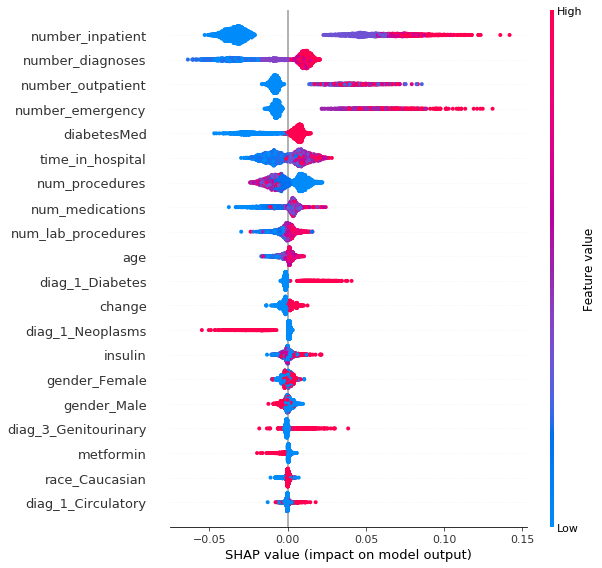

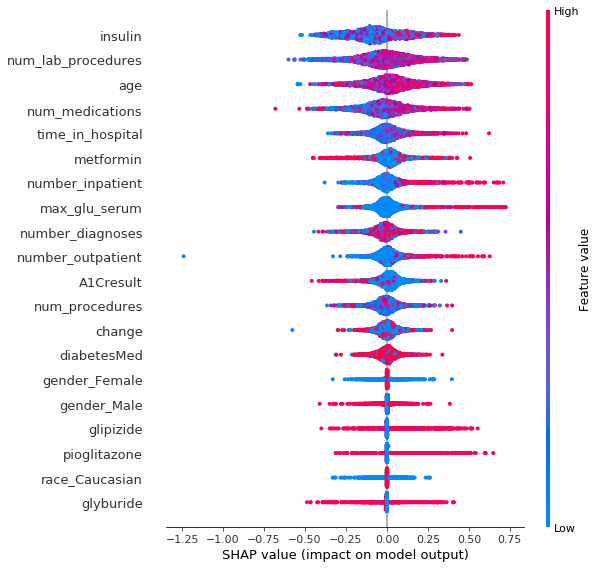

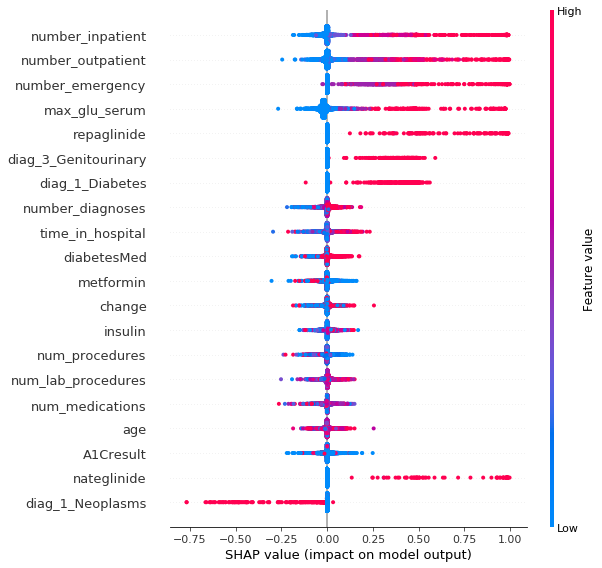

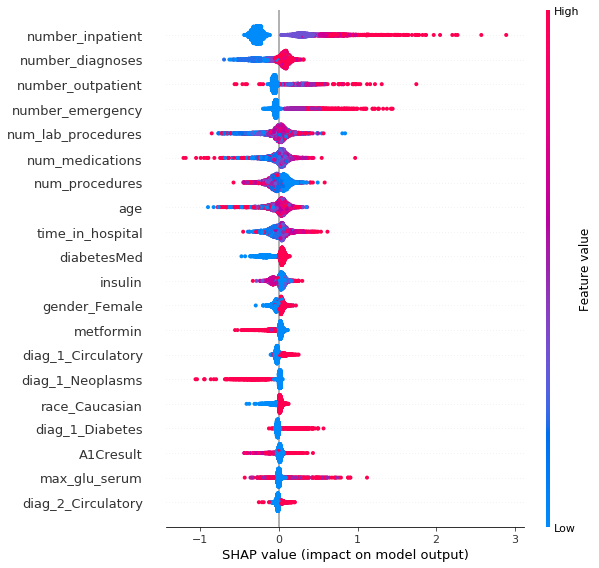

In [21]:
#Plot all the summary plots for SHAP for all models trained on segment 1

shap.summary_plot(rf_shap_values[1], X_test_segment1)
shap.summary_plot(knn_shap_values, X_test_segment1)
shap.summary_plot(gnb_shap_values, X_test_segment1)
shap.summary_plot(xgb_shap_values, X_test_segment1)

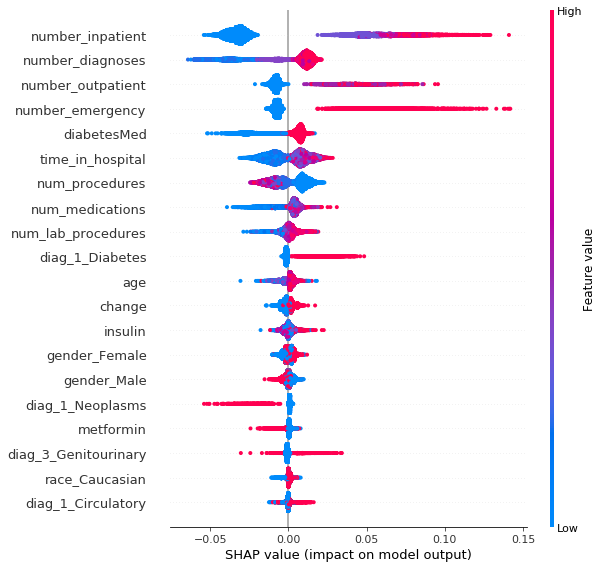

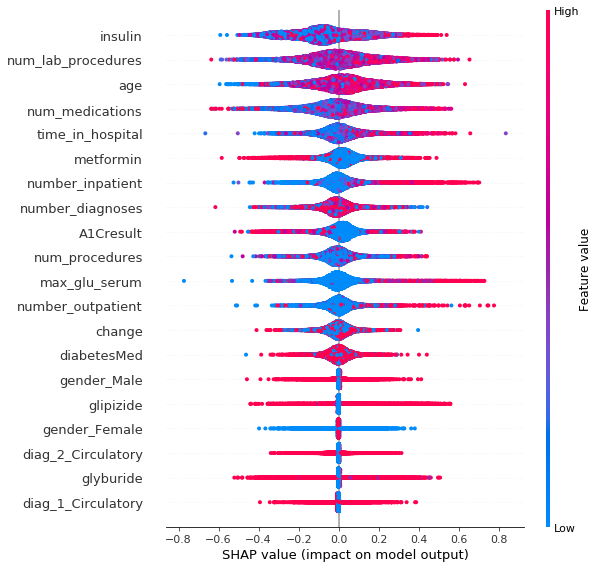

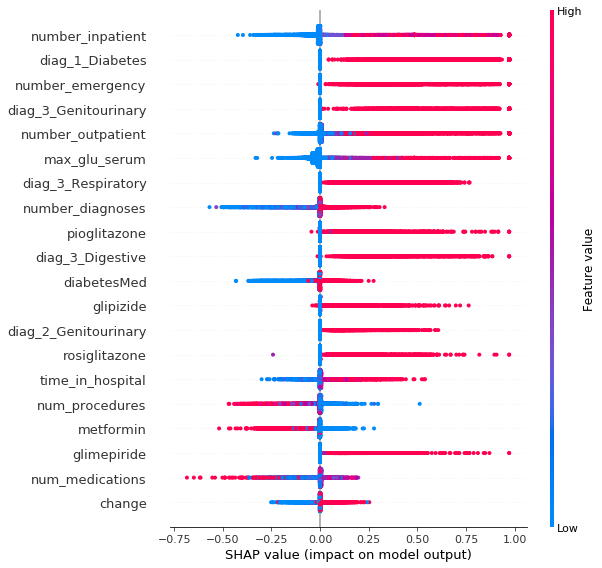

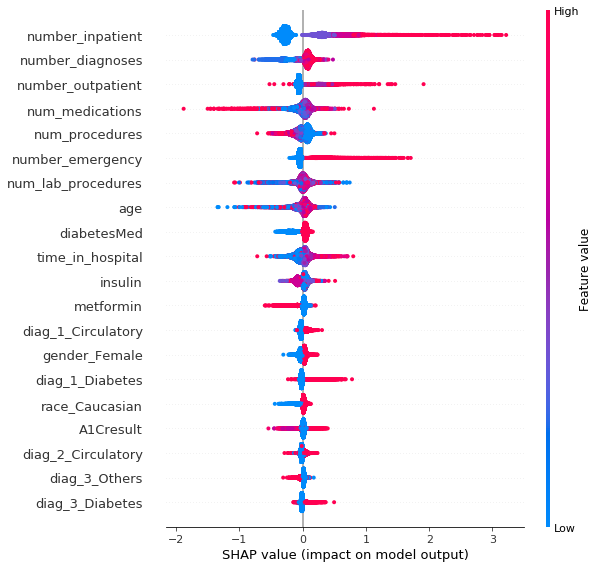

In [22]:
#Plot all the summary plots for SHAP for all models trained on segment 2

shap.summary_plot(rf_shap_values2[1], X_test_segment2)
shap.summary_plot(knn_shap_values2, X_test_segment2)
shap.summary_plot(gnb_shap_values2, X_test_segment2)
shap.summary_plot(xgb_shap_values2, X_test_segment2)

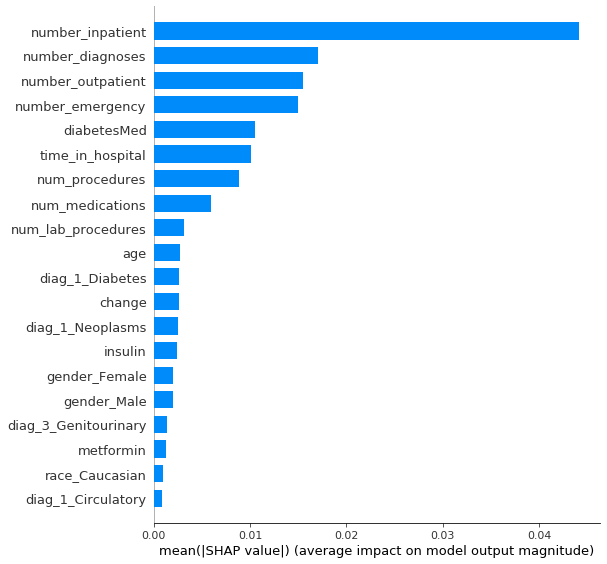

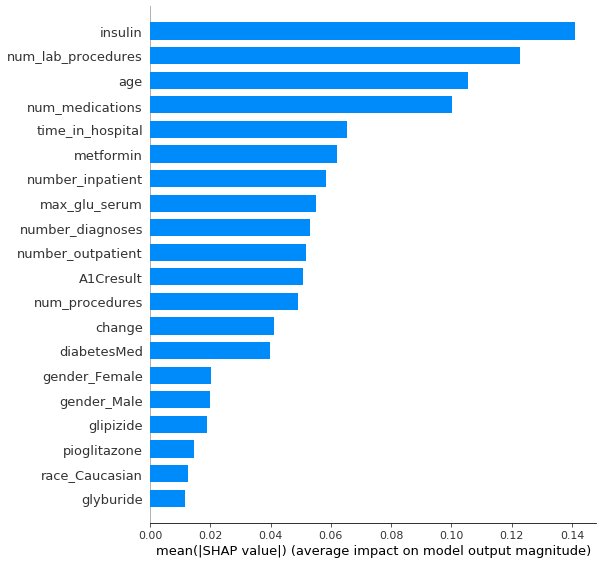

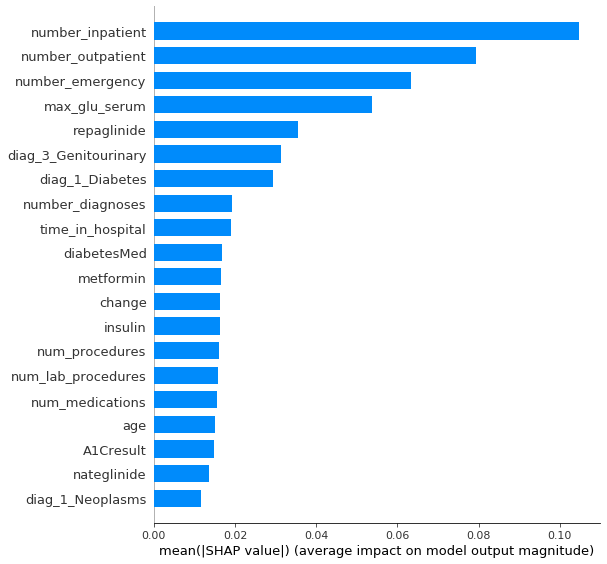

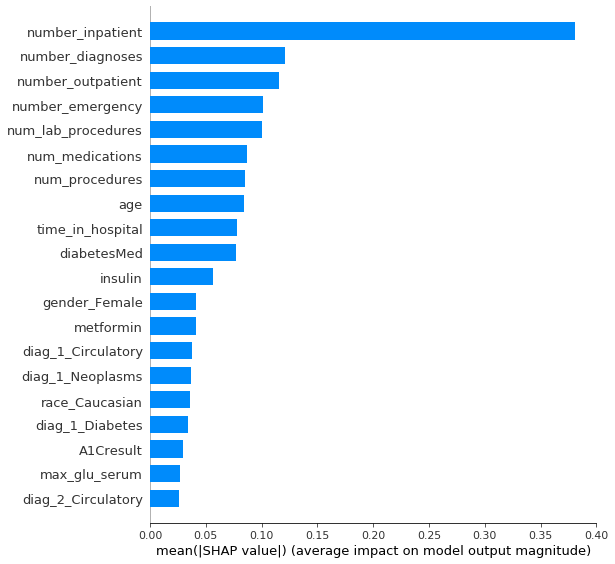

In [23]:
#Plot all the summary bar plots for SHAP for all models trained on segment 1

shap.summary_plot(rf_shap_values[1], X_test_segment1, plot_type='bar')
shap.summary_plot(knn_shap_values, X_test_segment1, plot_type='bar')
shap.summary_plot(gnb_shap_values, X_test_segment1, plot_type='bar')
shap.summary_plot(xgb_shap_values, X_test_segment1, plot_type='bar')

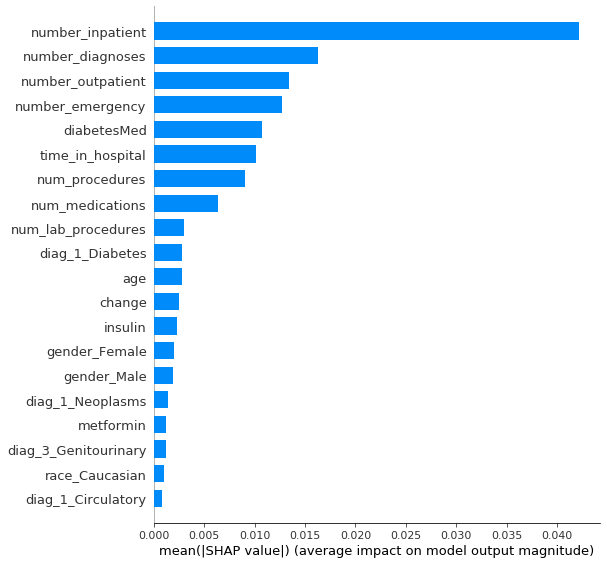

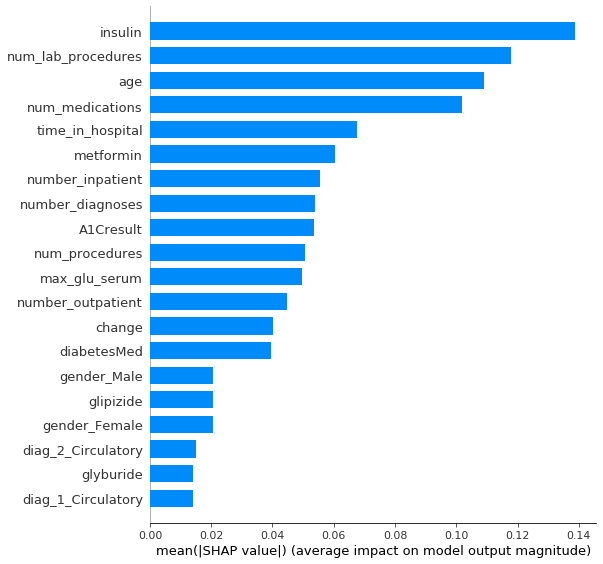

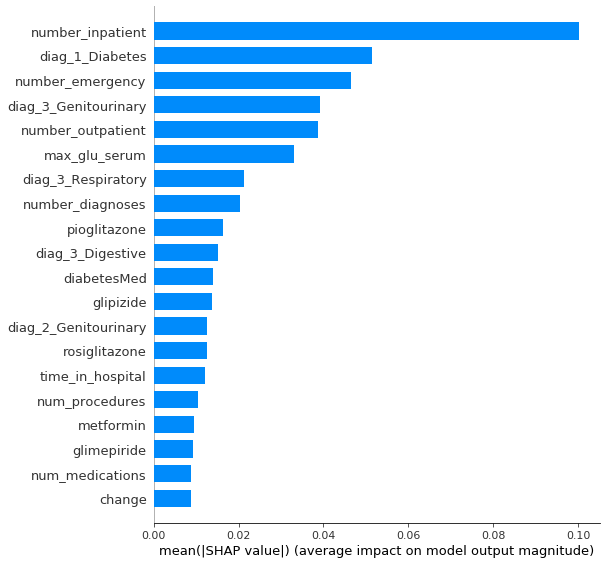

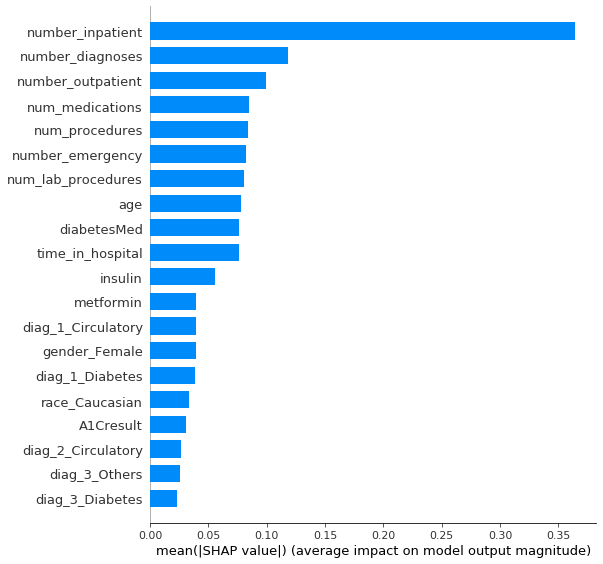

In [24]:
#Plot all the summary bar plots for SHAP for all models trained on segment 2

shap.summary_plot(rf_shap_values2[1], X_test_segment2, plot_type='bar')
shap.summary_plot(knn_shap_values2, X_test_segment2, plot_type='bar')
shap.summary_plot(gnb_shap_values2, X_test_segment2, plot_type='bar')
shap.summary_plot(xgb_shap_values2, X_test_segment2, plot_type='bar')

In [25]:
#Confusion matrix for GNB model for both segments

from sklearn.metrics import confusion_matrix

CM = confusion_matrix(Y_test_segment1, yPredGNB1)

TN = CM[0][0]
FN = CM[1][0]
TP = CM[1][1]
FP = CM[0][1]

print(TP,FP,FN,TN)

CM = confusion_matrix(Y_test_segment2, yPredGNB2)

TN = CM[0][0]
FN = CM[1][0]
TP = CM[1][1]
FP = CM[0][1]
print(TP,FP,FN,TN)

1 1210 2323 1
4807 2081 4251 9839
